### Problem Statement:
    Analyze the dataset of individuals and their details related to their credit for whom loan was provided with some terms. Based on our prediction whether the loan will be repayed or not we need to classify the particular loan. If the loan is assigned also assign the repayment terms as business recommendations.

In [1]:
# Importing Required Libraries for Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats.contingency import association
from statsmodels.stats import contingency_tables as ct
from scipy.interpolate import make_smoothing_spline
from scipy.stats import skew,chi2_contingency
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter 
from sklearn.feature_selection import RFECV
from scipy.stats import uniform, loguniform
from sklearn.metrics import roc_auc_score, confusion_matrix,fbeta_score,make_scorer, precision_recall_curve,average_precision_score,roc_curve,classification_report
import datetime
from pandas.tseries.offsets import DateOffset
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTENC
from scipy.sparse import hstack  


In [3]:
import gdown

file_link = "https://drive.google.com/uc?id=1MJTdMjq6qA3mCAblG-AAZFKt9luX3jia"
output_file = "logistic_regression.csv" # Replace with your desired output file name

gdown.download(file_link, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1MJTdMjq6qA3mCAblG-AAZFKt9luX3jia
To: c:\Users\sanju\Downloads\Project_work\LoanTapAnalysis\LoanTapDataAnalysis\notebooks\logistic_regression.csv
100%|██████████| 100M/100M [00:09<00:00, 11.1MB/s] 


'logistic_regression.csv'

In [4]:
# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
## Data Loading and Initial Inspection
"""
Dataset : logistic_regression.csv

"""
df = pd.read_csv('logistic_regression.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.head(1))

   loan_amnt        term  int_rate  installment grade sub_grade  emp_title  \
0    10000.0   36 months     11.44       329.48     B        B4  Marketing   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years           RENT    117000.0        Not Verified  Jan-2015   

  loan_status   purpose     title    dti earliest_cr_line  open_acc  pub_rec  \
0  Fully Paid  vacation  Vacation  26.24         Jun-1990      16.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   

                                          address  
0  0174 Michelle Gateway\r\nMendozaberg, OK 22690  


# EDA on Loantap Dataset

In [6]:
# Basics Information regarding DataFrame COlumns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [7]:
# Basic Statistics of numerical features:
print(df.describe())
# print(df.columns)

           loan_amnt       int_rate    installment    annual_inc  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean    14113.888089      13.639400     431.849698  7.420318e+04   
std      8357.441341       4.472157     250.727790  6.163762e+04   
min       500.000000       5.320000      16.080000  0.000000e+00   
25%      8000.000000      10.490000     250.330000  4.500000e+04   
50%     12000.000000      13.330000     375.430000  6.400000e+04   
75%     20000.000000      16.490000     567.300000  9.000000e+04   
max     40000.000000      30.990000    1533.810000  8.706582e+06   

                 dti       open_acc        pub_rec     revol_bal  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean       17.379514      11.311153       0.178191  1.584454e+04   
std        18.019092       5.137649       0.530671  2.059184e+04   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%        11.280000       8.000000       0.000

*   Dataset has 396030 rows with 27 columns (26 features).
*   Dataset consists of different types of features.
*   'loan_amnt', 'int_rate', 'installment','annual_inc','dti','open_acc', 'pub_rec', 'revol_bal','revol_util', 'total_acc','initial_list_status', 'application_type','mort_acc' and  'pub_rec_bankruptcies' seem to be numerical types.
*    Loan amount varies from 500 to 40000 with a standard deviation around 8000
*    Interest rate varies from 5 to 30.
*    dti (Debt to income) and Annual income can be mulipllied to form a new interaction term - debt for analysis
*    Annual income varies from to 0 to 8000000. There seems to be lot of outliers in this column
*  We will first split the data into training and test datasets and visualize different columns and compare with target variable "loan_status" and train and fit Logistic Regression model on training set and use that to predict for test dataset and see how the model has performed.

In [9]:
# Checking for  dupicate rows in DataFrame
df[df.duplicated( keep = 'first')]

Empty DataFrame
Columns: [loan_amnt, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, purpose, title, dti, earliest_cr_line, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, application_type, mort_acc, pub_rec_bankruptcies, address]
Index: []

[0 rows x 27 columns]

In [10]:
# Checking for missing values in Dataframe
missing_value_counts = df.isna().sum()
missing_value_counts[missing_value_counts>0]

emp_title               22927
emp_length              18301
title                    1756
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

*   The dataset does not have duplicate rows
*   The dataset has missing values in emp_title,emp_length,title,revol_util,mort_acc,pub_rec_bankruptcies.

In [12]:
# As loan_status is the target variable , Checking if there is imbalance in loan_status
loan_status_freq = df['loan_status'].value_counts()
target_imbalance = loan_status_freq['Fully Paid']/loan_status_freq['Charged Off']
print(target_imbalance)

4.098682940017767


The dataset is imbalanced on the target feature loan_status with 4 times non defaulted loans compared to defaulted loans.

In [14]:
loan_data = df.copy() # Creating a copy of training data for EDA.

In [15]:
#  Unique values in each object column
for col in loan_data.columns:
    if loan_data[col].dtype == 'object' and len(loan_data[col].unique())<100:
        print( "Unique values in column ",col,":",list(loan_data[col].unique()))
    elif loan_data[col].dtype == 'object':
        print(col,"has more than 100 unique values, Eg : ",list(loan_data[col].dropna().unique()[:10]))


Unique values in column  term : [' 36 months', ' 60 months']
Unique values in column  grade : ['B', 'A', 'C', 'E', 'D', 'F', 'G']
Unique values in column  sub_grade : ['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4', 'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5', 'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4', 'F2', 'G3']
emp_title has more than 100 unique values, Eg :  ['Marketing', 'Credit analyst ', 'Statistician', 'Client Advocate', 'Destiny Management Inc.', 'HR Specialist', 'Software Development Engineer', 'Office Depot', 'Application Architect', 'Regado Biosciences']
Unique values in column  emp_length : ['10+ years', '4 years', '< 1 year', '6 years', '9 years', '2 years', '3 years', '8 years', '7 years', '5 years', '1 year', nan]
Unique values in column  home_ownership : ['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE', 'ANY']
Unique values in column  verification_status : ['Not Verified', 'Source Verified', 'Verified']
issue_d h

*   Loan term and Employee Length can be converted to numerial variable.
*   Grade and sub grade can be converted to ordinal variables.
*   Employee title, title, address need to be explored further.
*   Variables with few categories like Home Ownership, Verification Status, Initial List Status, Application Type could be one hot encoded.
*   Issue date and Earliest Credit line can be converted to dates and be handled as dates.
*   Loan purpose has a large number of categories. The number of categories can be reduced based on frequency of occurence.

## Address Feature

In [18]:
# Checking if address column has unique rows
df[df['address'].duplicated(keep = False )].sort_values(by = 'address').head()

loan_amnt        term  int_rate  installment grade sub_grade  \
188250    35000.0   60 months     24.89      1025.05     F        F4   
361453     9325.0   36 months     18.49       339.42     D        D2   
277013    10000.0   36 months     11.66       330.53     C        C3   
333117    21000.0   36 months      7.90       657.10     A        A4   
203472    18000.0   36 months     14.09       615.99     B        B5   

                         emp_title emp_length home_ownership  annual_inc  ...  \
188250                 BAE Systems  10+ years       MORTGAGE    102800.0  ...   
361453  Marietta Memorial Hospital  10+ years       MORTGAGE     27850.0  ...   
277013                     Imagine     1 year           RENT     64000.0  ...   
333117                     Experis  10+ years       MORTGAGE    100000.0  ...   
203472                     us army    5 years           RENT     72000.0  ...   

       open_acc pub_rec revol_bal revol_util total_acc  initial_list_status  \
188250      9.0     0.0   11560.0       85.0      21.0                    f   
361453      3.0     0.0   10740.0       82.6       7.0                    w   
277013     10.0     0.0    2388.0       48.7      22.0                    f   
333117      9.0     0.0   29774.0       51.5      30.0                    w   
203472      8.0     0.0   17605.0       78.6      17.0                    f   

       application_type  mort_acc  pub_rec_bankruptcies  \
188250       INDIVIDUAL       6.0                   0.0   
361453       INDIVIDUAL       0.0                   0.0   
277013       INDIVIDUAL       NaN                   NaN   
333117       INDIVIDUAL       3.0                   0.0   
203472       INDIVIDUAL       0.0                   0.0   

                            address  
188250  USCGC Adams\r\nFPO AA 00813  
361453  USCGC Adams\r\nFPO AA 00813  
277013  USCGC Adams\r\nFPO AE 29597  
333117  USCGC Adams\r\nFPO AE 29597  
203472  USCGC Adams\r\nFPO AE 30723  

[5 rows x 27 columns]

In [19]:
# There seems to be duplicate values of addresses .Checking first 20 values
print(loan_data['address'].head(5))

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object


In [20]:
# Checking for patterns in address
print(loan_data['address'].head(5).apply(lambda x: x.split('\r')))

0     [0174 Michelle Gateway, \nMendozaberg, OK 22690]
1    [1076 Carney Fort Apt. 347, \nLoganmouth, SD 0...
2    [87025 Mark Dale Apt. 269, \nNew Sabrina, WV 0...
3            [823 Reid Ford, \nDelacruzside, MA 00813]
4             [679 Luna Roads, \nGreggshire, VA 11650]
Name: address, dtype: object


The last term in address seems to be the zipcodes

In [22]:
zipcodes = loan_data['address'].apply(lambda x : x.split()[-1]) # Taking last term in address
print(zipcodes.unique())

['22690' '05113' '00813' '11650' '30723' '70466' '29597' '48052' '86630'
 '93700']


In [23]:
states = loan_data['address'].apply(lambda x : x.split()[-2]) # Taking last but one term in address
print(states.unique())

['OK' 'SD' 'WV' 'MA' 'VA' 'DE' 'TX' 'AE' 'AP' 'NM' 'MS' 'OR' 'NH' 'HI'
 'PA' 'CO' 'AL' 'FL' 'AZ' 'WI' 'NC' 'IN' 'MO' 'AA' 'TN' 'KS' 'ND' 'CT'
 'WY' 'NE' 'RI' 'AR' 'MI' 'IL' 'LA' 'NY' 'IA' 'AK' 'UT' 'MD' 'WA' 'MN'
 'OH' 'MT' 'NJ' 'DC' 'NV' 'VT' 'CA' 'ME' 'ID' 'GA' 'KY' 'SC']


The last but one term in Address seems to be a common state like terms

In [25]:
for i in loan_data['address'].iloc[:10]:
    print(i.split('\n')[-1][:-8].strip(", "))

Mendozaberg
Loganmouth
New Sabrina
Delacruzside
Greggshire
North Deniseberg
East Stephanie
FPO
FPO
Mauricestad


In [26]:
towns = pd.DataFrame(loan_data['address'].apply(lambda x : x.split('\n')[-1][:-8].strip(", "))) # Taking the term before state in address
towns_frequency = towns['address'].value_counts().sort_values(ascending = False)
print(towns_frequency.head(10))

address
DPO              14289
APO              14060
FPO              14035
East Michael       311
Port Michael       305
Lake Michael       290
New Michael        287
North Michael      284
West Michael       284
South Michael      279
Name: count, dtype: int64


In [27]:
# Plotting town freequency along with target.
town_status = pd.DataFrame(towns).rename(columns={'address':'towns'})#.reset_index(names = 'id')
town_status['towns'] = town_status['towns'].apply(lambda x:  x if x in ['DPO','APO','FPO'] else 'Others')
town_status['loan_status'] = loan_data['loan_status']
town_status = town_status.reset_index(names = 'id').pivot_table(values = 'id',index='towns' , columns = 'loan_status',aggfunc='count')
print(town_status)

loan_status  Charged Off  Fully Paid
towns                               
APO                 2805       11255
DPO                 2796       11493
FPO                 2746       11289
Others             69326      284320


The town term in the address is distributed equally across the dataset.

In [29]:
# Chi Square test when using all towns with loan status
data = pd.crosstab(towns['address'], loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 0.6542747165513597
Independent (H0 holds true)


In [30]:
# Chi Square test when using only FPO, DPO,APO towns and rest as  'Others' with loan status
data = pd.crosstab(towns['address'].apply(lambda x: x if x in ['FPO','DPO','APO'] else 'Others'), loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.7832380720706819
Independent (H0 holds true)


 Based on the chi square term It seems town term in Address does not affect the Loan Status. We can ignore this term

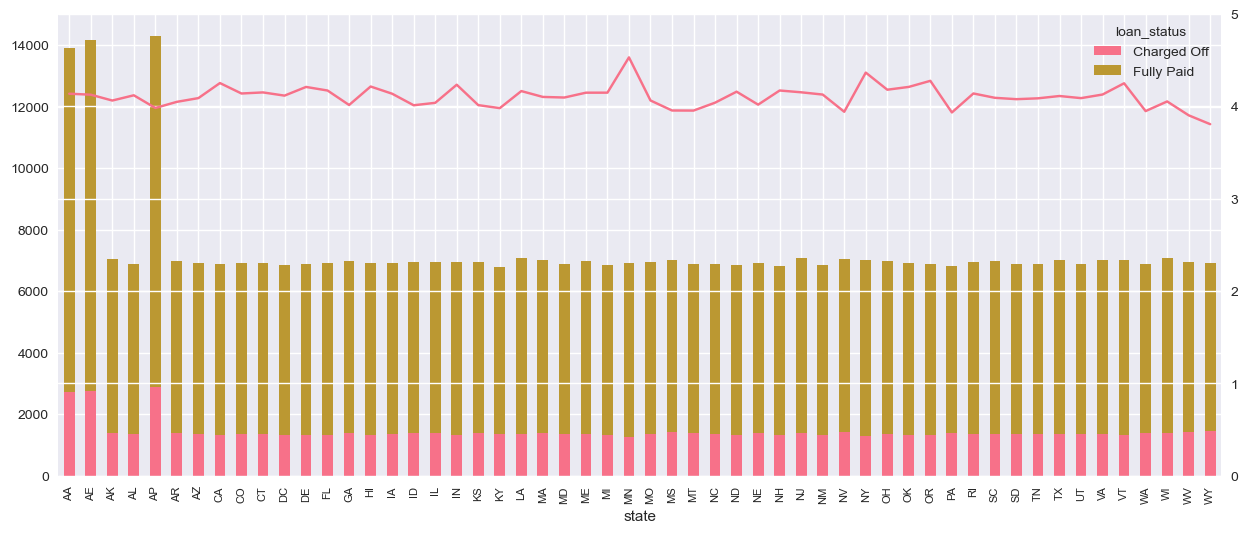

In [32]:
# Plotting state freequency along with target.
state_status = pd.DataFrame(states).rename(columns={'address':'state'})#.reset_index(names = 'id')
state_status['loan_status'] = loan_data['loan_status']
state_status = state_status.reset_index(names = 'id').pivot_table(values = 'id',index='state' , columns = 'loan_status',aggfunc='count')

fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(fontsize=8)
state_status.plot(kind = 'bar',stacked = True ,ax=ax , )
ax2 = ax.twinx()
ax2.set_yticks([0,1,2,3,4,5])
ax2.plot(state_status['Fully Paid']/state_status['Charged Off'],scaley=False)



The state term is distributed equally except 3 categories. The loan status ratios varie very slightly across states 

In [34]:
# Chi Square test between State term and Loan Status
data = pd.crosstab(states, loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.6495028321544145
Independent (H0 holds true)


State seems to be independent of Loan Status . We can ignore term.

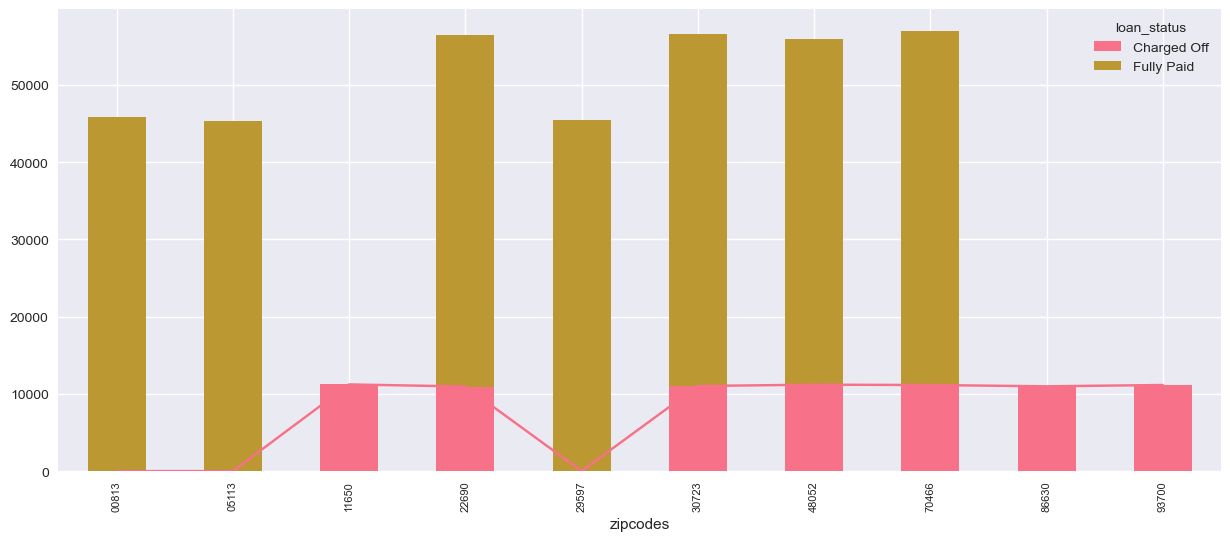

In [36]:
# Plotting zipcodes freequency along with target.
zipcodes_status = pd.DataFrame(zipcodes).rename(columns={'address':'zipcodes'})#.reset_index(names = 'id')
zipcodes_status['loan_status'] = loan_data['loan_status']
zipcodes_status = zipcodes_status.reset_index(names = 'id').pivot_table(values = 'id',index='zipcodes' , columns = 'loan_status',aggfunc='count',fill_value=0)

fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(fontsize=8)
zipcodes_status.plot(kind = 'bar',stacked = True ,ax=ax  )
r_p = ax.plot((zipcodes_status['Charged Off']))


3 zipcodes seem to have only defaulted loans. 3 of them have only fully paid loans. rest of the 4 have approximately 1:4 ratio of default to fully paid loans

In [38]:
zipcodes_status

loan_status  Charged Off  Fully Paid
zipcodes                            
00813                  0       45824
05113                  0       45402
11650              11226           0
22690              10954       45573
29597                  0       45471
30723              11021       45525
48052              11192       44725
70466              11148       45837
86630              10981           0
93700              11151           0

In [39]:
# Chi Square test for Loan Status and Pincode
data = pd.crosstab(zipcodes, loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


In [40]:
association(data,method='cramer') # Association between Loan Status and Pincode is very high

0.6553408647141161

Insights about zipcodes column
*   3 zipcodes have all defaulted loans and 3 zipcodes have all fully paid loans. The rest have default rate of 25%
*   zipcodes seems to be a valuable feature as the target ratio for different zipcodess are in extremes.
*   One Hot encoding can be applied to this column as it has lesser number categories (10) , to get maximum information from this column

## Loan term, Loan Grade, Home Ownership, Verification Status, Loan Status, Initial List Status, Application Type

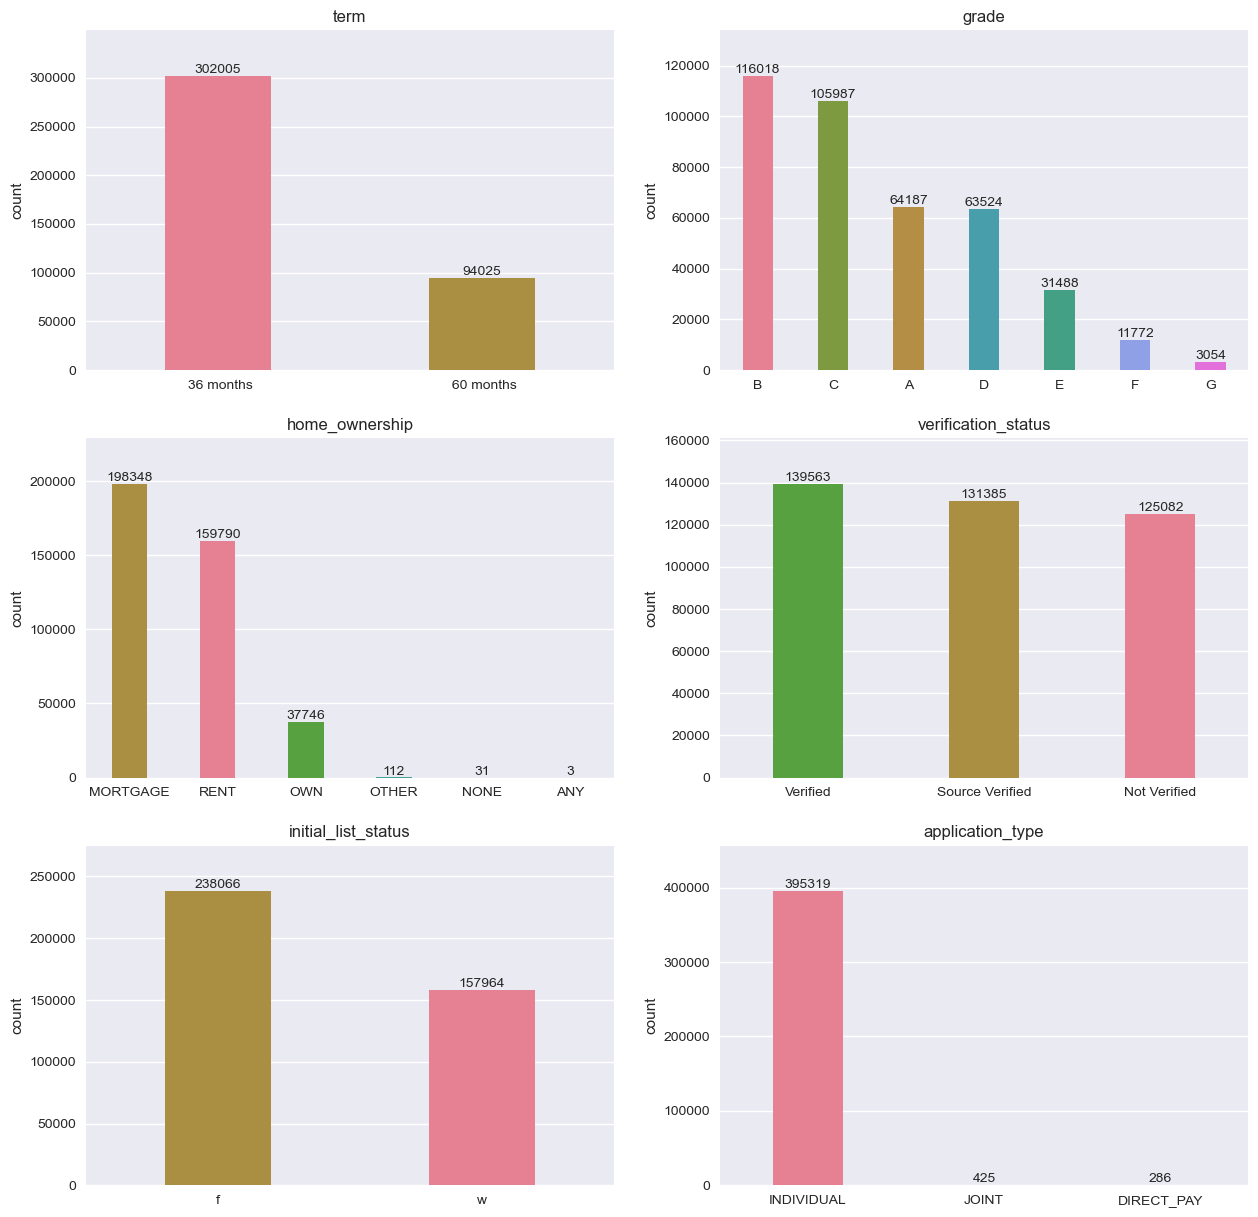

In [43]:
# Count plots for categorical columns Loan term, Loan Grade, Home Ownership, Verification Status, Loan Status, Initial List Status, Application Type
cate_columns = ['term','grade','home_ownership','verification_status','initial_list_status','application_type']
r = 0
fig, ax =plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    for j in range(2):
        sns.countplot(x = loan_data[cate_columns[r]].rename(''),order = loan_data[cate_columns[r]].value_counts(ascending=False).index,hue = loan_data[cate_columns[r]],ax = ax[i][j],orient = 'v',width = 0.4, ).set_title(cate_columns[r])
        bottom,top = ax[i][j].get_ylim()
        ax[i][j].set_ylim(top = top*1.1)
        abs_values = loan_data[cate_columns[r]].value_counts(sort = False).values
        for p,q in zip(ax[i][j].containers,abs_values):
            ax[i][j].bar_label(container= p, labels=[q])
        r+=1
        if r==6:
            break

*  There are more than 3 times no of loans with 36 month term than 60 month terms.
*  frequency of grades varies as B > C > A > D > E > F > G
*  Most of the loanees either have mortgages or rent their houses.Only 10% of loanees own their houses.
*  Most of the loans are individual loans
*  A third of the loans are not verified.
*  More than half of the loans are listed as fractional and rest are whole loans

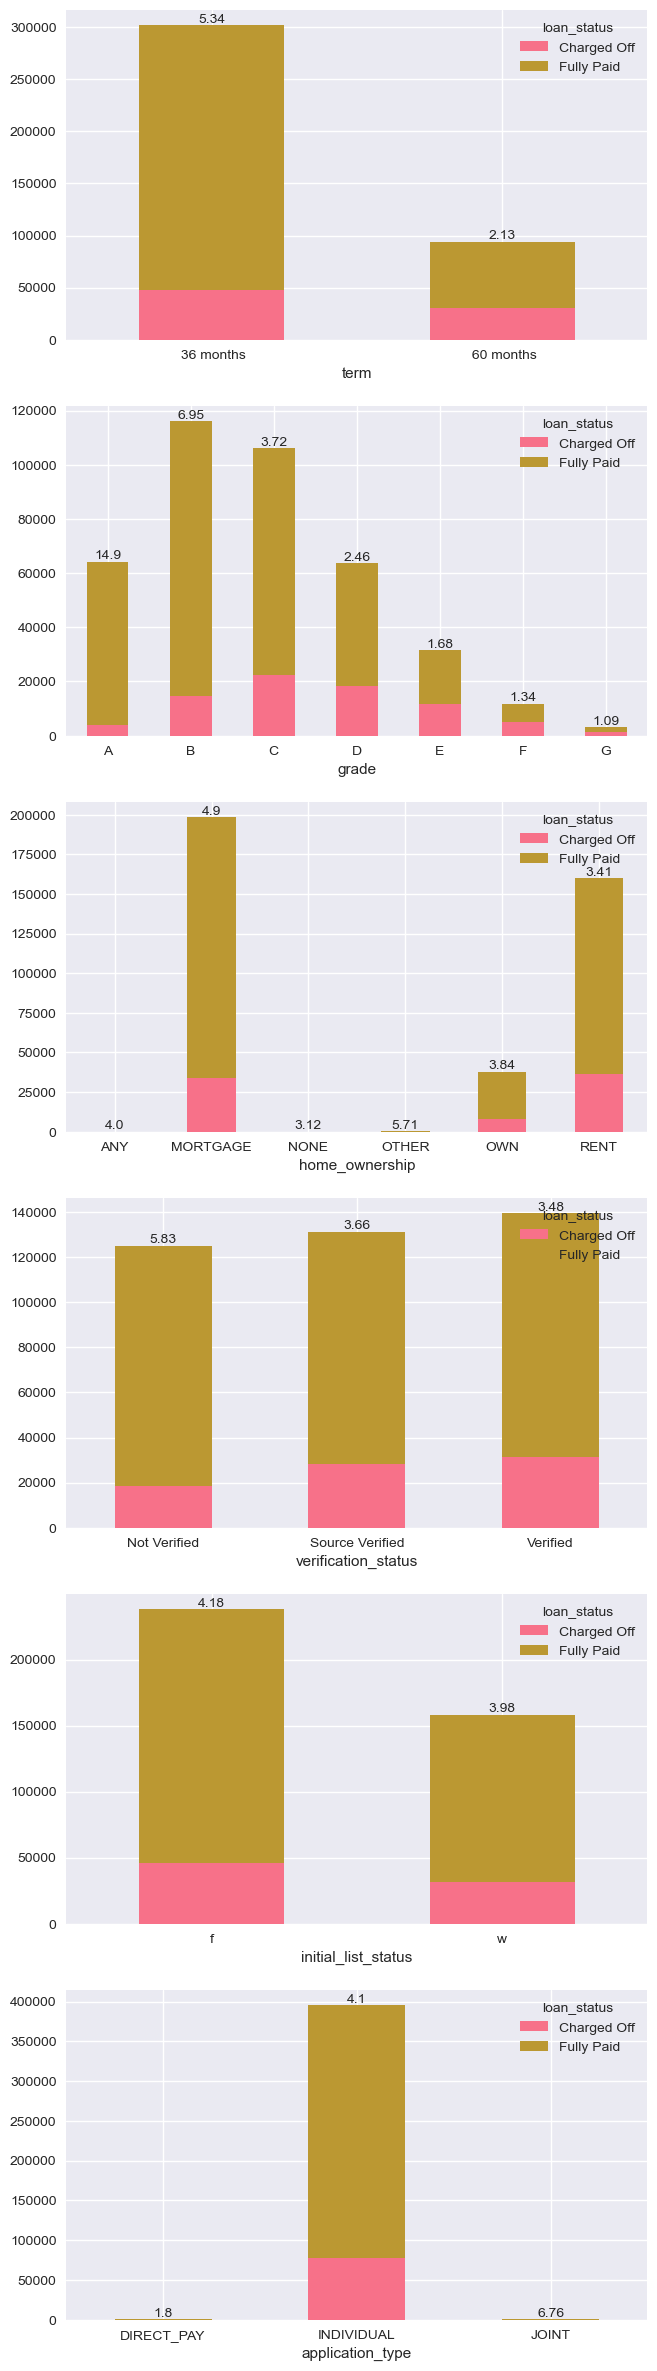

In [45]:
# Plotting target distribution with different categories in loan term, grade, home ownership, verification status, initial list status, application type
cate_columns = ['term','grade','home_ownership','verification_status','initial_list_status','application_type']
fig,ax = plt.subplots(len(cate_columns),1)
fig.set_figheight(30)
fig.set_figwidth(7.5)
for i in range(len(cate_columns)):
    pd.crosstab(loan_data[cate_columns[i]],loan_data['loan_status']).plot(kind='bar', stacked=True,ax= ax[i],fontsize=10)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 0)
    (bottom,top) = ax[i].containers
    (bottom_labels,top_labels) = (bottom.datavalues,top.datavalues)
    ratios = [np.round((top_labels[i]+1)/(bottom_labels[i]+1),2) for i in range(len(top))]
    ax[i].bar_label(top,labels = ratios,label_type = 'edge')

*  Loans with term of 60 months are 2.5 times more likely to default that loans with term of 36 months
*  The default rate decreases with increasing grade.
*  Loanees with mortgaged houses are more likely to default
*  Loanees who owh or rent houses have similar default rates
*  Source verified and verified loans have lesser defaults compared to not verified loans
*  f and w loans have slightly different defasult rates
*  Most loans are indiviudulal loans and other application types have very less number of data points to justify any insight

In [47]:
# Chi Square test and Association strength between Loan Status and  each of loan term, grade, home ownership, verification status, initial list status, application type

for i in cate_columns:
    data = pd.crosstab(loan_data[i], loan_data['loan_status'])
    stat, p, dof, expected = chi2_contingency(data)
    # interpret p-value
    alpha = 0.05
    print(i,"p value is " + str(p),end = ' ')
    if p <= alpha:
        print('Dependent (reject H0). The association strength is',association(data,method = 'cramer'))
    else:
        print('Independent (H0 holds true)')
    

term p value is 0.0 Dependent (reject H0). The association strength is 0.17324635193513466
grade p value is 0.0 Dependent (reject H0). The association strength is 0.25788603980139285
home_ownership p value is 0.0 Dependent (reject H0). The association strength is 0.0685435449007094
verification_status p value is 0.0 Dependent (reject H0). The association strength is 0.08561791376705935
initial_list_status p value is 2.408916483118551e-09 Dependent (reject H0). The association strength is 0.009489140835413308
application_type p value is 1.1418557766942247e-13 Dependent (reject H0). The association strength is 0.0122677811415175


In [48]:
# Checking Ordinal association of grade with Loan status
# Create a contingency table with ordinal order preserved
contingency_table = pd.crosstab(
    loan_data['grade'],  # Ordinal variable
    loan_data['loan_status'],          # Binary target
    rownames=['Grade'],
    colnames=['Default']
).loc[['A','B','C','D','E','F','G']]  # Ensure order is preserved

# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}")
print(f"P-value: {result.pvalue}")
contingency_table

Chi2 Statistic (Trend): 526190.0
P-value: 0.0


Default  Charged Off  Fully Paid
Grade                           
A               4036       60151
B              14587      101431
C              22449       83538
D              18338       45186
E              11765       19723
F               5037        6735
G               1461        1593

In [49]:
# converting Loan term to numerical feature and finding correlation with target:
loan_term = pd.DataFrame(loan_data['term'].apply(lambda x: int(x[1:3])))
loan_term['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
loan_term.corr().loc['term','loan_status']

0.17324635193513468

Loan term insights
*    The data set is more biased towards loan term of 36 months
*    36 months has a fully paid to charged off ratio of 5 compared with 2 for 60 months.
*    Loan term when used as a number has very less correlation with target variable.
*    Compared to State is has less strength in terms of predicting loan status.
*    We can try one hot encoding for our prediction

Grade column insights
*    The data set is unequally distributed across A through G.
*    Fully paid to cherged off ratio increases with higher grade.
*    It has high association strength in tterms of predicting loan status.
*    We can try one hot encoding as there are only 7 grades for our prediction

Home Ownership column insights
*   Majority of the values are in Mortgage, Rent or Own.
*   We can combine rest as 'Others'.
*   The target ratios (Mortgage: 4.9, Own: 3.8, Rent: 3.4) are significant here and one hot encoding can be applied
*   As "ANY","OTHER" and "NONE" have very less no of rows compared to rest we can combine them as "Others". 

Verification Status column insights
*  The data is almost equally distributed between Verified, Not Verified and Source Verified.
*  The target ratios (Not Verified: 5.8, Source Verfied: 3.67, Verfied: 3.47) are significant here and one hot encoding can be applied as there are only 3 categories.

Initial List Status column insights
*  The data is slightly biased towards f category.
*  The target ratios are slightly different and one hot encoding can be used here as there are only two categories
*  Because of low cramers v  we will ignore this feature.

Application Type column Status
*  The application type column has one major category Individual and the rest of the categories constitute a very small percentage.
*  This column can be dropped as the majority rows have the same category and do not add any significant information for prediction.

## Sub grade

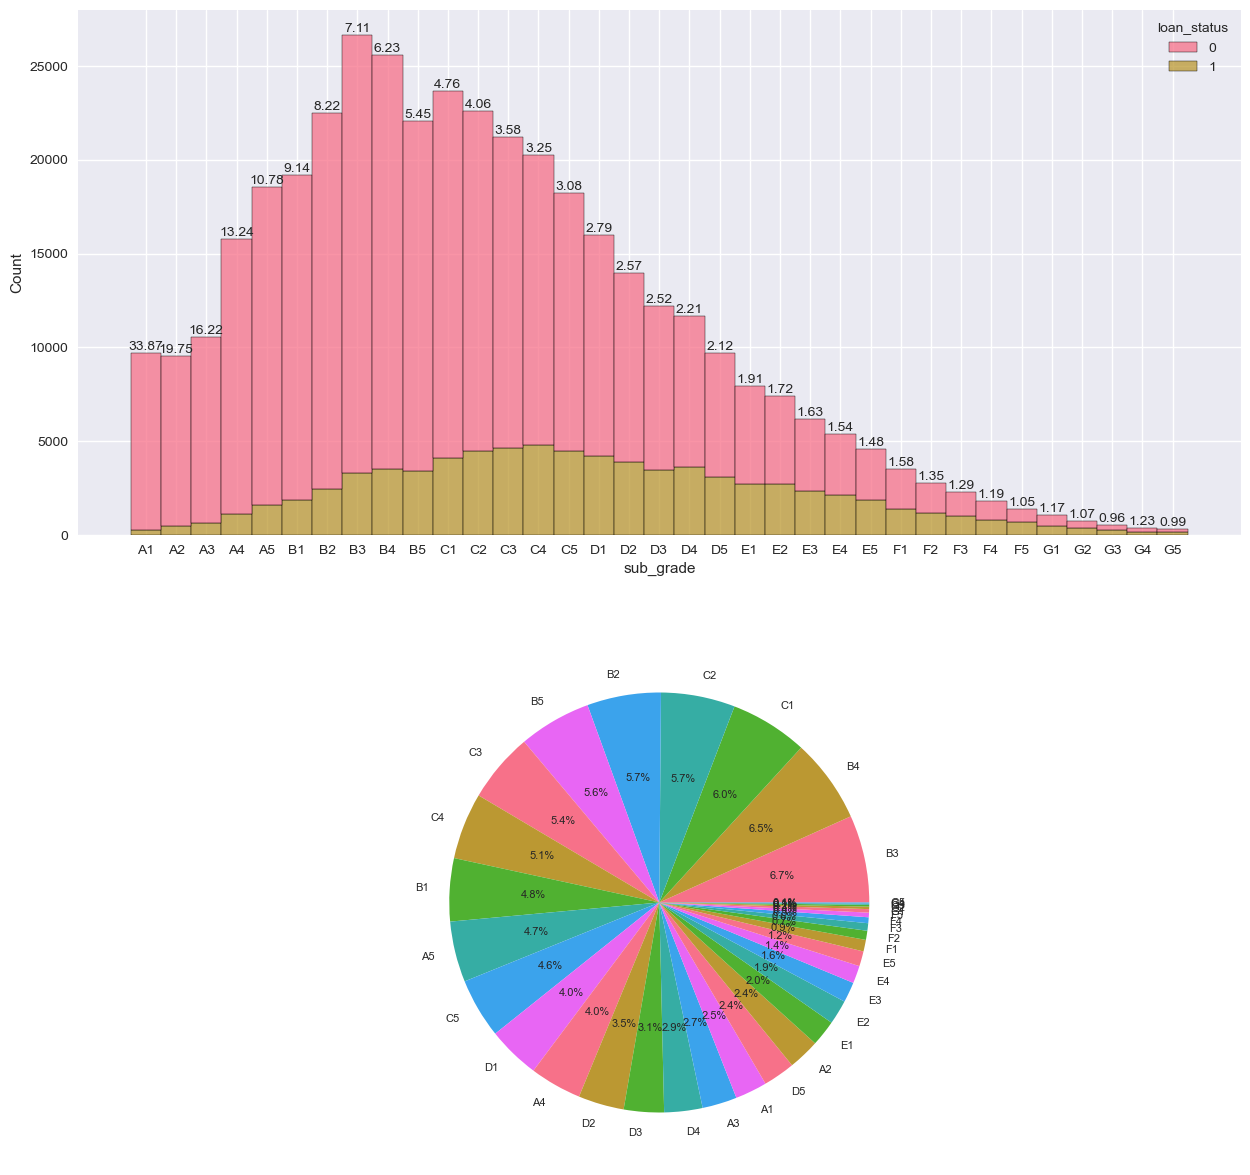

In [57]:
# Sub grade feature viz
fig,ax = plt.subplots(2,1)
fig.set_figheight(15)
fig.set_figwidth(15)

sub_grade_sorted =pd.DataFrame(loan_data['sub_grade'])
sub_grade_sorted['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
sub_grade_sorted = sub_grade_sorted.sort_values(by = 'sub_grade')
# Histogram with stacked plot for subgrade with target vales
sns.histplot(sub_grade_sorted,ax = ax[0],multiple='stack',stat = 'count', x = 'sub_grade',element='bars',legend = True,hue = 'loan_status')
# Making labels for loan_status ratio.
labels = [np.round(i[1]/i[0],2) for i in zip(ax[0].containers[0].datavalues,ax[0].containers[1].datavalues)]

rects = ax[0].containers[1].patches
rects2 = ax[0].containers[0].patches
for rect,rect2, label in zip(rects,rects2, labels):
     height = rect.get_height()
     height2 = rect2.get_height()
     ax[0].text(
         rect.get_x() + rect.get_width() / 2, height+height2, label, ha="center", va="bottom"
     )
ax[1].pie( sub_grade_sorted['sub_grade'].value_counts(), labels = list(sub_grade_sorted['sub_grade'].value_counts().keys()),autopct='%1.1f%%',textprops={'fontsize': 8})
plt.show()

The sub grades are skewed to the right. That is lower grades are more diverse and have lesser frequency and higher grades are more common.
The default ratio decreases with increase in sub grade as expected.

In [59]:
ord_enc = OrdinalEncoder()
print("Skew of the Sub grade distribution is : ",skew(ord_enc.fit_transform(pd.DataFrame(sub_grade_sorted['sub_grade'])))[0])

Skew of the Sub grade distribution is :  0.6043400906793683


Sub grade has a positive moderate skew indicating right skewed distribution. Square root transformation could be appropriate for subgrade

In [61]:
sub_grade_status = pd.crosstab(index = loan_data['sub_grade'],columns = loan_data['loan_status'])
sub_grade_status['ratio'] = sub_grade_status['Fully Paid']/sub_grade_status['Charged Off']
np.corrcoef(sub_grade_status.reset_index().index,sub_grade_status['ratio'])

array([[ 1.      , -0.741005],
       [-0.741005,  1.      ]])

The sub grade ordinal encoded is highly correlated with the loan default ratio

In [63]:
# Chi Square test  between subgrade and  loan status
data = pd.crosstab(loan_data['sub_grade'], loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 0.0
Dependent (reject H0)


In [64]:
# Checking Ordinal association of Sub grade with Loan status
# Create a contingency table with ordinal order preserved
contingency_table = pd.crosstab(
    loan_data['sub_grade'],  # Ordinal variable
    loan_data['loan_status'],          # Binary target
    rownames=['Sub_Grade'],
    colnames=['Default']
).loc[['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5']]  # Ensure order is preserved

# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}","Cramers V association",association(contingency_table,method="cramer"))
print(f"P-value: {result.pvalue}")

Chi2 Statistic (Trend): 3255545.0 Cramers V association 0.2638014456542665
P-value: 0.0


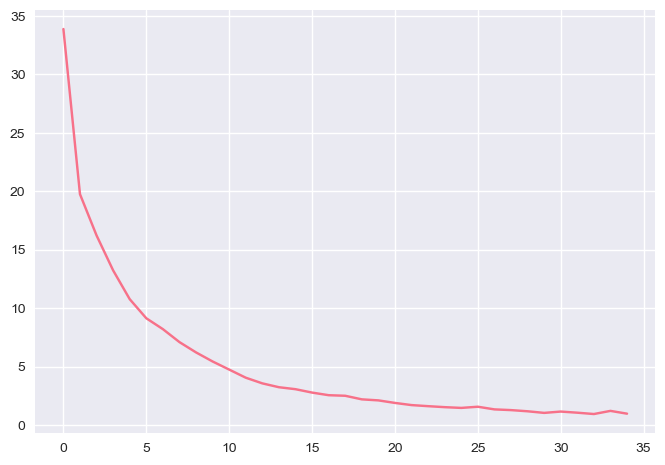

In [65]:
# The Association appears to be unusually strong. Plotting proportions vs ordinal sub grade

sg_enc = OrdinalEncoder()
plt.plot(sg_enc.fit_transform(pd.DataFrame(sub_grade_status.index)).reshape(1,-1)[0],list(sub_grade_status['ratio']))

The default rate increases with decreasing sub grade . The trend between sub grade ordinal encoded and loan default ratio is almost hyperbolic. We can use this information for the transformation to be applied on the sub grade

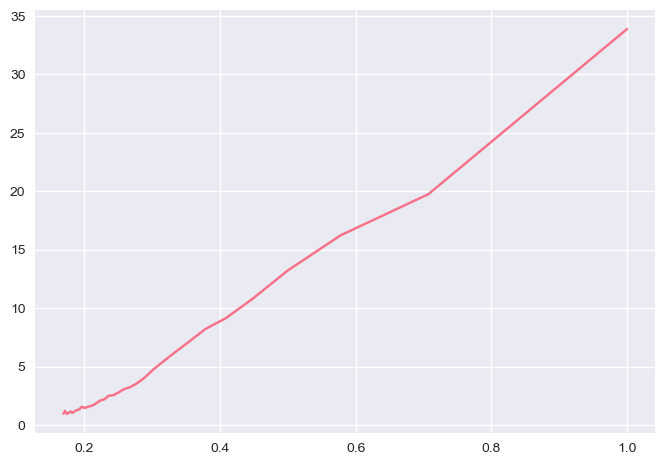

In [67]:
# The graph appears hyberbolic . Applying polynolial transformation on ordinal values and plotting wih proportions.
plt.plot(1 / np.sqrt(sg_enc.fit_transform(pd.DataFrame(sub_grade_status.index)).reshape(1,-1)[0]+1),list(sub_grade_status['ratio']))

The loan default ratio has a linear trend with the transformed sub grade

In [69]:
# Checking grade feature correspond to similar subgrade values
loan_data.groupby('grade')['sub_grade'].unique()

grade
A    [A2, A1, A5, A4, A3]
B    [B4, B5, B3, B2, B1]
C    [C5, C3, C1, C2, C4]
D    [D1, D3, D5, D2, D4]
E    [E4, E1, E2, E5, E3]
F    [F4, F5, F1, F3, F2]
G    [G1, G2, G5, G4, G3]
Name: sub_grade, dtype: object

Sub grade column insights
*   Sub grade is distributed unevenly across all subgrades with most subgrades between A4 to D4.
*   Fully paid to cherged off ratio increases with higher grade.
*    We can try ordinal encoding and apply transformations for our prediction
*    Sub grade A values correspond to grade A and follows this pattern for all grades . We can exclude grade and use sub grade ordinal encoded in our prediction model.

## Employment Length

In [72]:
# Categories in Employee Length
loan_data['emp_length'].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [73]:
# Displaying rows where Employee length is missing, and percentage employee length missing in dataset
print(loan_data[loan_data['emp_length'].isna()].describe())
print("Percentage missing in Employee length:", loan_data['emp_length'].isnull().sum() * 100 / loan_data.shape[0])

          loan_amnt      int_rate   installment    annual_inc           dti  \
count  18301.000000  18301.000000  18301.000000  1.830100e+04  18301.000000   
mean   11181.888968     13.734571    353.584172  4.951422e+04     19.325857   
std     7401.754392      4.426127    226.442581  3.752955e+04     75.256642   
min     1000.000000      5.320000     23.010000  0.000000e+00      0.000000   
25%     5575.000000     10.740000    186.970000  2.900000e+04     12.030000   
50%     9775.000000     13.490000    306.450000  4.400000e+04     18.390000   
75%    15000.000000     16.590000    469.290000  6.155800e+04     25.050000   
max    40000.000000     30.990000   1372.970000  2.500000e+06   9999.000000   

           open_acc       pub_rec      revol_bal    revol_util     total_acc  \
count  18301.000000  18301.000000   18301.000000  18290.000000  18301.000000   
mean      10.160920      0.299437   13208.913666     50.658590     24.262281   
std        4.799585      0.632243   18213.674781

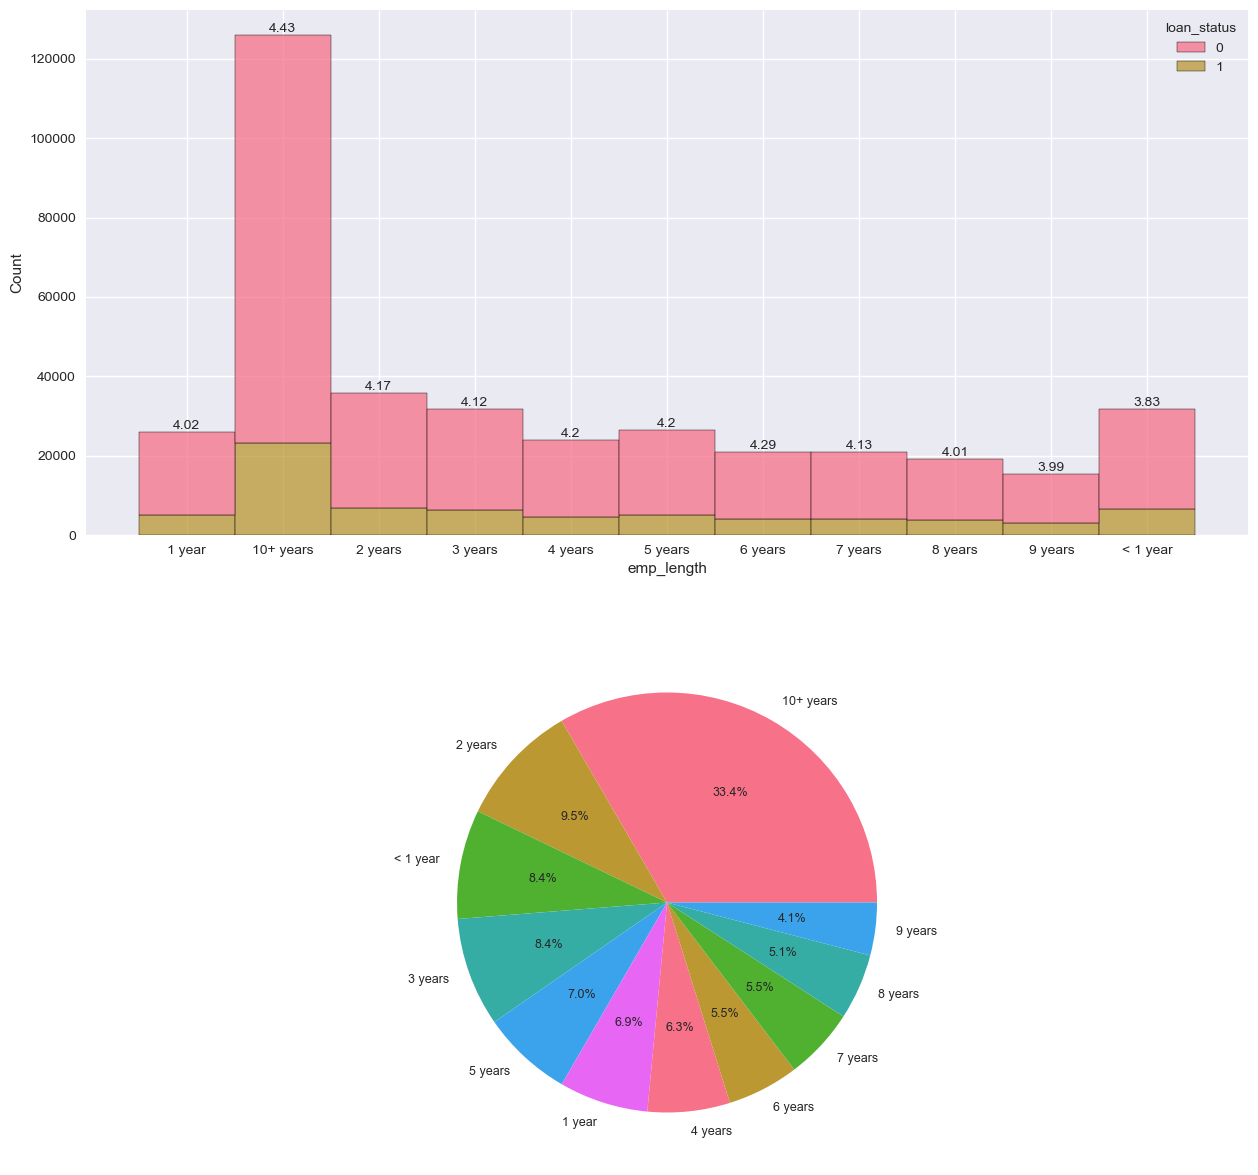

In [74]:
# Visualizing Employee Length distibution

emp_length_num = pd.DataFrame(loan_data['emp_length'])
emp_length_num['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
emp_length_num = emp_length_num.sort_values('emp_length')
fig,ax = plt.subplots(2,1)
fig.set_figheight(15)
fig.set_figwidth(15)

# Histogram with stacked plot for employment length with target vales
sns.histplot(emp_length_num,ax = ax[0],multiple='stack',stat = 'count', x = 'emp_length',element='bars',legend = True,hue = 'loan_status')
# Making labels for loan_status ratio.
labels = [np.round(i[1]/i[0],2) for i in zip(ax[0].containers[0].datavalues,ax[0].containers[1].datavalues)]

rects = ax[0].containers[1].patches
rects2 = ax[0].containers[0].patches
for rect,rect2, label in zip(rects,rects2, labels):
     height = rect.get_height()
     height2 = rect2.get_height()
     ax[0].text(
         rect.get_x() + rect.get_width() / 2, height+height2, label, ha="center", va="bottom"
     )
ax[1].pie( emp_length_num['emp_length'].value_counts(), labels = list(emp_length_num['emp_length'].value_counts().keys()),autopct='%1.1f%%',textprops={'fontsize': 9})
plt.show()


Almost a third of the loanees have employment length 10+ years


In [76]:
# Chi Square test between employee length and loan status
data = pd.crosstab(loan_data['emp_length'].fillna('Missing'), loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')
# Checking association between employee length and loan status
print(association(data,method='cramer'))

p value is 3.0227223993214624e-182
Dependent (reject H0)
0.04721476309542633


Splitting into these bins did not affect the association

In [78]:
# Converting the column to numerical 
def empl_length_num(x):
    if x!=x:
        return -1
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
num_emp_len = pd.DataFrame(loan_data['emp_length'].apply(empl_length_num))
num_emp_len['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})


(array([ 50026.,  25882.,  35827.,  31665.,  23952.,  26495.,  20841.,
         20819.,  19168., 141355.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

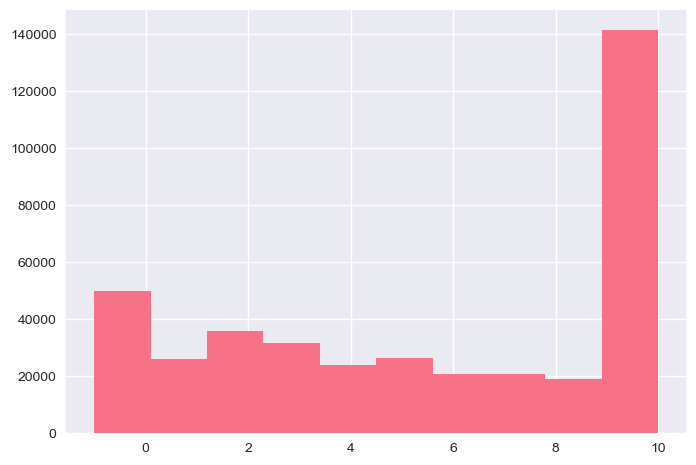

In [79]:
plt.hist(num_emp_len['emp_length'])

The histogram shows a left skewed distribution with the employee lengths between 0 and 9 having similar frequencies.

In [81]:
skew(num_emp_len['emp_length'].dropna())

-0.1923907003859091

In [82]:
# Checking association of Employment Length with Loan status
contingency_table = pd.crosstab(
    num_emp_len['emp_length'],  
    num_emp_len['loan_status'],         
    rownames=['Emp Length'],
    colnames=['Default']
).loc[[-1,0,1,2,3,4,5,6,7,8,9,10]]  # Ensure order is preserved

# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}")
print(f"P-value: {result.pvalue}")
print(contingency_table,'Association : ',association(contingency_table,method='cramer'))


Chi2 Statistic (Trend): 496530.0
P-value: 4.2355355561841825e-74
Default          0      1
Emp Length               
-1           13263   5038
 0           25162   6563
 1           20728   5154
 2           28903   6924
 3           25483   6182
 4           19344   4608
 5           21403   5092
 6           16898   3943
 7           16764   4055
 8           15339   3829
 9           12244   3070
 10         102826  23215 Association :  0.04721476309542633


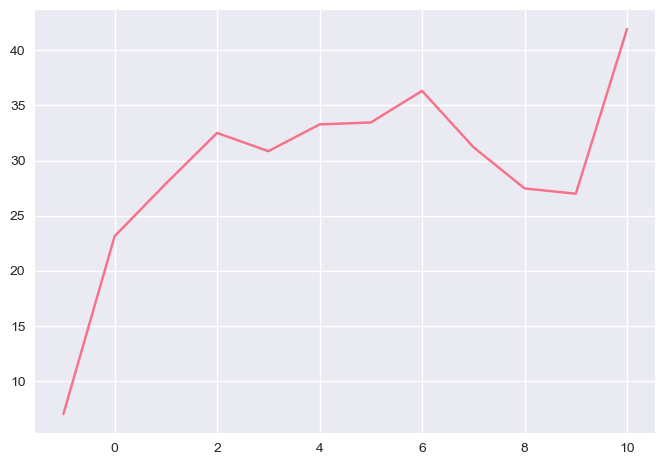

In [83]:
contingency_table['ratio'] = contingency_table[0]/contingency_table[1]
plt.plot(list(contingency_table.index),list(contingency_table['ratio'].apply(lambda x: np.cosh(x))))

In [84]:
contingency_table.reset_index()[['Emp Length','ratio']].corr()

Default     Emp Length     ratio
Default                         
Emp Length    1.000000  0.587313
ratio         0.587313  1.000000

* The default ratio doesnt vary much between 2 and 7 years of employment length
*  The default ratio doesnt vary between 8 and 9 years

In [86]:
# Splitting the employee length into bins based on the above insights
def check(x):
    if x[0] in ['2','3','4','5','6','7']:

        return '2-7 years'
    elif x[0] in ['8','9']:
        return '8-9 years'
    else:
        return x
# Chi Square test between employee length and loan status
data = pd.crosstab(loan_data['emp_length'].fillna('Missing').apply(check), loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')
# Checking association between employee length and loan status

print(data, 'Association : ',association(data,method='cramer'))

p value is 8.025096023197358e-188
Dependent (reject H0)
loan_status  Charged Off  Fully Paid
emp_length                          
1 year              5154       20728
10+ years          23215      102826
2-7 years          30804      128795
8-9 years           6899       27583
< 1 year            6563       25162
Missing             5038       13263 Association :  0.047119974678599914


emp_length
1 year       60000.0
10+ years    70000.0
2 years      60000.0
3 years      60000.0
4 years      61000.0
5 years      61000.0
6 years      62000.0
7 years      63500.0
8 years      65000.0
9 years      65000.0
< 1 year     58000.0
Name: annual_inc, dtype: float64


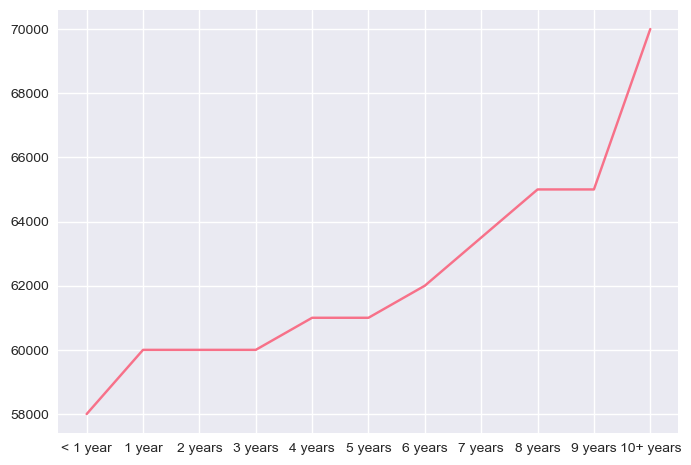

In [87]:
# Plotting Employee length vs Average Annual Income
empl_lengths = [ '< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years', '10+ years']
median_annual_incs = loan_data.groupby('emp_length')['annual_inc'].quantile(0.5)
print(median_annual_incs)
plt.plot(empl_lengths,median_annual_incs[empl_lengths])

Based on this we can see than the median annual income increases with employment length. 

Employment Length column insights
*  The dataset is split unequally across different employment lengths.
*  10+ years has the largest count.
* There is a trend between loan status and employment length when converted to numerical values , which can be converted to ordinal values and used in our model. 
*  As the association between the employment length bins didnt change much we can split the column into '<1 yr','1 yr','2-7 years','8-9 years' and '10+ years'.
*  We can impute missing values in employment length based on annual income.
*  We can apply one hot encoding after converting emp_len into 5 bins

## Employee Title

In [91]:
# Employee Title Distribution
emp_titles = pd.DataFrame(loan_data['emp_title'])
emp_titles['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
len(emp_titles['emp_title'].unique())


173106

There are 173106 unique employee title.

In [93]:
emp_titles_freq = pd.DataFrame(emp_titles['emp_title'].value_counts().sort_values(ascending=False))
emp_titles_freq['default'] = emp_titles.groupby('emp_title')['loan_status'].mean()
emp_titles_freq = emp_titles_freq.reset_index()
print("Most occuring 5 categories\n",emp_titles_freq.head(5))
print("Least occuring 5 categories\n",emp_titles_freq.tail(5))


Most occuring 5 categories
           emp_title  count   default
0           Teacher   4389  0.195261
1           Manager   4250  0.218588
2  Registered Nurse   1856  0.204741
3                RN   1846  0.205309
4        Supervisor   1830  0.221311
Least occuring 5 categories
                            emp_title  count  default
173100  NEW YORK HOSPITAL OF QUEENS       1      1.0
173101      Famous Dave's of America      1      0.0
173102                      Sig LLC       1      0.0
173103          HARVEST PARTNERS, LP      1      0.0
173104          Gracon Services, Inc      1      0.0


the titles are combination of companies , office names, departments and job titles.

In [95]:
emp_titles_freq[['count','default']].corr()

count   default
count    1.000000  0.001763
default  0.001763  1.000000

In [96]:
# Creating a flag for rare columns and applying Chi Square test with loan default
rare_columns = list(emp_titles_freq[emp_titles_freq['count']<=20]['emp_title'])
emp_titles['is_rare'] = emp_titles['emp_title'].isin(rare_columns)
print(emp_titles[emp_titles['is_rare']==1]['loan_status'].mean(),
      emp_titles[emp_titles['is_rare']==0]['loan_status'].mean())

0.18517655999117508 0.2138508220454951


In [97]:
# most common words in loan em_title column

em_title_words_freq = pd.Series(Counter(' '.join(list(loan_data['emp_title'].fillna('missing').apply(lambda x: x.lower()))).split())).sort_values(ascending=False)

# Taking the top 1000 words used in the column and assigning ranks to the em_title column based on the max frequency word used in the row
k = 1000
em_title_word_rank = em_title_words_freq.iloc[:k].reset_index().reset_index().set_index('index')['level_0']
def em_title_check(x):
    z = [em_title_word_rank.get(i,k+1) for i in x.lower().split()]
    return min(z)
loan_em_title_freq_rank = loan_data['emp_title'].fillna('missing').apply(em_title_check)
# Applying chi square test for the word ranks with loan status
data = pd.crosstab(loan_em_title_freq_rank, loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)',association(data,method='cramer'))
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0) 0.12171176790260917


Employee Title column Insights
*  There are large number of categories in Employee Title column with each category count ranging from 1 to 4389
*  Missing values can be replaced with a new term "missing".
*   As categories with very less number of rows they are not significant statistically, so we have to find number of categories of employee title to consider for predicting target
*   Creating a flag only for the rare employee titles (frequency <20) and finding their default rate and comparing with non rare ones default rate, there doesnt seem to much of a difference.
*   The correlation between average loan defaultrate of employee title and frequency of employee title also doesnt seem significant. 
*  Created ranks of words based on the frequency in the column and assigned the rank value of the word with the highest frequency rank in that row. Got a high association with loan status . We can use these ranks in our model.

##  Loan Amount , Interest Rate , Installment , Open Accounts , Total Accounts

In [100]:
# Basic Stats for Loan Amount , Interest Rate , Installment , Open Accounts , Total Accounts
num_columns = ["loan_amnt","int_rate","installment","open_acc","total_acc"]
loan_data[num_columns].describe()

loan_amnt       int_rate    installment       open_acc  \
count  396030.000000  396030.000000  396030.000000  396030.000000   
mean    14113.888089      13.639400     431.849698      11.311153   
std      8357.441341       4.472157     250.727790       5.137649   
min       500.000000       5.320000      16.080000       0.000000   
25%      8000.000000      10.490000     250.330000       8.000000   
50%     12000.000000      13.330000     375.430000      10.000000   
75%     20000.000000      16.490000     567.300000      14.000000   
max     40000.000000      30.990000    1533.810000      90.000000   

           total_acc  
count  396030.000000  
mean       25.414744  
std        11.886991  
min         2.000000  
25%        17.000000  
50%        24.000000  
75%        32.000000  
max       151.000000

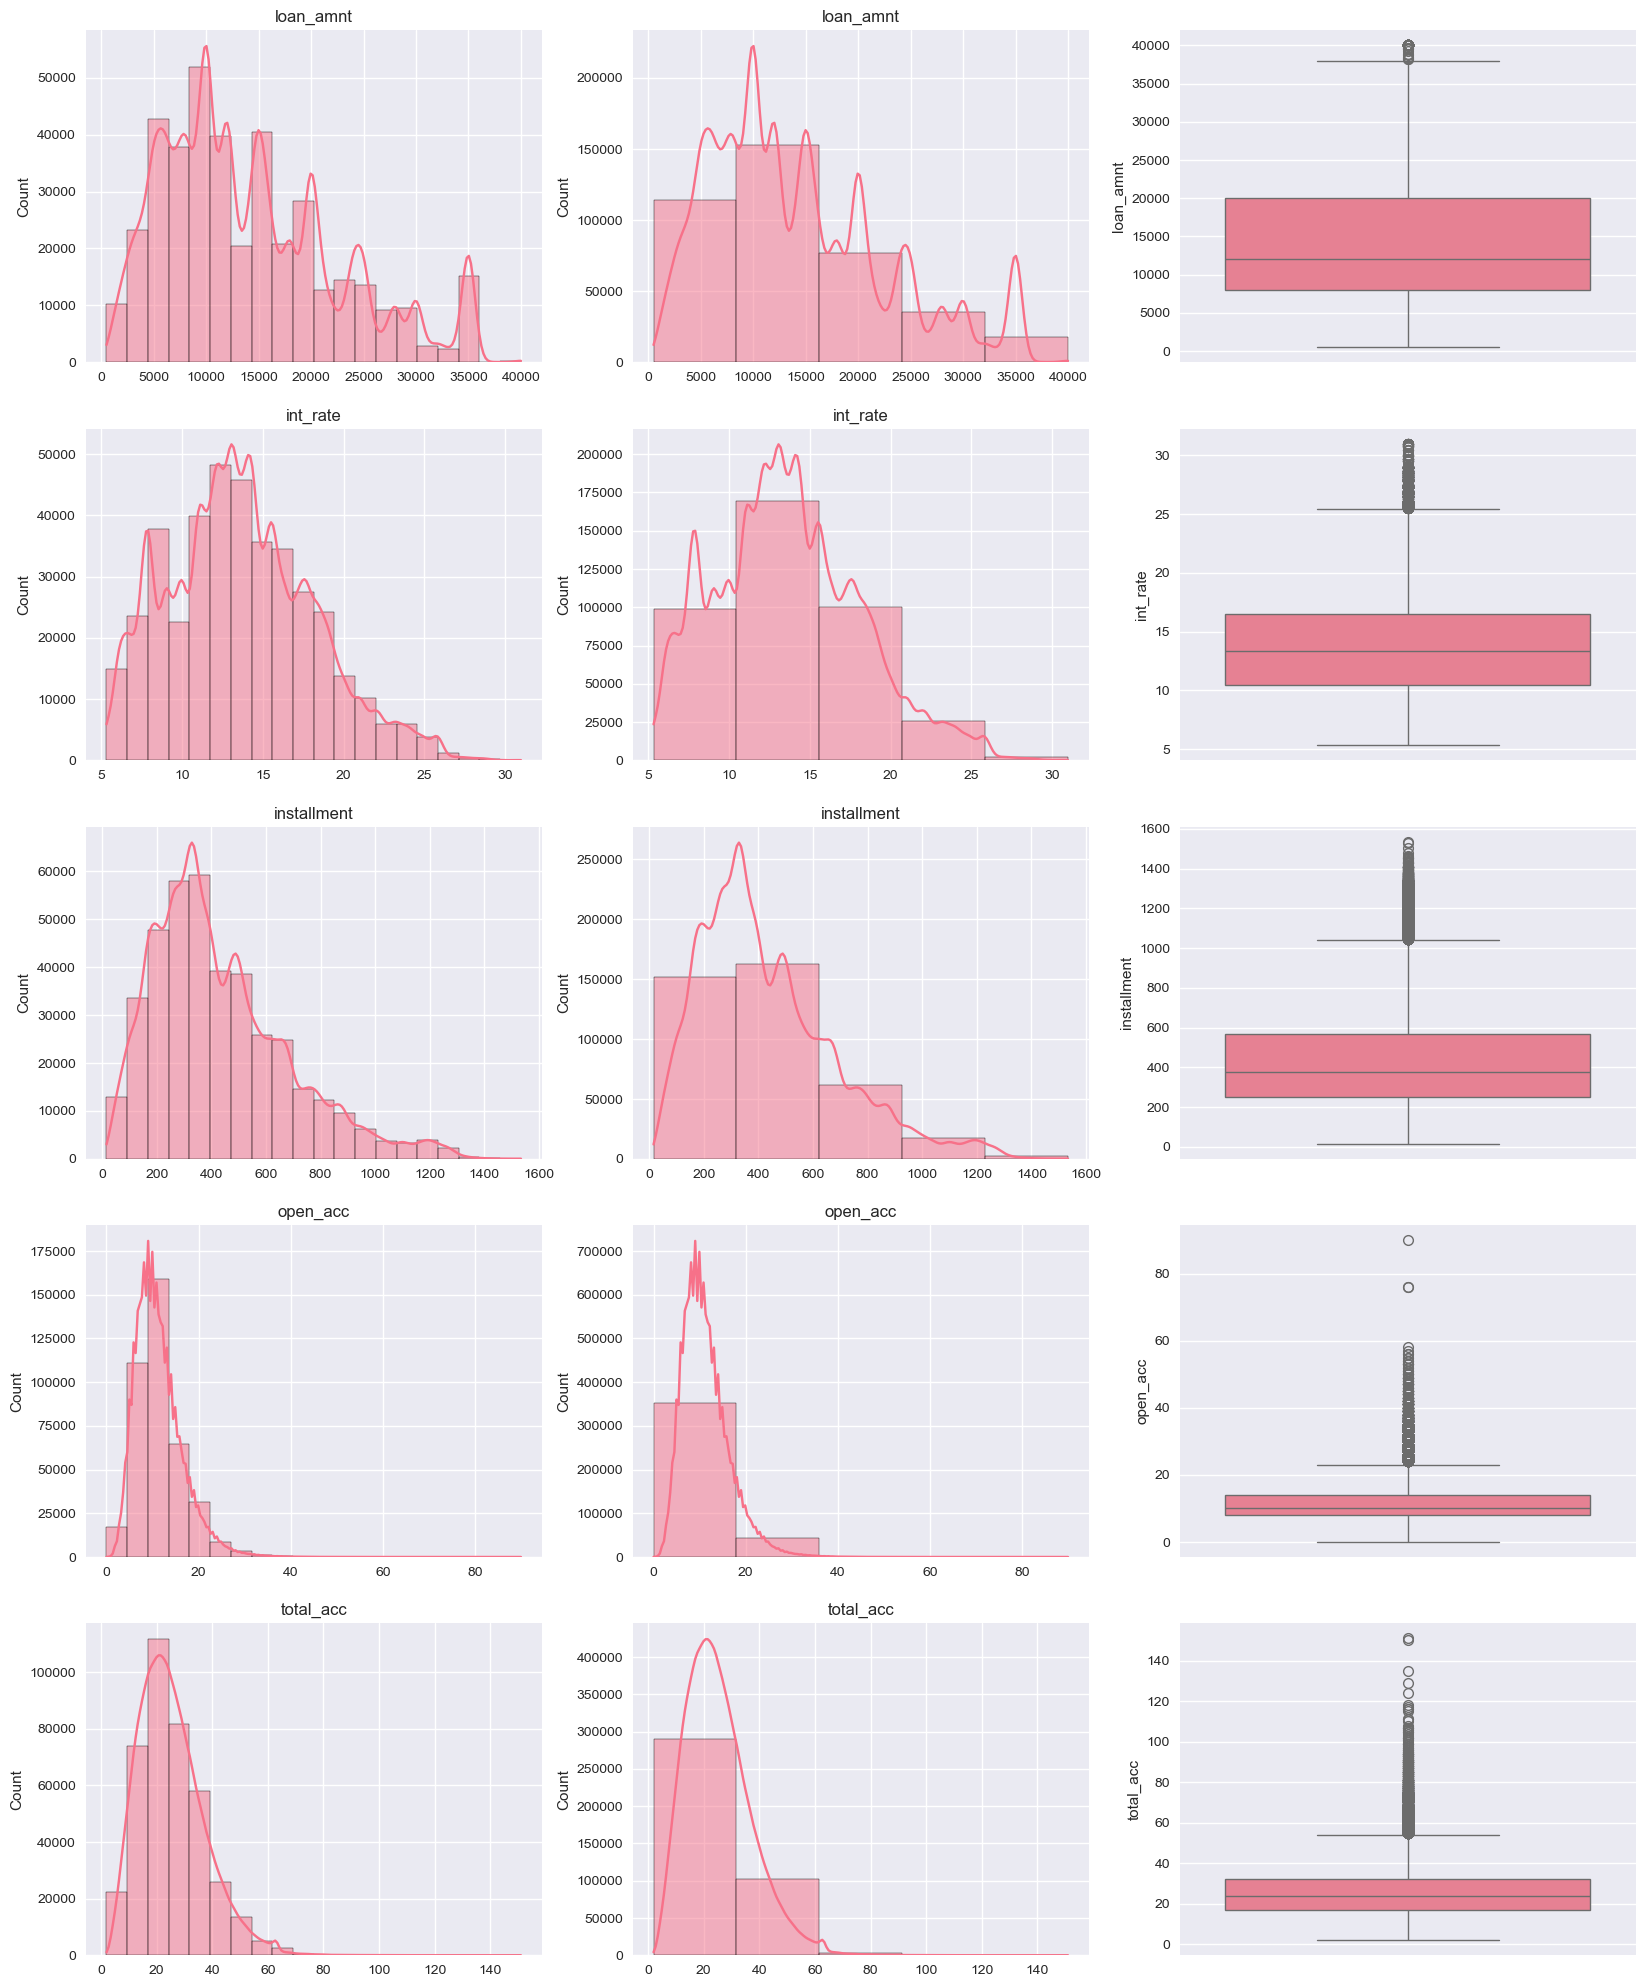

In [101]:
# Box Plot and Distplots for numerical features  "loan_amnt","int_rate","installment","open_acc","total_acc"

fig, ax =plt.subplots(5,3)
fig.set_figheight(25)
fig.set_figwidth(20)
for col in range(len(num_columns)):
    sns.histplot(loan_data[num_columns[col]].rename(''),ax = ax[col][0],kde = True,bins = 20)
    sns.histplot(loan_data[num_columns[col]].rename(''),ax = ax[col][1],kde = True,bins = 5)
    sns.boxplot(loan_data[num_columns[col]], ax = ax[col][2])
    ax[col][0].set_title(num_columns[col])
    ax[col][1].set_title(num_columns[col])

*  Loan Amount is skewed towards the right and has some outliers. Most loan amount is concentrated around 5000 to 25000.
*  Interest rate is also skewed right with many outliers (above 25). Most Interest rates are between 10 and 18
*  Installments which depend on Loan Amount and Interest rate are also skewed to the right and has a lot of outliers. 
*   Open Accounts and Total accounts are also skewed to the right with a bunch out of ouliers above 20 and 50 respectively. 
*  Most open accounts are between 0 and 20 and total accounts are between 0 and 50.

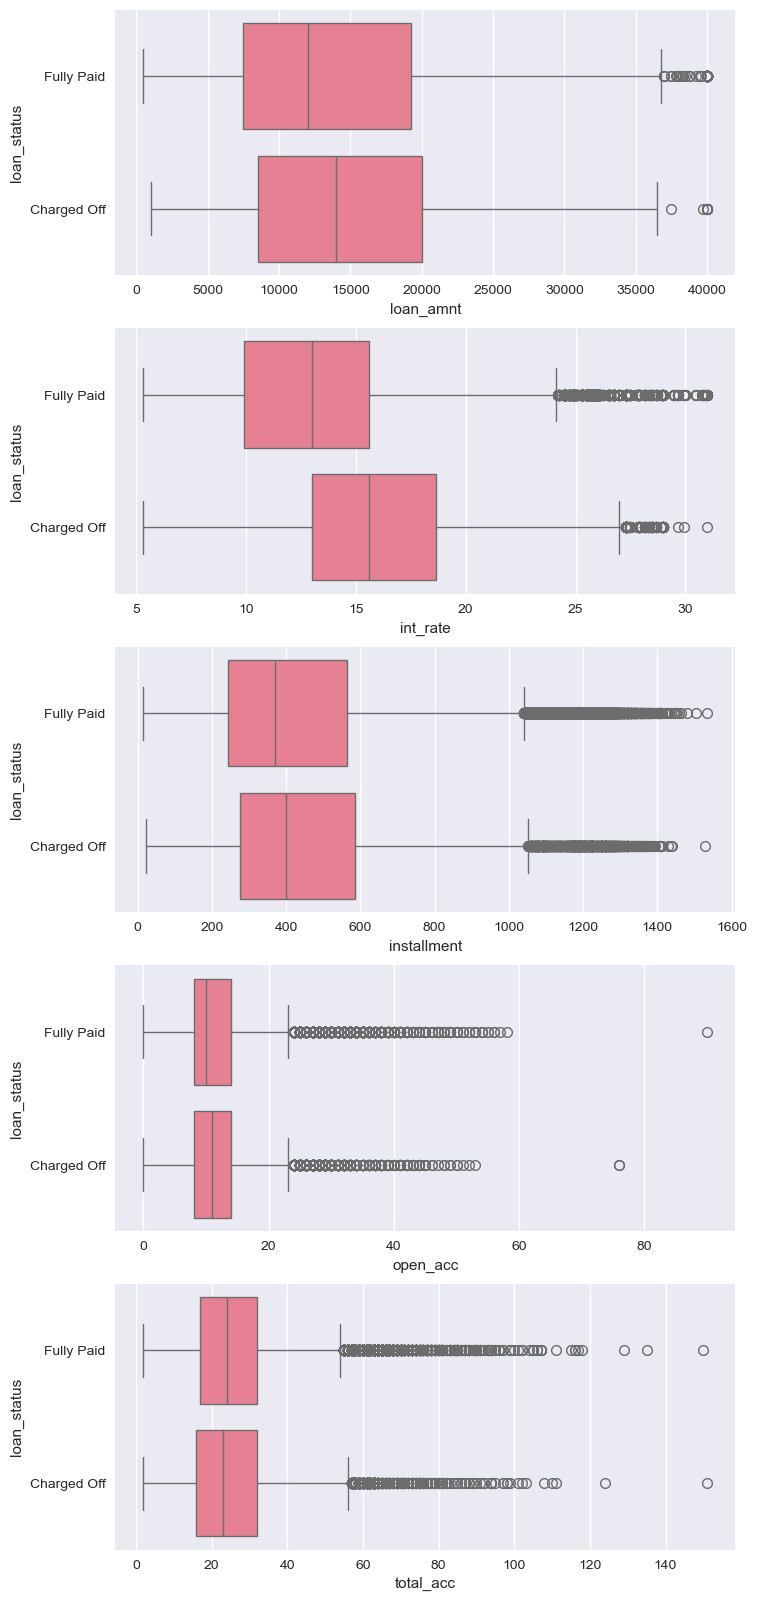

In [103]:
# Numerical Features vs Target Variable (Loan_status)
num_var = ["loan_amnt","int_rate","installment","open_acc","total_acc"]
fig,ax = plt.subplots(5,1)
fig.set_figheight(20)
for i in range(5):
    sns.boxplot(loan_data,x = num_var[i],y= loan_data['loan_status'],ax=ax[i])


Insights about "loan_amnt","int_rate","installment","open_acc","total_acc"
*  Comparing with Loan Status, the defaulted loans have a higher median loan amount (difference of about 2000) and less number of outliers.The less number of outliers in loan amount compared with fully paid loans might be due to less defaulted loan data 
*  . Comparing with Loan Status, the defaulted loans have a higher median interest rate (difference of about 2.5)  and less amount of outliers.The less amount of outliers might be due to less defaulted loan data compared with fully paid loans. 
*  On comparing with Loan status the open accounts in defaulated loans  are distributed very  similiar to fully paid ones. But Fully paid ones seem to have a lot more outliers. 
*  Total accounts on comparing with Loan status the values in defaulated loans  are distributed very  similiar to fully paid ones. But Fully paid ones seem to have a lot more outliers.

In [105]:
# Calculating Skew of "loan_amnt","int_rate","installment","open_acc","total_acc"
for i in ["loan_amnt","int_rate","installment","open_acc","total_acc"]:
    print('Skew of', i,skew(loan_data[i]))

Skew of loan_amnt 0.7772825230545491
Skew of int_rate 0.420667878632277
Skew of installment 0.9835944354181415
Skew of open_acc 1.2130142500334236
Skew of total_acc 0.8643243632191431


In [106]:
# As there seems to be lot of outliers in loan_amnt, looking at the outliers
loan_amnt_median = loan_data['loan_amnt'].quantile(0.5)
loan_amnt_25 = loan_data['loan_amnt'].quantile(0.25)
loan_amnt_75 = loan_data['loan_amnt'].quantile(0.75)
iqr = loan_amnt_75 - loan_amnt_25
outliers = loan_data[(loan_data['loan_amnt']>(iqr*1.5+loan_amnt_75)) | (loan_data['loan_amnt']<(-iqr*1.5+loan_amnt_25))]
outliers.dropna().describe()

loan_amnt    int_rate  installment     annual_inc         dti  \
count    179.000000  179.000000   179.000000     179.000000  179.000000   
mean   39937.569832   12.799385  1179.543575  165676.104693   14.967263   
std      287.892067    5.086161   187.669635   95212.652091    9.707779   
min    38225.000000    5.320000   818.550000   34000.000000    0.120000   
25%    40000.000000    9.160000  1015.520000  105500.000000    8.055000   
50%    40000.000000   11.990000  1242.230000  140000.000000   13.550000   
75%    40000.000000   15.310000  1318.470000  186000.000000   21.330000   
max    40000.000000   29.990000  1533.810000  655000.000000   63.100000   

         open_acc     pub_rec      revol_bal  revol_util   total_acc  \
count  179.000000  179.000000     179.000000  179.000000  179.000000   
mean    13.078212    0.078212   30575.955307   37.164804   31.234637   
std      5.783017    0.358720   32769.937168   27.395783   12.678422   
min      2.000000    0.000000       0.000000    0.000000    8.000000   
25%      9.000000    0.000000    6400.500000   12.550000   22.500000   
50%     12.000000    0.000000   21419.000000   34.400000   30.000000   
75%     16.000000    0.000000   42432.000000   58.100000   39.000000   
max     36.000000    3.000000  235416.000000  100.800000   78.000000   

         mort_acc  pub_rec_bankruptcies  
count  179.000000            179.000000  
mean     3.184358              0.033520  
std      2.254728              0.209318  
min      0.000000              0.000000  
25%      2.000000              0.000000  
50%      3.000000              0.000000  
75%      4.500000              0.000000  
max     10.000000              2.000000

In [107]:
outliers.dropna().describe()/(loan_data.dropna().describe()+1)

loan_amnt  int_rate  installment  annual_inc       dti  open_acc  \
count   0.000533  0.000533     0.000533    0.000533  0.000533  0.000533   
mean    2.749808  0.865080     2.643773    2.185180  0.799569  1.038090   
std     0.034324  0.923884     0.742985    1.536351  1.061210  0.935523   
min    38.186813  0.841772    27.514286    6.798640  0.120000  1.000000   
25%     4.999375  0.786942     3.835335    2.244633  0.637767  1.000000   
50%     3.225546  0.835540     3.191752    2.153813  0.742466  1.000000   
75%     1.999900  0.861080     2.254604    2.066644  0.873464  1.066667   
max     0.999975  0.937480     0.999348    0.075230  0.165387  0.395604   

        pub_rec  revol_bal  revol_util  total_acc  mort_acc  \
count  0.000533   0.000533    0.000533   0.000533  0.000533   
mean   0.066006   1.888103    0.671264   1.162913  1.136173   
std    0.232389   1.561090    1.097471   0.982707  0.718147   
min    0.000000   0.000000    0.000000   2.666667  0.000000   
25%    0.000000   1.015469    0.331135   1.250000  2.000000   
50%    0.000000   1.865604    0.611012   1.200000  1.500000   
75%    0.000000   2.122555    0.785135   1.147059  1.125000   
max    0.034483   0.135043    0.112840   0.513158  0.285714   

       pub_rec_bankruptcies  
count              0.000533  
mean               0.029783  
std                0.153655  
min                0.000000  
25%                0.000000  
50%                0.000000  
75%                0.000000  
max                0.222222

It seems the outliers for loan amount have twice the annual income on average

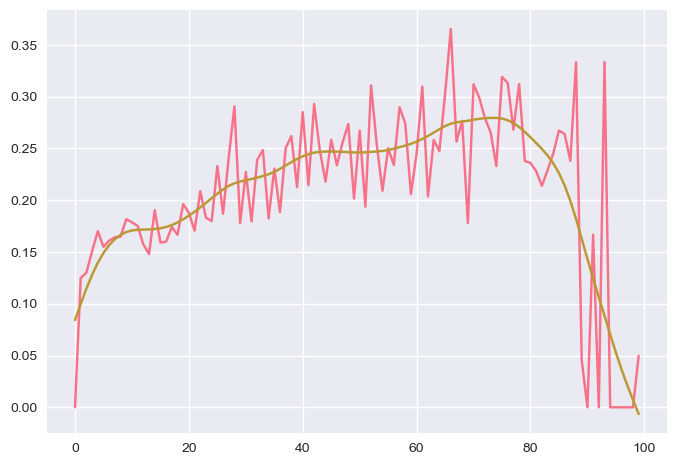

In [109]:
#  Spliting the loan amounts column into 100 bins and plotting average default rate and applying smoothing
loan_amt = pd.DataFrame(loan_data['loan_amnt'])
#loan_amt['loan_amnt_bin'] = pd.qcut(loan_data['loan_amnt'],100,duplicates='drop')
loan_amt['loan_amnt_bin'] = pd.cut(loan_data['loan_amnt'],100)
loan_amt['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
amnt_rate = pd.DataFrame(loan_amt.groupby('loan_amnt_bin',observed=False)['loan_default'].mean())
amnt_rate['count'] = loan_amt.groupby('loan_amnt_bin',observed=False)['loan_default'].count()
plt.plot(amnt_rate['loan_default'].values)
bin_map = {amnt_rate.index[i]:i for i in range(len(amnt_rate.index))}
spl = make_smoothing_spline(list(bin_map.values()),amnt_rate['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


The default rate seems to increase with loan amount with sharp decrease in loan amount around 36000.As high loan amounts indicate lower default rates , outliers of high loan amount values can provide important information.

In [111]:
# Checking association of Loan Amount BInned with Loan status
contingency_table = pd.crosstab(
    loan_amt['loan_amnt_bin'],
    loan_amt['loan_default'],        
    rownames=['loan_amnt'],
    colnames=['Default']
)  # Ensure order is preserved
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 2840557.0 the association strength is 0.08832094495007857
P-value: 0.0


Applying the Cochran Armitage test indicates there is a trend between the binned loan amounts and loan default

In [113]:
# Checking skew after capping loan amount at 38000  (removing outliers)
skew(loan_data['loan_amnt'].clip(upper = 38000))

0.7754171651007664

*  Loan Amount has a right skew, we can try binning the loan amounts.
*  Also we can handle outliers by capping loan amounts at 38000. The skew became more acceptable after applying capping on outliers
*  We can also create interaction features between loan_amnt and annual income as  higher annual incomes indicate lower chance of default for similar loan amonuts

<Axes: xlabel='loan_amnt', ylabel='annual_inc'>

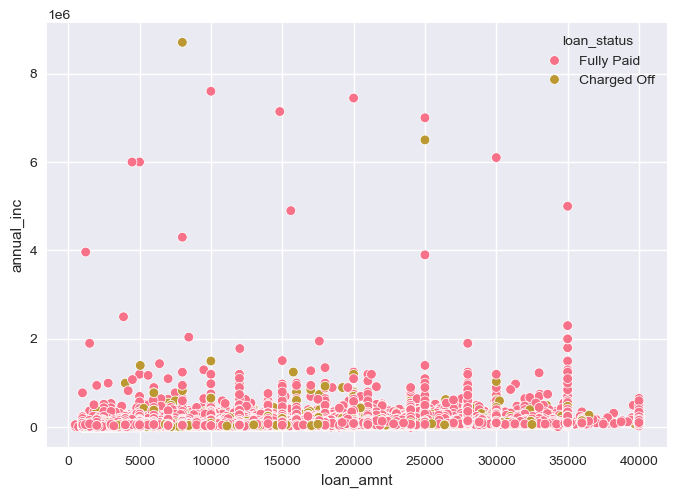

In [115]:
# As the Loan AMount seem to be higher for higher annual incomes, plotting Loan AMount vs Annual Income

sns.scatterplot(data=loan_data, y = 'annual_inc' , x = 'loan_amnt',hue = 'loan_status',)

The columns of annual income indicate specific loan amounts being given to multiple loanees.
Also most of the points have annual_inc  <500000

<Axes: xlabel='loan_amnt', ylabel='annual_inc'>

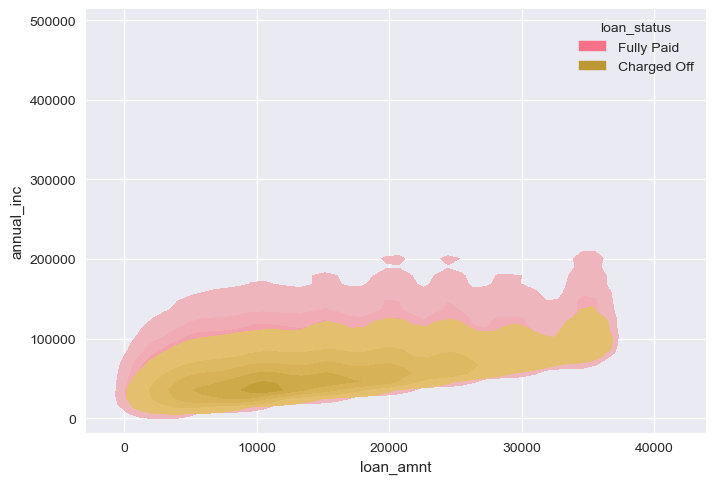

In [117]:
# Contour plot between annual inc, loan amount and loan status
sns.kdeplot(data=loan_data[loan_data['annual_inc']<500000], y = 'annual_inc' , x = 'loan_amnt',hue = 'loan_status',fill=True,gridsize=50)

For similar loan amounts , higher annual incomes indicate lower chance of default.
We can use ratio of Annual Income to Loan Amount in our model

## Interest Rate

In [120]:
# As there seems to be lot of outliers in int_rate, looking at the outliers
int_rate_median = loan_data['int_rate'].quantile(0.5)
int_rate_25 = loan_data['int_rate'].quantile(0.25)
int_rate_75 = loan_data['int_rate'].quantile(0.75)
iqr = int_rate_75 - int_rate_25
outliers = loan_data[(loan_data['int_rate']>(iqr*1.5+int_rate_75)) | (loan_data['int_rate']<(-iqr*1.5+int_rate_25))]


In [121]:
outliers['int_rate'].describe()

count    3777.000000
mean       26.366622
std         1.064983
min        25.490000
25%        25.800000
50%        25.880000
75%        26.770000
max        30.990000
Name: int_rate, dtype: float64

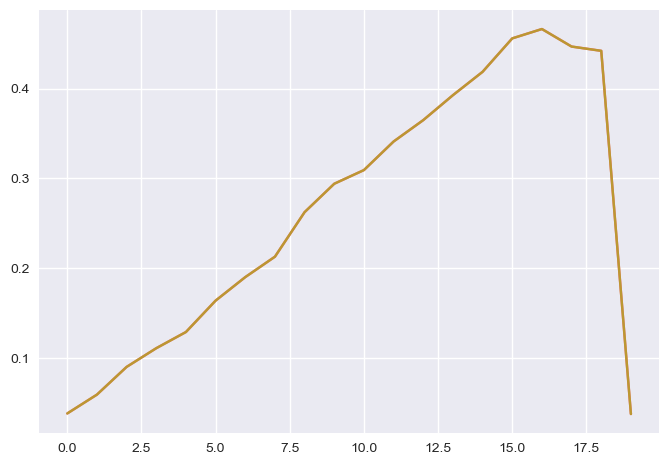

In [122]:
#  Spliting the int_rate column into 100 bins and plotting average default rate and applying smoothing
int_rate = pd.DataFrame(loan_data['int_rate'])

int_rate['int_rate_bin'] = pd.cut(loan_data['int_rate'],20)
int_rate['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
int_default = pd.DataFrame(int_rate.groupby('int_rate_bin',observed=False)['loan_default'].mean())
int_default['count'] = int_rate.groupby('int_rate_bin',observed=False)['loan_default'].count()
plt.plot(int_default['loan_default'].values)
bin_map = {int_default.index[i]:i for i in range(len(int_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),int_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


The default rates increase with increasing interest rates but drops suddenly at very high interest rates (outliers)

In [124]:
# Checking association of  BInned interest rates with Loan status
contingency_table = pd.crosstab(
    int_rate['int_rate_bin'],
    int_rate['loan_default'],        
    rownames=['int_rate'],
    colnames=['Default']
)  # Ensure order is preserved
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 602833.0 the association strength is 0.24850035232472031
P-value: 0.0


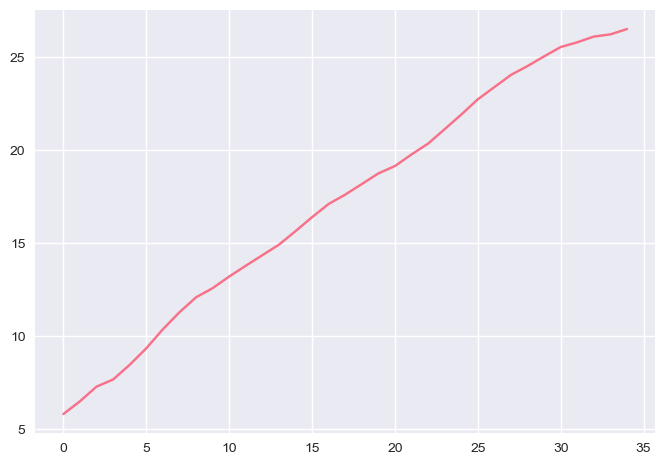

In [125]:
# As interest rate may be applied based on sub grades or grades . Plotting average interest rate vs sub grade

sub_grade_int_rate = pd.DataFrame(loan_data.groupby('sub_grade')['int_rate'].mean()).reset_index()
plt.plot(sub_grade_int_rate['int_rate'])

Plotting average interest rate across sub grades shows a linear trend

In [127]:
sub_grade_int_rate['int_rate'].corr(other = pd.Series(sub_grade_int_rate.index))

0.9970004613182664

* The interest rate has some right skew but the outliers are important for prediction and should be included.
* The interest rate binned has moderate association with target. 
* The interest rates are highly correlated with the sub grades. 
* We can remove sub grades for prediction and use int_rate as is.

## Installment

In [130]:
# As there seems to be lot of outliers in installment, looking at the outliers
installment_median = loan_data['installment'].quantile(0.5)
installment_25 = loan_data['installment'].quantile(0.25)
installment_75 = loan_data['installment'].quantile(0.75)
iqr = installment_75 - installment_25
outliers = loan_data[(loan_data['installment']>(iqr*1.5+installment_75)) | (loan_data['installment']<(-iqr*1.5+installment_25))]


In [131]:
outliers['installment'].describe()

count    11250.000000
mean      1171.607139
std         78.271912
min       1043.200000
25%       1103.330000
50%       1172.390000
75%       1224.287500
max       1533.810000
Name: installment, dtype: float64

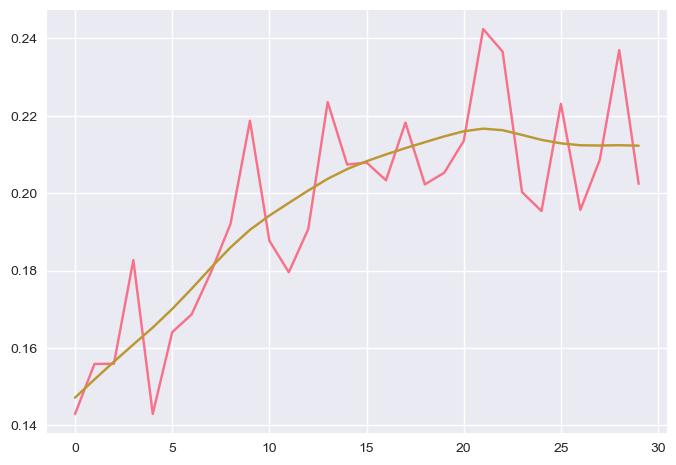

In [132]:
#  Spliting the installments column into 30 bins and plotting average default rate and applying smoothing
installment = pd.DataFrame(loan_data['installment'])
installment['installment_bin'] = pd.qcut(loan_data['installment'],30,duplicates='drop')

installment['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
installment_default = pd.DataFrame(installment.groupby('installment_bin',observed= False)['loan_default'].mean())
installment_default['count'] = installment.groupby('installment_bin',observed=False)['loan_default'].count()
plt.plot(installment_default['loan_default'].values)
bin_map = {installment_default.index[i]:i for i in range(len(installment_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),installment_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


The default rate increases with increase in installment amount

In [134]:
# Checking association of BInned installments with Loan status
contingency_table = pd.crosstab(
    installment['installment_bin'],
    installment['loan_default'],        
    rownames=['installment'],
    colnames=['Default']
)  # Ensure order is preserved
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 1193284.0 the association strength is 0.06567586898868195
P-value: 1.8733435771110048e-212


In [135]:
# Correlation between loan_amnt, int rate, installment, loan term
loan_main = loan_data.loc[:,["loan_amnt","int_rate","installment"]]
loan_main['loan_term'] = loan_data['term'].apply(lambda x: int(x[1:3]))
loan_main.corr()

loan_amnt  int_rate  installment  loan_term
loan_amnt     1.000000  0.168921     0.953929   0.393862
int_rate      0.168921  1.000000     0.162758   0.434594
installment   0.953929  0.162758     1.000000   0.153378
loan_term     0.393862  0.434594     0.153378   1.000000

*  There is high correlation between loan amount and installment
*  As Installment is a function of interest rate, loan amount and loan term , we can remove it for prediction as it may cause multicollinearity.

*   Although the median installment is higher for defaulted loans.

## Open Accounts

In [138]:
# As there seems to be lot of outliers in open_acc, looking at the outliers
open_acc_median = loan_data['open_acc'].quantile(0.5)
open_acc_25 = loan_data['open_acc'].quantile(0.25)
open_acc_75 = loan_data['open_acc'].quantile(0.75)
iqr = open_acc_75 - open_acc_25
outliers = loan_data[(loan_data['open_acc']>(iqr*1.5+open_acc_75)) | (loan_data['open_acc']<(-iqr*1.5+open_acc_25))]


In [139]:
outliers['open_acc'].describe()

count    10307.000000
mean        27.697002
std          4.427048
min         24.000000
25%         25.000000
50%         26.000000
75%         29.000000
max         90.000000
Name: open_acc, dtype: float64

In [140]:
# Calculating skew after capping open_acc at 23 (min outlier - 1 )
skew(loan_data['open_acc'].clip(upper=23))

0.6515433052984948

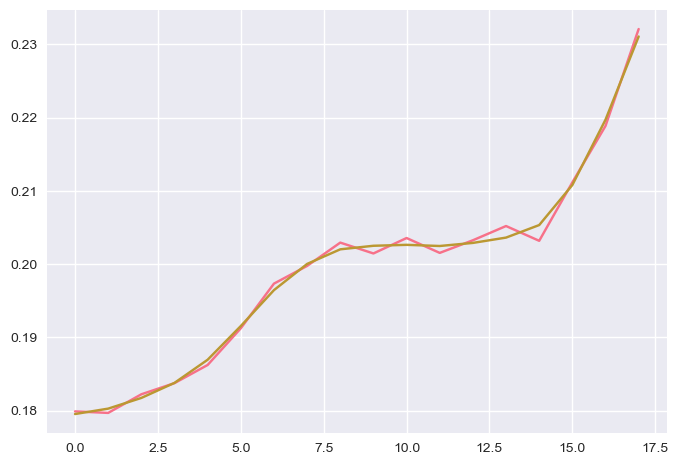

In [141]:
#  Spliting the open_acc column into 30 bins and plotting average default rate and applying smoothing
open_acc = pd.DataFrame(loan_data['open_acc'])
open_acc['open_acc_bin'] = pd.qcut(loan_data['open_acc'],30,duplicates='drop')

open_acc['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
open_acc_default = pd.DataFrame(open_acc.groupby('open_acc_bin',observed=False)['loan_default'].mean())
open_acc_default['count'] = open_acc.groupby('open_acc_bin',observed=False)['loan_default'].count()
plt.plot(open_acc_default['loan_default'].values)
bin_map = {open_acc_default.index[i]:i for i in range(len(open_acc_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),open_acc_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))

Plotting binned open acoounts with loan default ratio shows three smaller trends (0 - 7.5,7.5-13,13-17.5)

In [143]:
# Checking association of  BInned open accounts with Loan status
contingency_table = pd.crosstab(
    open_acc['open_acc_bin'],
    loan_data['loan_status'] ,     
    rownames=['Open Accounts'],
    colnames=['Default']
)  # Ensure order is preserved
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 2237880.0 the association strength is 0.028895965836756878
P-value: 5.127144565786297e-66


## Total Accounts

In [145]:
# As there seems to be lot of outliers in total_acc, looking at the outliers
total_acc_median = loan_data['total_acc'].quantile(0.5)
total_acc_25 = loan_data['total_acc'].quantile(0.25)
total_acc_75 = loan_data['total_acc'].quantile(0.75)
iqr = total_acc_75 - total_acc_25
outliers = loan_data[(loan_data['total_acc']>(iqr*1.5+total_acc_75)) | (loan_data['total_acc']<(-iqr*1.5+total_acc_25))]


In [146]:
outliers['total_acc'].describe()

count    8499.000000
mean       61.697847
std         7.464485
min        55.000000
25%        57.000000
50%        60.000000
75%        63.000000
max       151.000000
Name: total_acc, dtype: float64

In [147]:
# Calculating skew after capping total_acc at 54 (min outlier - 1 )
skew(loan_data['total_acc'].clip(upper=54))

0.5682356886804083

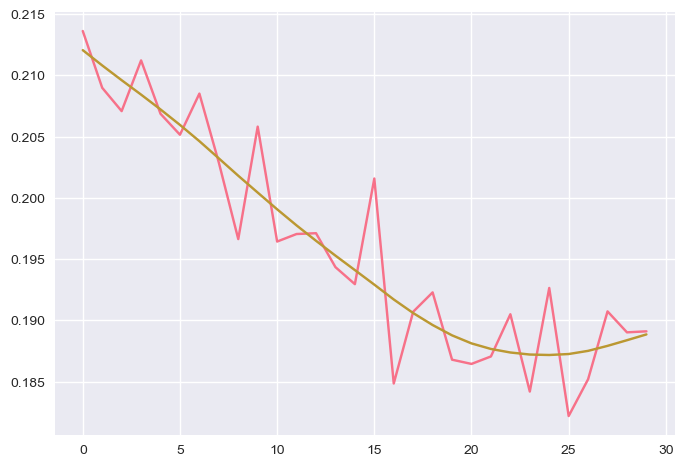

In [148]:
#  Spliting the total_acc column into 30 bins and plotting average default rate and applying smoothing
total_acc = pd.DataFrame(loan_data['total_acc'])
total_acc['total_acc_bin'] = pd.qcut(loan_data['total_acc'],30,duplicates='drop')

total_acc['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
total_acc_default = pd.DataFrame(total_acc.groupby('total_acc_bin',observed=False)['loan_default'].mean())
total_acc_default['count'] = total_acc.groupby('total_acc_bin',observed=False)['loan_default'].count()
plt.plot(total_acc_default['loan_default'].values)
bin_map = {total_acc_default.index[i]:i for i in range(len(total_acc_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),total_acc_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


There is a downward trend between loan default ratio and binned total accounts but there is a lot of fluctuations

In [150]:
# Checking association of BInne total_acc with Loan status
contingency_table = pd.crosstab(
    total_acc['total_acc_bin'],
    loan_data['loan_status'] ,     
    rownames=['Total Accounts'],
    colnames=['Default']
)  # Ensure order is preserved
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 4512805.0 the association strength is 0.023068023194505214
P-value: 2.2275871307229367e-38


In [151]:
# Checking association of plain total_acc with Loan status
contingency_table = pd.crosstab(
    loan_data['total_acc'],
    loan_data['loan_status'] ,     
    rownames=['Total Accounts'],
    colnames=['Default']
)  # Ensure order is preserved
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")

Chi2 Statistic (Trend): 7487929.0 the association strength is 0.028158497654313025
P-value: 9.858918016010627e-29


We can cap the outliers for open_acc and total_acc (open_acc ~ 23 and total ~ 54) to reduce the skew and handle outliers at the same time

<Axes: xlabel='total_acc', ylabel='open_acc'>

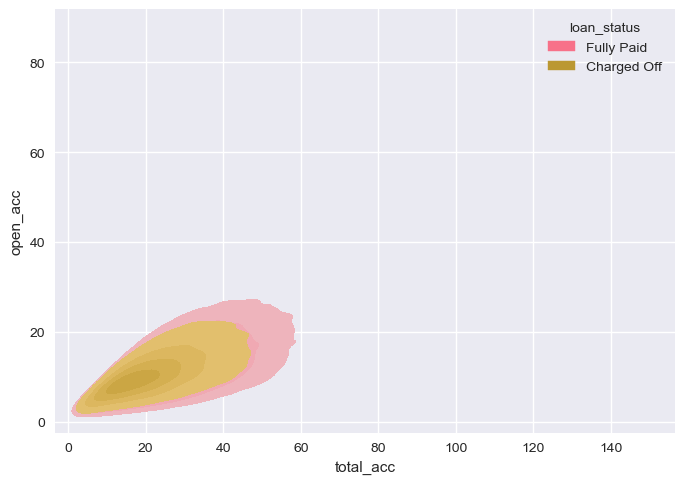

In [153]:
# plotting contour plot between open accounts and total accounts divided between defaulted and non defaulted loans
sns.kdeplot(data=loan_data, y = 'open_acc' , x = 'total_acc',hue = 'loan_status',fill=True)

As the fully paid loans are away from the middle , total_acc ~ 20, open_acc~10. And the charged off loans are concentrated around the middle.

Interaction features between open accounts and total accounts like (open_acc/total_acc) can help create better features for prediction

## Loan Purpose

Unique categories: 14
Frequency of categories in purpose                     loan_status   count
loan_purpose                           
debt_consolidation     0.207414  234507
credit_card            0.167118   83019
home_improvement       0.170079   24030
other                  0.212178   21185
major_purchase         0.164733    8790
small_business         0.294510    5701
car                    0.134767    4697
medical                0.217112    4196
moving                 0.234758    2854
vacation               0.189233    2452
house                  0.197183    2201
wedding                0.120861    1812
renewable_energy       0.234043     329
educational            0.163424     257


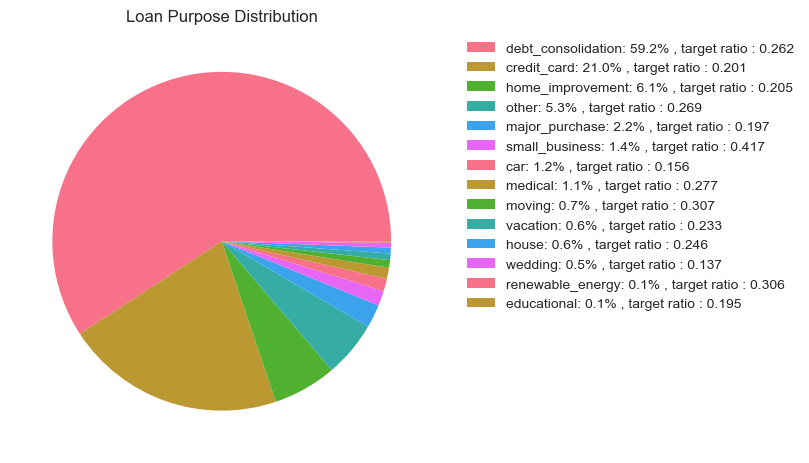

In [157]:
# Loan Purpose Distribution
print("Unique categories:",loan_data['purpose'].nunique())
loan_purp = pd.DataFrame(loan_data['purpose']).rename(columns={'purpose':'loan_purpose'})
loan_purp['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
# Frequency for each category
loan_purp_freq= pd.DataFrame(loan_purp.groupby('loan_purpose')['loan_status'].mean())
loan_purp_freq['count'] = loan_purp['loan_purpose'].value_counts()

loan_purp_freq =  loan_purp_freq.sort_values(by = 'count',ascending=False)
print("Frequency of categories in purpose",loan_purp_freq)
plt.pie(loan_purp_freq['count'],labels= None)
labels = [(i[0] +': '+ str(round(i[2]*100/len(loan_data),1)) + '% , target ratio : ' + str(round(i[1]/(1-i[1]),3) )) for i in loan_purp_freq.reset_index().values]
plt.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Loan Purpose Distribution')
plt.show()

Loans for Weddings , major purchases, cars, education , home improvement and credit cards seem to have the least default rate as its mostly family loans which can be reliable.
Small businessses have the highest default rates as they can be very uncertain.
Renewable energy , moving , medical , house , vacation , debt consolidation and other loans have similar default rates

In [159]:
# Chi square test on Loan Purpose 
data = pd.crosstab(loan_data['purpose'], loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p),end = ' ')
if p <= alpha:
    print('Dependent (reject H0). The association strength is',association(data,method = 'cramer'))
else:
    print('Independent (H0 holds true)')

p value is 6.573354783158025e-291 Dependent (reject H0). The association strength is 0.05939429388201068


In [160]:
purpose = loan_data['purpose'].apply(lambda x : 'family' if x in ['credit_card','home_improvement','major_purchase','educational','wedding','car','vacation','house'] else ('other' if x!='small_business' else 'small_business'))
# Chi square test on Loan Purpose 
data = pd.crosstab(purpose, loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)
print(data)
# interpret p-value
alpha = 0.05
print("p value is " + str(p),end = ' ')
if p <= alpha:
    print('Dependent (reject H0). The association strength is',association(data,method = 'cramer'))
else:
    print('Independent (H0 holds true)')

loan_status     Charged Off  Fully Paid
purpose                                
family                21201      106057
other                 54793      208278
small_business         1679        4022
p value is 4.391923084302833e-283 Dependent (reject H0). The association strength is 0.057300491119041556


Loan Purpose Insights
*  Loan Purpose has 14 categories with varying fully paid to default ratio.
*  The association with loan status didnt change much after grouping purpose into family ,small business and others.

## Annual Income

<Axes: ylabel='annual_inc'>

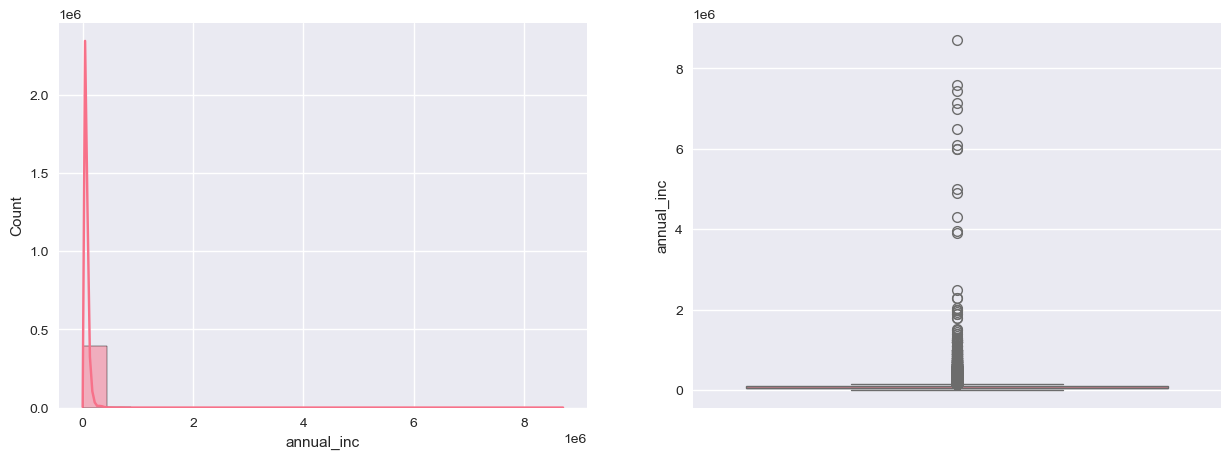

In [163]:
# For Annual Income. Plotting Histogram and boxplot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['annual_inc'],kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['annual_inc'],ax=axes[1])


Annual income seems to have lot of outliers skewing the distribution to the right

In [165]:
# Calculating skew of annual income
skew(loan_data['annual_inc'])

41.0425692933074

In [166]:
# As there seems to be lot of outliers in annual_inc, looking at the outliers
annual_inc_median = loan_data['annual_inc'].quantile(0.5)
annual_inc_25 = loan_data['annual_inc'].quantile(0.25)
annual_inc_75 = loan_data['annual_inc'].quantile(0.75)
iqr = annual_inc_75 - annual_inc_25
outliers = loan_data[(loan_data['annual_inc']>(iqr*1.5+annual_inc_75)) | (loan_data['annual_inc']<(-iqr*1.5+annual_inc_25))]
outliers.describe()

loan_amnt      int_rate   installment    annual_inc           dti  \
count  16700.000000  16700.000000  16700.000000  1.670000e+04  16700.000000   
mean   22980.696108     12.936984    702.376161  2.337100e+05     11.923444   
std     9552.255633      4.809397    309.150747  2.083645e+05      6.617144   
min     1000.000000      5.320000     30.440000  1.575280e+05      0.000000   
25%    15000.000000      8.900000    467.197500  1.750000e+05      7.090000   
50%    24000.000000     12.490000    692.780000  1.993500e+05     11.100000   
75%    32000.000000     16.200000    918.422500  2.450000e+05     15.860000   
max    40000.000000     30.990000   1533.810000  8.706582e+06     42.150000   

           open_acc       pub_rec     revol_bal    revol_util     total_acc  \
count  16700.000000  16700.000000  1.670000e+04  16672.000000  16700.000000   
mean      13.199341      0.163593  4.098839e+04     55.365281     31.716647   
std        5.784601      0.612907  6.237909e+04     26.297874     12.936687   
min        1.000000      0.000000  0.000000e+00      0.000000      2.000000   
25%        9.000000      0.000000  1.188925e+04     36.200000     23.000000   
50%       12.000000      0.000000  2.503050e+04     57.800000     30.000000   
75%       16.000000      0.000000  4.437575e+04     76.800000     39.250000   
max       58.000000     13.000000  1.743266e+06    153.000000    151.000000   

           mort_acc  pub_rec_bankruptcies  
count  15373.000000          16677.000000  
mean       3.428348              0.057444  
std        2.820485              0.252710  
min        0.000000              0.000000  
25%        1.000000              0.000000  
50%        3.000000              0.000000  
75%        5.000000              0.000000  
max       34.000000              5.000000

In [167]:
outliers.describe().loc['min','annual_inc']

157528.0

In [168]:
# Calculating skew after capping annual income at 150000 ( below min of outliers)
skew(loan_data['annual_inc'].clip(upper = 150000))

0.8089488528407816

<Axes: ylabel='annual_inc'>

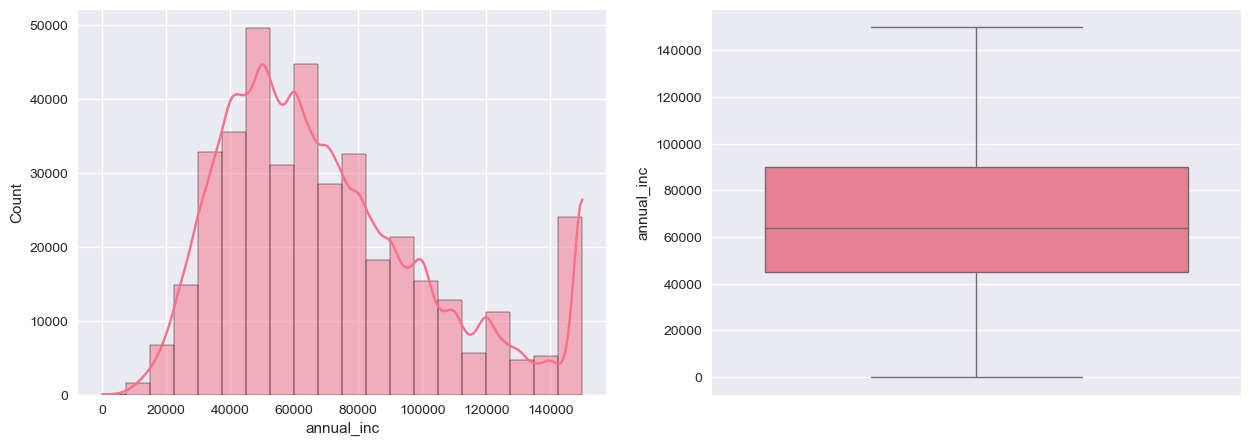

In [169]:
# For Annual Income after capping. Plotting Histogram and boxplot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
ann_inc_transformed = loan_data['annual_inc'].clip(upper = 150000)
sns.histplot(ann_inc_transformed,kde = True, bins = 20,ax = axes[0])
sns.boxplot(ann_inc_transformed,ax=axes[1])


After capping outliers , we can see that most annual incomes lie between 30000 and 100000

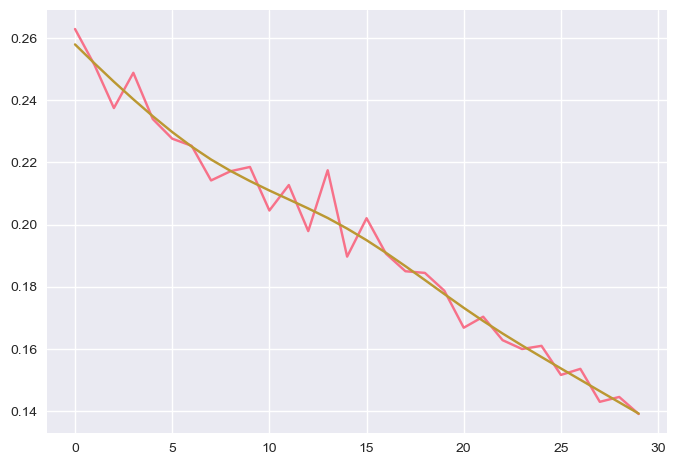

In [171]:
#  Spliting the annual income column into 30bins and plotting average default rate and applying smoothing
annual_inc = pd.DataFrame(loan_data['annual_inc'])
annual_inc['annual_inc_bin'] = pd.qcut(loan_data['annual_inc'],30,duplicates='drop')
#annual_inc['annual_inc_bin'] = pd.cut(loan_data['annual_inc'],20)
annual_inc['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
annual_inc_default = pd.DataFrame(annual_inc.groupby('annual_inc_bin',observed=False)['loan_default'].mean())
annual_inc_default['count'] = annual_inc.groupby('annual_inc_bin',observed=False)['loan_default'].count()
plt.plot(annual_inc_default['loan_default'].values)
bin_map = {annual_inc_default.index[i]:i for i in range(len(annual_inc_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),annual_inc_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


The loan default rate seems to decrease with annual income bin

In [173]:
annual_inc['nbin'] = annual_inc['annual_inc_bin'].apply(lambda x: bin_map[x])
annual_inc[['nbin','loan_default']].corr()

nbin  loan_default
nbin          1.000000     -0.086357
loan_default -0.086357      1.000000

In [174]:
# Checking association of  BInned annual income with Loan status
contingency_table = pd.crosstab(
    annual_inc['annual_inc_bin'],
    annual_inc['loan_default'],        
    rownames=['Annual Income'],
    colnames=['Default']
)  # Ensure order is preserved
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 993480.0 the association strength is 0.0875925335089862
P-value: 0.0


Annual Income Insights
*  Annual income varies from 0 to 1000000 and most values lie between 34000 to 97000.
*  As there are lot of outliers ,capping the outliers at 150000 and found that skew has reduced to acceptable values.
*  Converted the column into a categorical column with quartile binning of the annual income values.
* Target ratio of full paid to defaulted loans increases with higher annual income
*   We can use this ordinal transformation or  capping outliers at 150000.

## Loan Issue Date

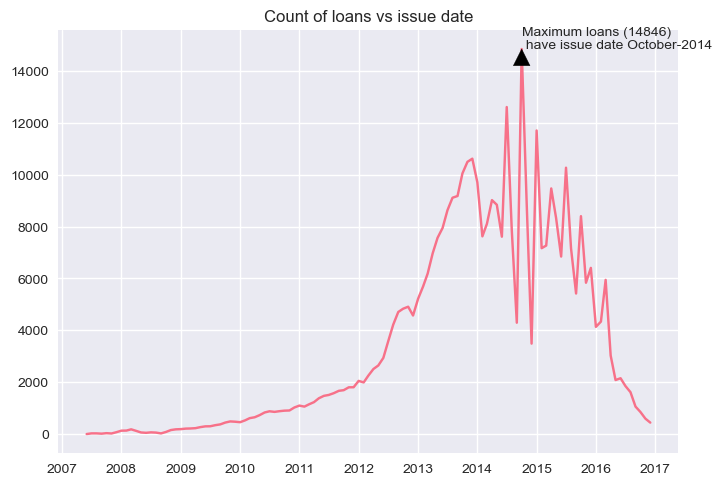

In [177]:
# Visualizing issue date , Plotting No of loans with issue dates
issue_date = pd.to_datetime(loan_data['issue_d'],format = '%b-%Y')
plt.plot(issue_date.value_counts().sort_index())
plt.title('Count of loans vs issue date')
max_value = issue_date.value_counts().max()
max_date = issue_date.value_counts().idxmax()
plt.annotate(f'Maximum loans ({max_value})\n have issue date {max_date.month_name()}-{max_date.year}', xy=(max_date, max_value),
             xytext=(max_date, max_value + 5),
             arrowprops=dict(facecolor='black'))
plt.show()

The Number of loans issued increased from 0 in year 2007 to reaching maximum at around 14000 in the yeaR 2015 decreasing again.

<Axes: xlabel='issue_d'>

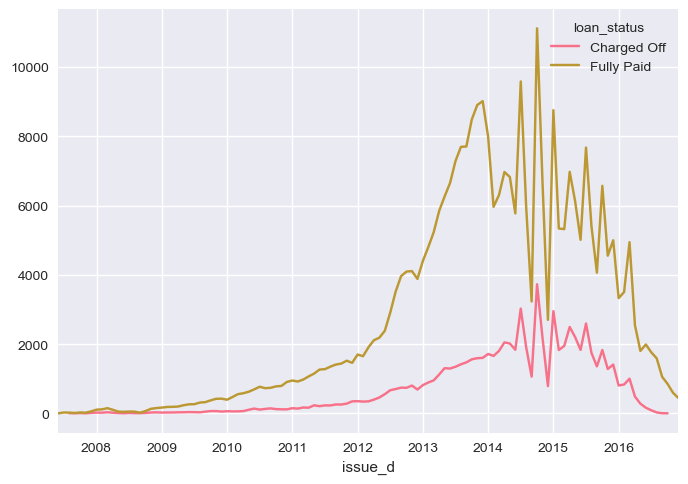

In [179]:
# Plotting loan status numbers with issue date
issue_date  = pd.DataFrame(issue_date)
issue_date['loan_status'] = loan_data['loan_status']
freq = issue_date.groupby([issue_date['issue_d'].dt.to_period('M'),'loan_status'])['loan_status'].count()
freq.unstack().plot()

Between 2007 and 2014 both defaulted and non defaulted loans have increased with the defaulted loans increasing at a lower rate compared to non defaulted loans.


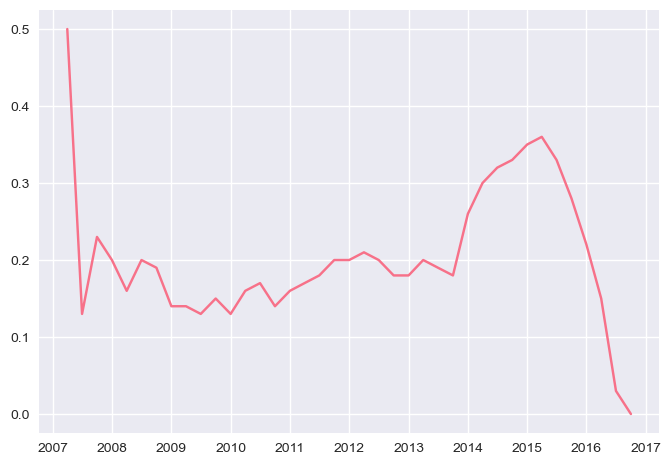

In [181]:
# Plotting Fully paid to Charged off ratio with Quarters of issue date
freq_quarter = issue_date.groupby([issue_date['issue_d'].dt.to_period('Q'),'loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_quarter.index.levels[0].to_timestamp(),[round(freq_quarter[i].get('Charged Off',1)/(freq_quarter[i].get('Fully Paid')+1 ),2) for i in freq_quarter.index.levels[0]])

The loan default ratio for each quarter  between 2007 and 2014 fluctuates between 0.1 and 0.25 with minimum rate around 2010. After 2014 there is a high increase in default rate followed by a decrease after 2015

In [183]:
# Checking association of BInned Issue date Quarter with Loan status
contingency_table = pd.crosstab(
    issue_date['issue_d'].dt.to_period('Q'),
    loan_data['loan_status'],        
    rownames=['Issue Quarter'],
    colnames=['Default']
)  # Ensure order is preserved

contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 8560814.0 the association strength is 0.12479463762750405
P-value: 1.691525662994314e-300


In [184]:
# Checking association of BInned Issue year with Loan status
contingency_table = pd.crosstab(
    issue_date['issue_d'].dt.to_period('Y'),
    loan_data['loan_status'],        
    rownames=['Issue Year'],
    colnames=['Default']
)  # Ensure order is preserved
print(contingency_table)
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Default     Charged Off  Fully Paid
Issue Year                         
2007                 32         163
2008                196        1044
2009                469        3357
2010               1223        8035
2011               2658       14777
2012               6790       34412
2013              15372       82290
2014              23772       79088
2015              23473       70791
2016               3688       24400
Chi2 Statistic (Trend): 2096315.0 the association strength is 0.11236736047469023
P-value: 0.0


Converting to quarters gives a slightly higher association strength with target

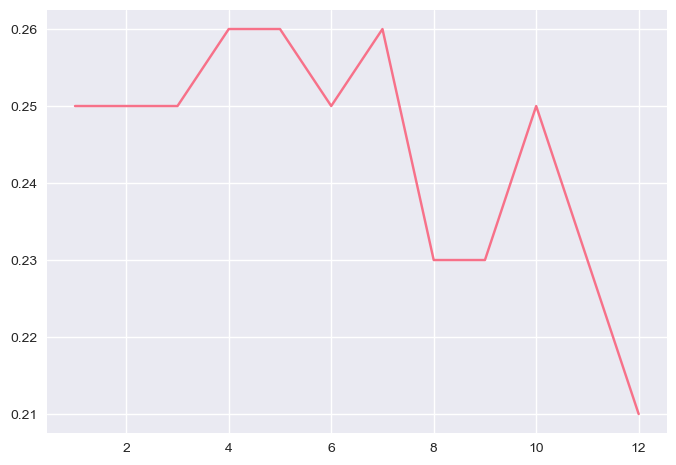

In [186]:
# Plotting issue month with default ratio to find any seasonality
freq_month = issue_date.groupby([issue_date['issue_d'].dt.month,'loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_month.index.levels[0],[round(freq_month[i].get('Charged Off')/(freq_month[i].get('Fully Paid') ),2) for i in freq_month.index.levels[0]])

There is slight variation between months which can be used.

Issue Date Insights
*  The dataset has issue dates  with years ranging from 2007 to 2016.
*  The number of loans per date seems to hit maximum around 2015
*  Converting to different quarters and plotting target ratio the ratio varies between 1 to 8.
*  We can apply ordinal encoding to the issue date quarters and also create a new feature for issue month

## Revolving Balance

count    3.960300e+05
mean     1.584454e+04
std      2.059184e+04
min      0.000000e+00
25%      6.025000e+03
50%      1.118100e+04
75%      1.962000e+04
max      1.743266e+06
Name: revol_bal, dtype: float64


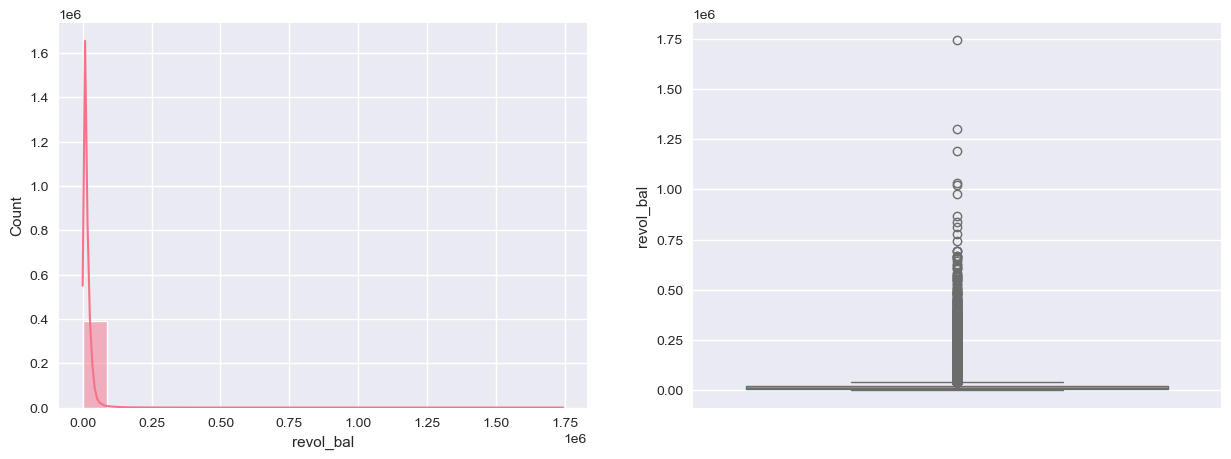

In [190]:
# For Revolving Balance ,plotting Histogram and box plot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set(font_scale=1)
sns.histplot(loan_data['revol_bal'],kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['revol_bal'],ax=axes[1])
print(loan_data['revol_bal'].describe())

Revolving Balance is highly skewed to the right with lots of outliers

In [192]:
# Calculating skew of revolving balance
skew(loan_data['revol_bal'])

11.72747070503949

In [193]:
# As there seems to be lot of outliers in revol_bal, looking at the outliers
revol_bal_median = loan_data['revol_bal'].quantile(0.5)
revol_bal_25 = loan_data['revol_bal'].quantile(0.25)
revol_bal_75 = loan_data['revol_bal'].quantile(0.75)
revol_bal_iqr = revol_bal_75 - revol_bal_25
revol_bal_outliers = loan_data[(loan_data['revol_bal']>(revol_bal_iqr*1.5+revol_bal_75)) | (loan_data['revol_bal']<(-revol_bal_iqr*1.5+revol_bal_25))]
revol_bal_outliers.describe()

loan_amnt      int_rate   installment    annual_inc           dti  \
count  21259.000000  21259.000000  21259.000000  2.125900e+04  21259.000000   
mean   21961.936121     13.301864    656.773543  1.330776e+05     20.232373   
std     9834.514471      4.691271    309.097115  9.593433e+04      7.785549   
min      500.000000      5.320000     16.080000  8.391480e+03      0.260000   
25%    14300.000000      9.490000    408.160000  8.500000e+04     14.540000   
50%    22500.000000     12.990000    656.990000  1.102100e+05     19.910000   
75%    30000.000000     16.290000    874.160000  1.500000e+05     25.570000   
max    40000.000000     30.990000   1533.810000  5.000000e+06     63.980000   

           open_acc       pub_rec     revol_bal    revol_util     total_acc  \
count  21259.000000  21259.000000  2.125900e+04  21235.000000  21259.000000   
mean      14.556705      0.045534  7.124096e+04     65.712680     32.420669   
std        5.943822      0.307641  5.679456e+04     22.273529     12.000778   
min        2.000000      0.000000  4.001300e+04      0.000000      4.000000   
25%       10.000000      0.000000  4.472900e+04     51.900000     24.000000   
50%       14.000000      0.000000  5.250100e+04     69.100000     31.000000   
75%       18.000000      0.000000  7.374400e+04     83.000000     39.000000   
max       90.000000     11.000000  1.743266e+06    121.700000    151.000000   

           mort_acc  pub_rec_bankruptcies  
count  19337.000000          21221.000000  
mean       3.350675              0.011687  
std        2.462935              0.123776  
min        0.000000              0.000000  
25%        2.000000              0.000000  
50%        3.000000              0.000000  
75%        5.000000              0.000000  
max       34.000000              8.000000

In [194]:
# Calculating skew of revolving balance after capping at 40000 (less than minimum of outliers)
skew(loan_data['revol_bal'].clip(upper=40000))

0.9903108620026104

<Axes: ylabel='revol_bal'>

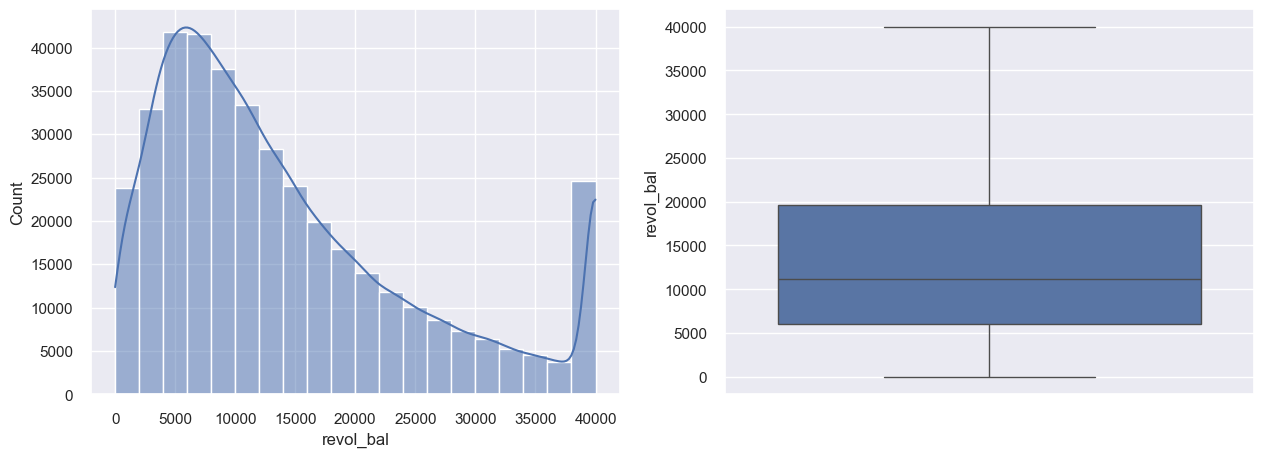

In [195]:
# Applying box cox transformation,plotting Histogram and box plot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set(font_scale=1)
sns.histplot(loan_data['revol_bal'].clip(upper=40000),kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['revol_bal'].clip(upper=40000),ax=axes[1])


After capping the revolving balance he skew has reduced to within acceptable range. Most values ofrevolving balance lie below 20000

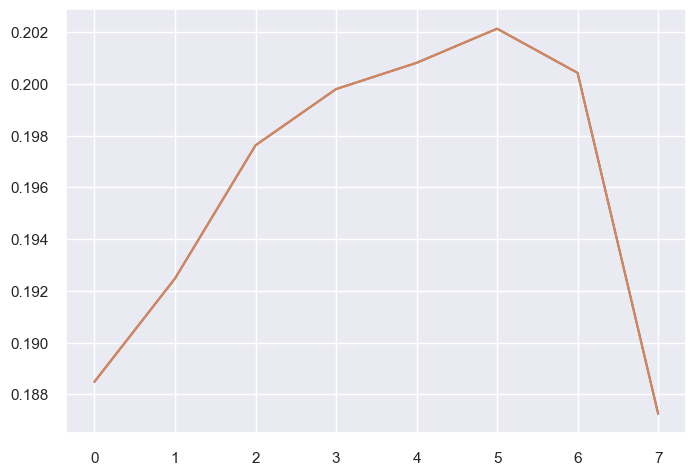

In [197]:
#  Spliting the Revolving Balnce column into 100 bins and plotting average default rate and applying smoothing
revol_bal = pd.DataFrame(loan_data['revol_bal'])
revol_bal['revol_bal_bin'] = pd.qcut(loan_data['revol_bal'],8,duplicates='drop')
revol_bal['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
revol_bal_default = pd.DataFrame(revol_bal.groupby('revol_bal_bin',observed=False)['loan_default'].mean())
revol_bal_default['count'] = revol_bal.groupby('revol_bal_bin',observed=False)['loan_default'].count()

plt.plot(revol_bal_default['loan_default'].values)
bin_map = {revol_bal_default.index[i]:i for i in range(len(revol_bal_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),revol_bal_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


The loan default ratio does not seem to vary much between the bins 

In [199]:
# Chi Square test between Revolving Balance bins and loan status
data = pd.crosstab(revol_bal['revol_bal_bin'], loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p),end = ' ')
if p <= alpha:
    print('Dependent (reject H0). The association strength is',association(data,method = 'cramer'))
else:
    print('Independent (H0 holds true)')

p value is 8.068308464791542e-14 Dependent (reject H0). The association strength is 0.013873867460981026


In [200]:
# Checking association of BInned Revolving Balance with Loan status
contingency_table = pd.crosstab(
    revol_bal['revol_bal_bin'],
    loan_data['loan_status'],        
    rownames=['Revolving Bal'],
    colnames=['Default']
)  # Ensure order is preserved
print(contingency_table)
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}")
print(f"P-value: {result.pvalue}")


Default               Charged Off  Fully Paid
Revolving Bal                                
(-0.001, 3627.0]             9333       40182
(3627.0, 6025.0]             9527       39969
(6025.0, 8432.0]             9784       39723
(8432.0, 11181.0]            9891       39613
(11181.0, 14633.0]           9940       39558
(14633.0, 19620.0]          10008       39503
(19620.0, 28550.0]           9921       39578
(28550.0, 1743266.0]         9269       40231
Chi2 Statistic (Trend): 1113086.0
P-value: 0.048475755917832174


Revolving Balance Insights
*  Revolving Balance varies from 0 to 1000000 
*  As there are lot of outliers ,applied capping at 40000 , which reduced the skew
* Target ratio of full paid to defaulted loans varies very little when converted to bins
*   But there seems to be a trend between the bins and loan status when number of bins is chosen as 8.
*   We can either cap the  outliers or apply binning and ordinal encoding

## Debt to Income

count    396030.000000
mean         17.379514
std          18.019092
min           0.000000
25%          11.280000
50%          16.910000
75%          22.980000
max        9999.000000
Name: dti, dtype: float64

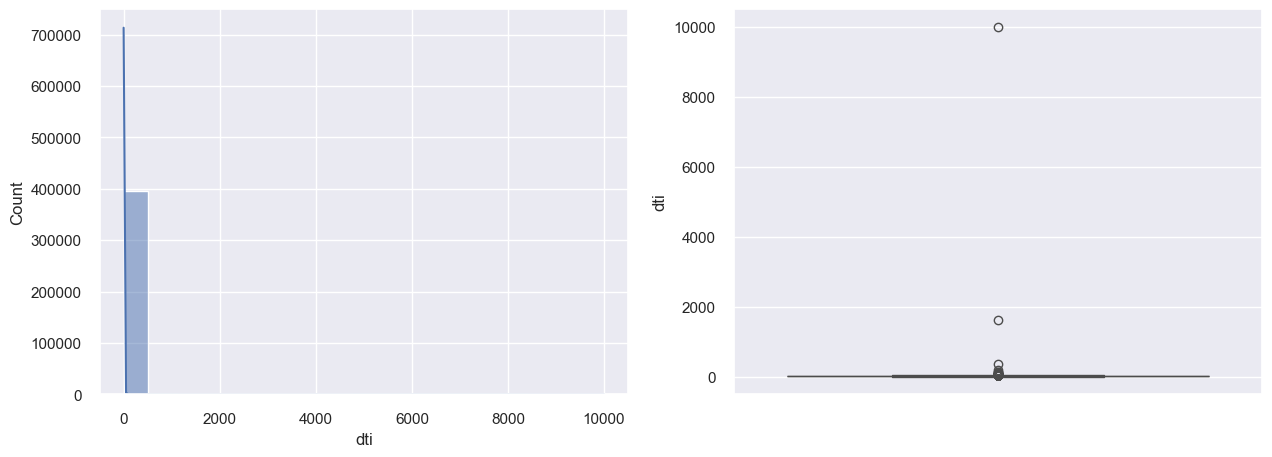

In [203]:
# For Debt to incmome.Plotting Histogram and box plot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['dti'],kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['dti'],ax=axes[1])
loan_data['dti'].describe()

The distribution is highly skewed to the right and has some outliers. There are two extreme outliers

In [205]:
skew(loan_data['dti'])

431.0495927070788

In [206]:
# As there seems to be lot of outliers in dti, looking at the outliers
dti_median = loan_data['dti'].quantile(0.5)
dti_25 = loan_data['dti'].quantile(0.25)
dti_75 = loan_data['dti'].quantile(0.75)
iqr = dti_75 - dti_25
outliers = loan_data[(loan_data['dti']>(iqr*1.5+dti_75)) | (loan_data['dti']<(-iqr*1.5+dti_25))]
outliers['dti'].describe()

count     275.00000
mean       91.12200
std       607.61616
min        40.55000
25%        42.48500
50%        44.83000
75%        47.72000
max      9999.00000
Name: dti, dtype: float64

In [207]:
# There is high positive skew. Capping the outliers at 40 minimum of outliers
skew(loan_data['dti'].clip(upper=40))

0.24252400734419952

Removing outliers has reduced the skew highly

count    396030.000000
mean         17.344000
std           8.113503
min           0.000000
25%          11.280000
50%          16.910000
75%          22.980000
max          40.000000
Name: dti, dtype: float64

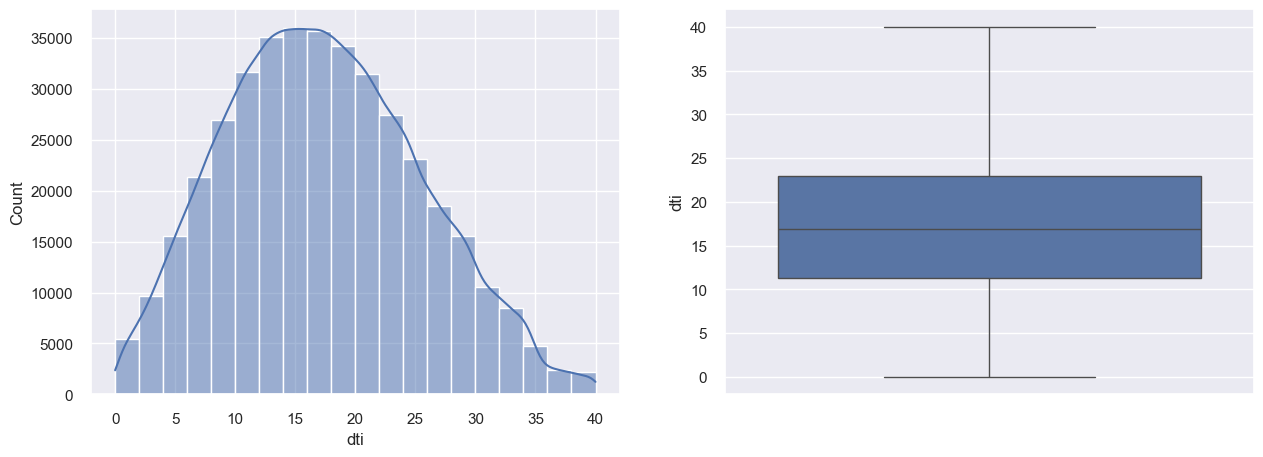

In [209]:
# For Debt to incmome.Plotting Histogram and box plot after removing outliers
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['dti'].clip(upper=40),kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['dti'].clip(upper=40),ax=axes[1])
loan_data['dti'].clip(upper=40).describe()

Removing outliers has reduced skew highly. The distributed is normal with mean and median around 15 and slight right skew. The range is between 0 and 40

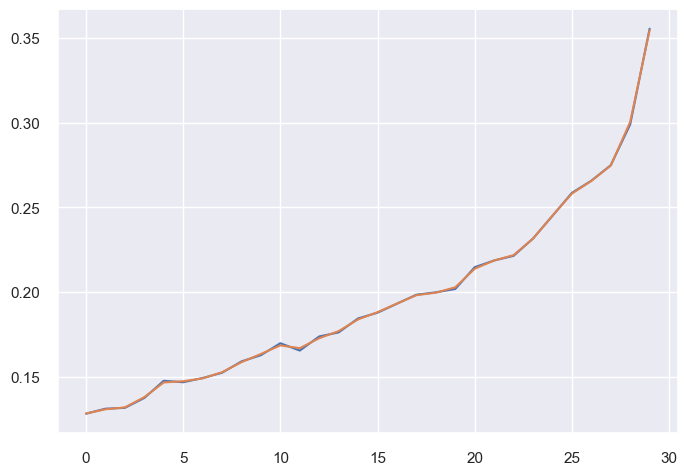

In [211]:
#  Spliting the dti column into 100 bins and plotting average default rate and applying smoothing
dti = pd.DataFrame(loan_data['dti'])
dti['dti_bin'] = pd.qcut(loan_data['dti'],30,duplicates='drop')
#dti['dti_bin'] = pd.cut(loan_data['dti'],10)

dti['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
dti_default = pd.DataFrame(dti.groupby('dti_bin',observed=False)['loan_default'].mean())
dti_default['count'] = dti.groupby('dti_bin',observed=False)['loan_default'].count()

plt.plot(dti_default['loan_default'].values)
bin_map = {dti_default.index[i]:i for i in range(len(dti_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),dti_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


The default rates increase with increase of order of the binned dti

In [213]:
# Checking trend of  BInned dti with Loan status
contingency_table = pd.crosstab(
    dti['dti_bin'],
    loan_data['loan_status'],        
    rownames=['Debt to Income'],
    colnames=['Default']
)  # Ensure order is preserved
contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 4440865.0 the association strength is 0.1352294151491987
P-value: 0.0


Debt to Income Insights
*  Debt to income varies from 0 to 10000 and most values lie between 0 and 40
*  We can either applying binning and ordinal encoding or capping outliers.

## Revolving Utilization

count    395754.000000
mean         53.791749
std          24.452193
min           0.000000
25%          35.800000
50%          54.800000
75%          72.900000
max         892.300000
Name: revol_util, dtype: float64
Percentage missing in Revolving Utilization: 0.06969169002348306


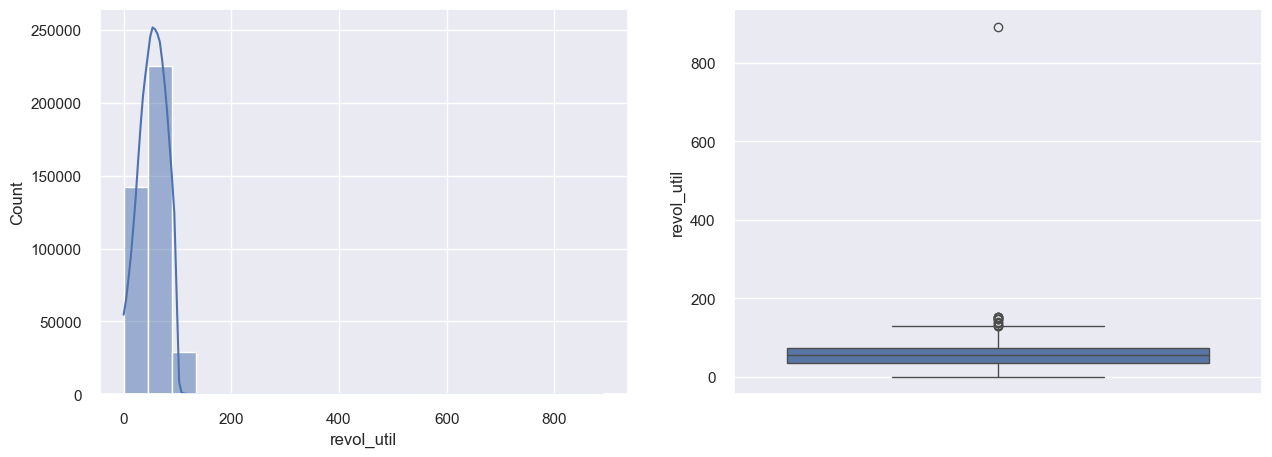

In [216]:
# For Revolving Utilization , plotting boxplot and histogram
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['revol_util'].dropna(),kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['revol_util'].dropna(),ax=axes[1])
print(loan_data['revol_util'].describe())
print("Percentage missing in Revolving Utilization:", loan_data['revol_util'].isnull().sum() * 100 / loan_data.shape[0])

* Revolving Utili is mostly concentrated below 100 with a few outliers.
* There are a few outliers that seem to skew the distribution
* Percentage missing in Revolving Utilization is very less and can be replaced by median value. 

In [218]:
skew(loan_data['revol_util'].dropna())

-0.07177774827280235

In [219]:
# As there seems to some outliers in revol_util, looking at the outliers
revol_util_median = loan_data['revol_util'].quantile(0.5)
revol_util_25 = loan_data['revol_util'].quantile(0.25)
revol_util_75 = loan_data['revol_util'].quantile(0.75)
revol_util_iqr = revol_util_75 - revol_util_25
revol_util_outliers = loan_data[(loan_data['revol_util']>(revol_util_iqr*1.5+revol_util_75)) | (loan_data['revol_util']<(-revol_util_iqr*1.5+revol_util_25))]
revol_util_outliers.dropna().describe()

loan_amnt   int_rate  installment     annual_inc        dti  \
count     10.000000  10.000000    10.000000      10.000000  10.000000   
mean   14582.500000  16.529000   473.759000  101381.100000  18.782000   
std     9238.807418   5.026977   357.759431   54445.158696   8.580484   
min     3500.000000   8.390000   117.080000   30000.000000   7.420000   
25%     9381.250000  12.907500   313.785000   56500.000000  12.337500   
50%    12275.000000  17.030000   369.835000   98005.500000  18.050000   
75%    16650.000000  19.625000   451.635000  128250.000000  25.390000   
max    35000.000000  25.830000  1407.010000  200000.000000  31.960000   

        open_acc  pub_rec     revol_bal  revol_util  total_acc   mort_acc  \
count  10.000000     10.0     10.000000   10.000000  10.000000  10.000000   
mean    6.900000      0.0  14830.500000  216.730000  18.200000   1.700000   
std     3.247221      0.0   7225.652746  237.529853  11.043349   2.213594   
min     2.000000      0.0   2677.000000  129.400000   5.000000   0.000000   
25%     5.000000      0.0  10278.500000  134.175000   9.250000   0.000000   
50%     6.500000      0.0  15085.500000  145.950000  16.500000   0.500000   
75%     9.000000      0.0  19682.750000  150.025000  26.500000   3.500000   
max    13.000000      0.0  27233.000000  892.300000  37.000000   6.000000   

       pub_rec_bankruptcies  
count                  10.0  
mean                    0.0  
std                     0.0  
min                     0.0  
25%                     0.0  
50%                     0.0  
75%                     0.0  
max                     0.0

count    396030.000000
mean         53.841869
std          24.486922
min           0.000000
25%          35.900000
50%          54.800000
75%          72.900000
max         129.000000
Name: revol_util, dtype: float64
-0.15922723659722612


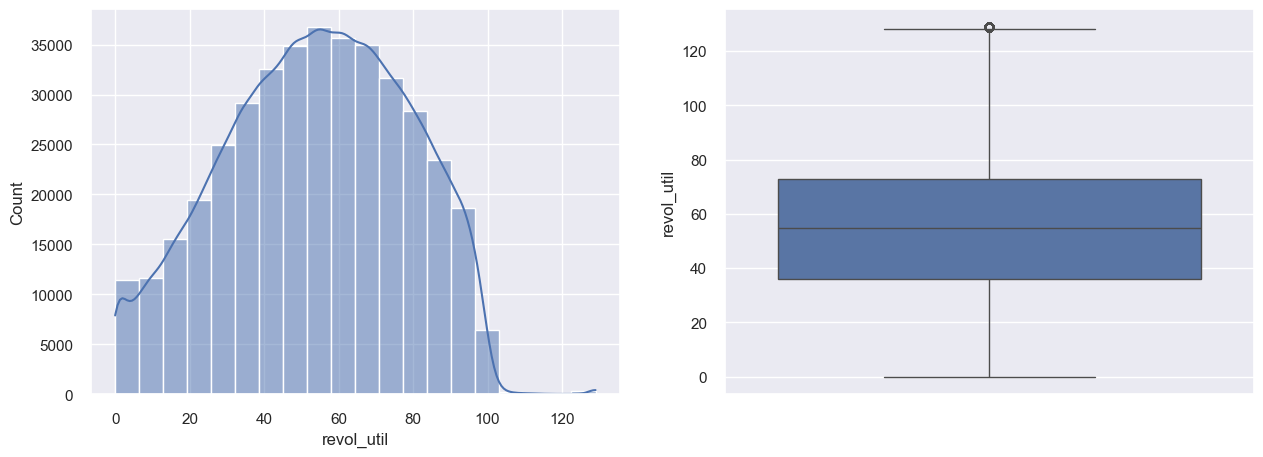

In [220]:
# as the skew is less we need to handle only the outliers
# Plotting and checking skew after capping at 129 and filling missing values with median
revol_util = loan_data['revol_util'].fillna(revol_bal_median).clip(upper = 129)
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(revol_util,kde = True, bins = 20,ax = axes[0])
sns.boxplot(revol_util,ax=axes[1])
print(revol_util.describe())
print(skew(revol_util))

*  Revol Util range is between 0 and 100. So loanees have varied debt utilization.
*  Skew is still within acceptable after replacing missing values with median and capping outliers

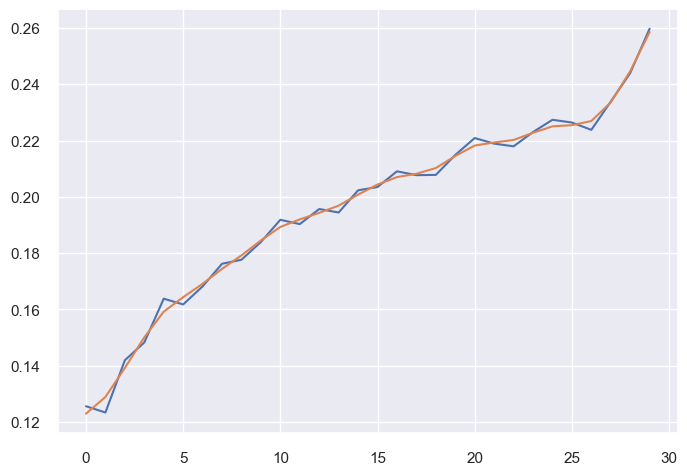

In [222]:
#  Spliting the revolving util column into 30 bins and plotting average default rate and applying smoothing
revol_util = pd.DataFrame(loan_data['revol_util'])
revol_util['revol_util_bin'] = pd.qcut(loan_data['revol_util'],30,duplicates='drop',)
#revol_util['revol_util_bin'] = pd.cut(loan_data['revol_util'],10)

revol_util['loan_default'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
revol_util_default = pd.DataFrame(revol_util.groupby('revol_util_bin',observed=False)['loan_default'].mean())
revol_util_default['count'] = revol_util.groupby('revol_util_bin',observed=False)['loan_default'].count()

plt.plot(revol_util_default['loan_default'].values)
bin_map = {revol_util_default.index[i]:i for i in range(len(revol_util_default.index))}
spl = make_smoothing_spline(list(bin_map.values()),revol_util_default['loan_default'].values)
plt.plot(list(bin_map.values()),spl(list(bin_map.values())))


As the revolving utilization increases there is a increasing trend in loan default rate.

In [224]:
# Checking association of revol_util BInned with Loan status
contingency_table = pd.crosstab(
    revol_util['revol_util_bin'],
    loan_data['loan_status'],        
    rownames=['Revol Util'],
    colnames=['Default']
)  # Ensure order is preserved

contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 4498974.0 the association strength is 0.08366089555996373
P-value: 0.0


Revolving Utilization Insights
*  We can use either the binned revol_util or cap the values at 129 and use it in our model.
* As there are very little missing values , we can impute the missing values with the median revol_util which is 54

<Axes: xlabel='revol_bal', ylabel='revol_util'>

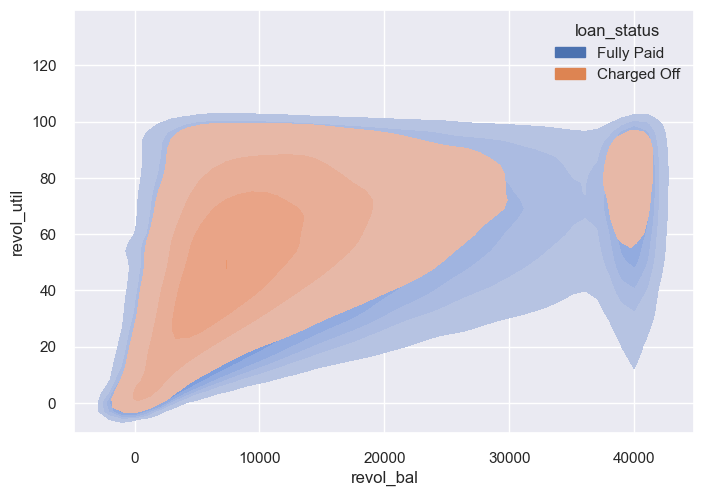

In [226]:
# As Revolving Utilization can depend on Revolving Balance. 
#  plotting Revolving Util vs REvolving Balance after capping outliers and handling missing values
revol = loan_data.loc[:,['revol_bal','revol_util','loan_status']]

revol['revol_util'] = revol['revol_util'].fillna(revol_util_median).clip(upper = 129)
revol['revol_bal'] = revol['revol_bal'].clip(upper= 40000)

sns.kdeplot(data=revol, y = 'revol_util' , x = 'revol_bal',hue = 'loan_status',fill=True,gridsize=50)

PLotting contour plot between revolving balance and revolving utilizion, shows a center around revol_util = 50 and revol_bal = 80000  which divides the plot into different regions of different distribution of default rates. We can use product of revol_util and revol_bal in our final model. 

## Public Records , Mortgage Accounts , Public Recorded Bankruptcies

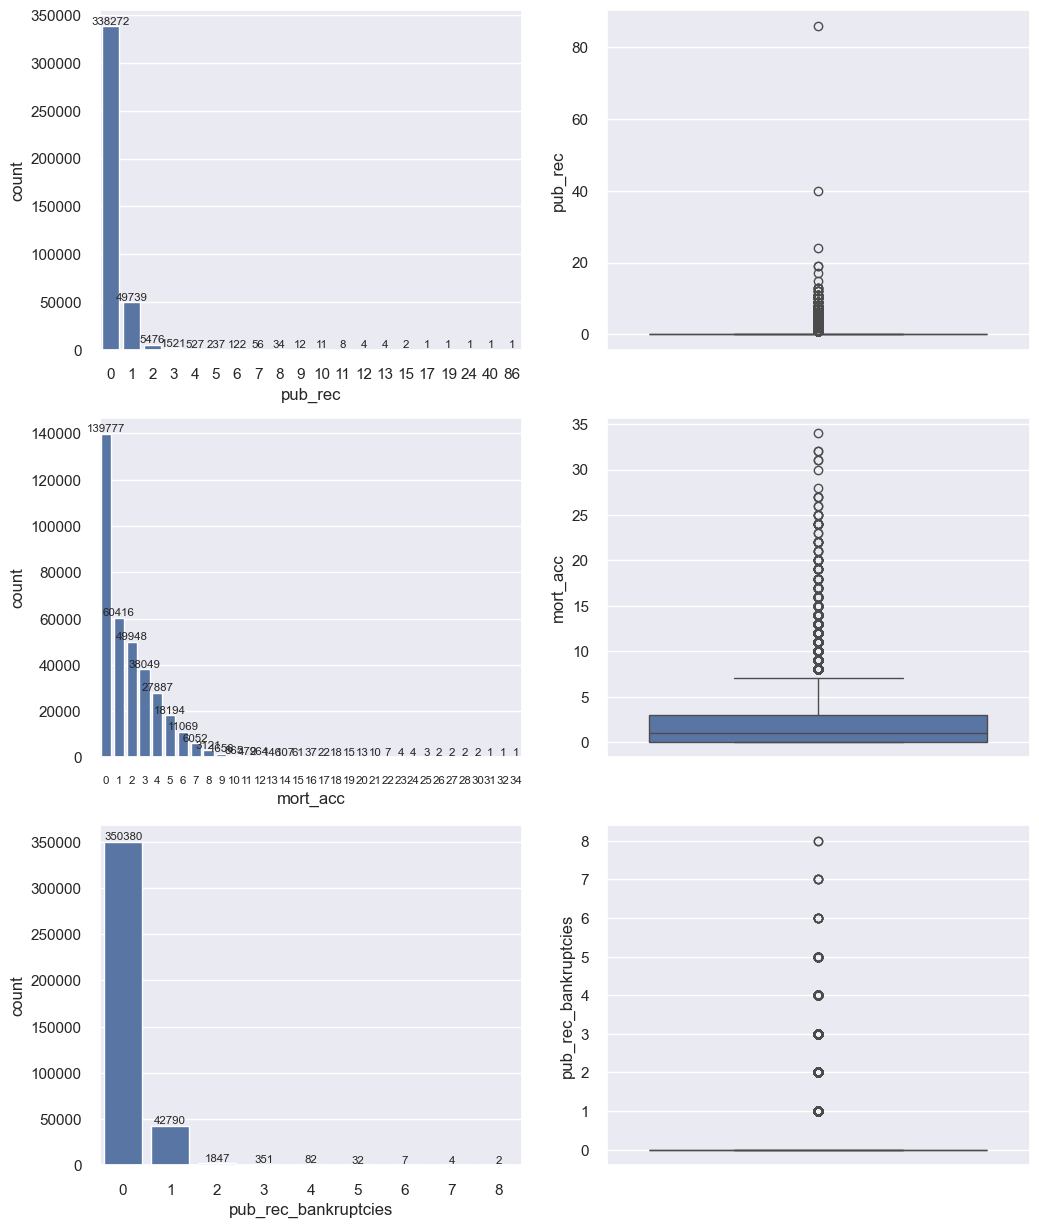

In [229]:
# Visualizing frequencies of values in  Pub_rec, Mort_acc, Pub_rec_bankruptcies
fig,axes = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(12)
pub_rec = loan_data['pub_rec'].apply(int).value_counts()
sns.set(font_scale=1)
sns.barplot(pub_rec,ax=axes[0][0])
axes[0][0].bar_label(axes[0][0].containers[0], pub_rec.values, fontsize = 'x-small')
sns.boxplot(loan_data['pub_rec'],ax=axes[0][1])

mort_acc = loan_data['mort_acc'].dropna().apply(int).value_counts()
sns.barplot(mort_acc,ax=axes[1][0])
axes[1][0].bar_label(axes[1][0].containers[0], mort_acc.values, fontsize = 'x-small')
axes[1][0].tick_params(axis = 'x',labelsize = 'x-small')
sns.boxplot(loan_data['mort_acc'].dropna(),ax=axes[1][1])

pub_ban = loan_data['pub_rec_bankruptcies'].dropna().apply(int).value_counts()
sns.barplot(pub_ban,ax=axes[2][0])
axes[2][0].bar_label(axes[2][0].containers[0], pub_ban.values, fontsize = 'x-small')
sns.boxplot(loan_data['pub_rec_bankruptcies'].dropna(),ax=axes[2][1])

plt.show()

The distributions of number of public records , public recorded bankruptcies and number of mortgage accounts are right skewed with most of the values either 0 or 1 for bankruptcies and public records

In [231]:
for rec in ['pub_rec','pub_rec_bankruptcies','mort_acc']:
    print("Skew of",rec , ':',skew(loan_data[rec].dropna()))

Skew of pub_rec : 16.576501414138953
Skew of pub_rec_bankruptcies : 3.4234273840472755
Skew of mort_acc : 1.6001257380122578


In [232]:
# Checking which values are outliers for these columns
for i in ['pub_rec','pub_rec_bankruptcies','mort_acc']:
    column = loan_data[i].dropna()
    column_median = column.quantile(0.5)
    column_25 = column.quantile(0.25)
    column_75 = column.quantile(0.75)
    column_iqr = column_75 - column_25
    column_outliers = column[(column>(column_iqr*1.5+column_75)) | (column<(-column_iqr*1.5+column_25))]
    print(i,'\n', column_outliers.describe())

pub_rec 
 count    57758.000000
mean         1.221805
std          0.809841
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         86.000000
Name: pub_rec, dtype: float64
pub_rec_bankruptcies 
 count    45115.000000
mean         1.066408
std          0.323423
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: pub_rec_bankruptcies, dtype: float64
mort_acc 
 count    6843.000000
mean        9.364314
std         2.188059
min         8.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        34.000000
Name: mort_acc, dtype: float64


*  Converting Public records and Public Bankrupticies into binary features as all values above 1 are outliers in the columns
*  We can cap mortgage accounts at 7 as 8 and above are outliers

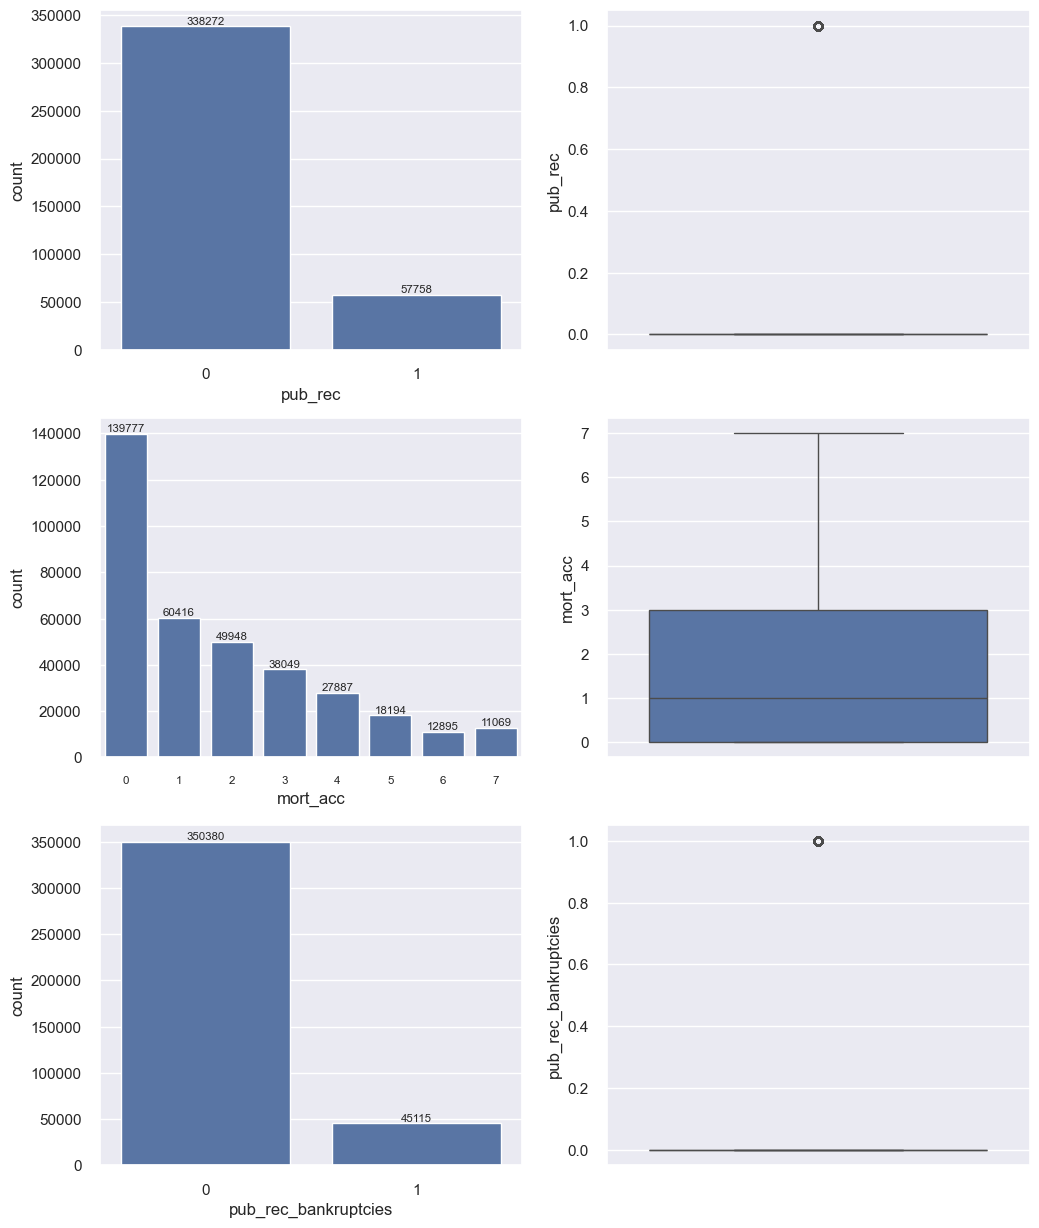

In [234]:
# Plotting the graphs after capping and calculating skews.
# Visualizing frequencies of values in  Pub_rec, Mort_acc, Pub_rec_bankruptcies
fig,axes = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(12)
pub_rec = loan_data['pub_rec'].clip(upper = 1).apply(int).value_counts()
sns.set(font_scale=1)
sns.barplot(pub_rec,ax=axes[0][0])
axes[0][0].bar_label(axes[0][0].containers[0], pub_rec.values, fontsize = 'x-small')
sns.boxplot(loan_data['pub_rec'].clip(upper = 1),ax=axes[0][1])

mort_acc = loan_data['mort_acc'].dropna().clip(upper = 7).apply(int).value_counts()
sns.barplot(mort_acc,ax=axes[1][0])
axes[1][0].bar_label(axes[1][0].containers[0], mort_acc.values, fontsize = 'x-small')
axes[1][0].tick_params(axis = 'x',labelsize = 'x-small')
sns.boxplot(loan_data['mort_acc'].dropna().clip(upper = 7),ax=axes[1][1])

pub_ban = loan_data['pub_rec_bankruptcies'].dropna().clip(upper = 1).apply(int).value_counts()
sns.barplot(pub_ban,ax=axes[2][0])
axes[2][0].bar_label(axes[2][0].containers[0], pub_ban.values, fontsize = 'x-small')
sns.boxplot(loan_data['pub_rec_bankruptcies'].dropna().clip(upper = 1),ax=axes[2][1])

plt.show()

In [235]:
print("Skew of pub_rec :",skew(loan_data['pub_rec'].clip(upper = 1)))
print("Skew of pub_rec_bankruptcies :",skew(loan_data['pub_rec_bankruptcies'].dropna().clip(upper = 1)))
print("Skew of mort_acc :",skew(loan_data['mort_acc'].dropna().clip(upper = 7)))

Skew of pub_rec : 2.006852446790763
Skew of pub_rec_bankruptcies : 2.427989914129101
Skew of mort_acc : 1.0255363861271058


*  Public records and Public bankruptices still show up as outliers in box plots.
*  Skew of Mortgage accounts reduced significantly and is within acceptable range.
*  Most loanees have less than 3 mortgage accounts.

In [237]:
# Checking Ordinal association with Loan status for 'pub_rec','pub_rec_bankruptcies'
records = ['pub_rec','pub_rec_bankruptcies','mort_acc']
for rec in records:
    print(rec)
    ord_var = pd.DataFrame(loan_data[rec])
    ord_var['loan_status'] = loan_data['loan_status']
    ord_var = ord_var.dropna()
    ord_var[rec] = ord_var[rec].apply(int)
    ord_var_unq = sorted(ord_var[rec].unique())

    contingency_table = pd.crosstab(
        ord_var[rec],  # Ordinal variable
        ord_var['loan_status'],          # Binary target
        rownames=[rec],
        colnames=['Default']
    ).loc[ord_var_unq]  # Ensure order is preserved

    # Cochran-Armitage Test (Trend Test)
    table = ct.Table(contingency_table.values)
    result = table.test_ordinal_association()

    print(f"Chi2 Statistic (Trend): {result.statistic}",association(contingency_table))
    print(f"P-value: {result.pvalue}")


pub_rec
Chi2 Statistic (Trend): 55087.5 0.022195677977389628
P-value: 5.1165168981520797e-36
pub_rec_bankruptcies
Chi2 Statistic (Trend): 38148.0 0.01064032037912227
P-value: 3.619983636725719e-09
mort_acc
Chi2 Statistic (Trend): 541556.0 0.0801641913273871
P-value: 0.0


In [238]:
# Checking Correlation between 'pub_rec','pub_rec_bankruptcies', and loan_status
pub_status = loan_data.loc[:,['pub_rec','pub_rec_bankruptcies','loan_status']]
pub_status['loan_status'] = pub_status['loan_status'].map({'Fully Paid':0,'Charged Off':1})
pub_status['pub_rec'] = pub_status['pub_rec'].clip(upper = 1)
pub_status['pub_rec_bankruptcies'] = pub_status['pub_rec_bankruptcies'].clip(upper = 1)
pub_status.corr()

pub_rec  pub_rec_bankruptcies  loan_status
pub_rec               1.000000              0.867867     0.018125
pub_rec_bankruptcies  0.867867              1.000000     0.008304
loan_status           0.018125              0.008304     1.000000

In [239]:
# Applying chi square test with loan status and checking metrics after capping 'pub_rec','pub_rec_bankruptcies'
records = ['pub_rec','pub_rec_bankruptcies']

for i in records:
    data = pd.crosstab(loan_data[i].dropna().apply(lambda x: 1 if x>=1 else 0), loan_data['loan_status'])
    stat, p, dof, expected = chi2_contingency(data)
    # interpret p-value
    alpha = 0.05
    print(i,"p value is " + str(p),end = ' ')
    if p <= alpha:
        print('Dependent (reject H0).')
        print("For predicting loan status using",i, 'Accuracy Score :',(data.loc[0,'Fully Paid']+data.loc[1,'Charged Off'])/data.sum().sum())
        print("Recall :",data.loc[1,'Charged Off']/(data.loc[1,'Charged Off']+data.loc[0,'Charged Off']))
        print("Precision :",data.loc[1,'Charged Off']/(data.loc[1,'Charged Off']+data.loc[1,'Fully Paid']))
    else:
        print('Independent (H0 holds true)')
    

pub_rec p value is 4.146193595335986e-30 Dependent (reject H0).
For predicting loan status using pub_rec Accuracy Score : 0.720316642678585
Recall : 0.15879391809251606
Precision : 0.21354617542158663
pub_rec_bankruptcies p value is 1.8286622518312094e-07 Dependent (reject H0).
For predicting loan status using pub_rec_bankruptcies Accuracy Score : 0.736606025360624
Recall : 0.11941587399788621
Precision : 0.20536406959991133


In [240]:
data = pd.crosstab(loan_data['mort_acc'].dropna().clip(upper = 7),loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)
# interpret p-value
alpha = 0.05
print(i,"p value is " + str(p),end = ' ')
if p <= alpha:
    print('Dependent (reject H0). Association is ',association(data,method='cramer'))
else:
    print('Independent (H0 holds true)')

pub_rec_bankruptcies p value is 0.0 Dependent (reject H0). Association is  0.0797655440530994


Insights about Public records, Pub_rec_bankruptcies
*  Both of them are highly skewed and have still high skew after capping at 1
*  As pub_rec and pub_rec_bankruptcies are highly correlated, and have similar precision and association with loan status we can use only pub_rec as it doesn't have missing values.
* We will use pub_rec converted to a binary feature.


In [242]:
# Calculating correlation between open_acc , total_acc , mort_acc
loan_data.loc[:,['mort_acc','open_acc','total_acc']].corr()

mort_acc  open_acc  total_acc
mort_acc   1.000000  0.109205   0.381072
open_acc   0.109205  1.000000   0.680728
total_acc  0.381072  0.680728   1.000000

mort_acc
0.0    139777
1.0     60416
2.0     49948
3.0     38049
4.0     27887
5.0     18194
7.0     12895
6.0     11069
Name: count, dtype: int64


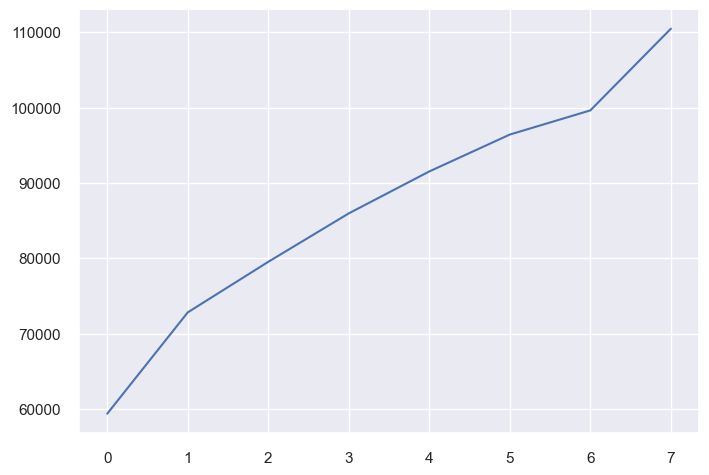

In [243]:
# Plotting Mortgage Accounts vs Average Annual Income

mort_acc = pd.DataFrame(loan_data['mort_acc'])
mort_acc ['annual_inc']  = loan_data['annual_inc']
mort_acc = mort_acc.dropna()
mort_acc['mort_acc'] = mort_acc['mort_acc'].clip(upper = 7)
mean_annual_incs = mort_acc.groupby('mort_acc')['annual_inc'].mean()
count_mort_acc = mort_acc['mort_acc'].value_counts()
plt.plot(mean_annual_incs)
print(count_mort_acc)

Annual Incomes averaged over number of mortgage accounts follows a trend. We can use this trend to impute the missing values in mortgage accounts column.
Also Mortgage accounts shows an association of 0.08 which doesnt change much after being capped at 7.

In [245]:
# checking home ownership vs mortgage accounts
print(loan_data.groupby('home_ownership',observed=False)['mort_acc'].describe())


                   count      mean       std  min  25%  50%  75%   max
home_ownership                                                        
ANY                  3.0  2.000000  1.000000  1.0  1.5  2.0  2.5   3.0
MORTGAGE        181706.0  2.823280  2.140381  0.0  1.0  2.0  4.0  34.0
NONE                29.0  2.172414  2.253077  0.0  0.0  2.0  3.0   8.0
OTHER               34.0  1.588235  2.119429  0.0  0.0  1.0  2.0   7.0
OWN              34779.0  1.386728  1.962927  0.0  0.0  1.0  2.0  24.0
RENT            141684.0  0.624460  1.440726  0.0  0.0  0.0  0.0  30.0


we can also use home ownership to impute mort_acc. we can impute with median 2 for home_ownership='MORTGAGE'

## Loan Title

In [248]:
# Loan Title Distribution
print("Unique categories:",loan_data['title'].nunique())
loan_title = pd.DataFrame(loan_data['title']).rename(columns={'title':'loan_title'})
loan_title['loan_status'] = loan_data['loan_status'].map({'Charged Off':1,'Fully Paid':0})
# Frequency for each category
loan_title_freq= pd.DataFrame(loan_title.groupby('loan_title')['loan_status'].mean())
loan_title_freq['count'] = loan_title['loan_title'].value_counts()

loan_title_freq =  loan_title_freq.sort_values(by = 'count',ascending=False)
print("Visualizing Frequency of top 20 categories in Loan title, as there are lot of categories \n",loan_title_freq.head(20))


Unique categories: 48816
Visualizing Frequency of top 20 categories in Loan title, as there are lot of categories 
                            loan_status   count
loan_title                                    
Debt consolidation            0.230127  152472
Credit card refinancing       0.192806   51487
Home improvement              0.189924   15264
Other                         0.234416   12930
Debt Consolidation            0.149035   11608
Major purchase                0.203816    4769
Consolidation                 0.142783    3852
debt consolidation            0.202988    3547
Business                      0.325195    2949
Debt Consolidation Loan       0.151536    2864
Medical expenses              0.246171    2742
Car financing                 0.164563    2139
Credit Card Consolidation     0.108732    1775
Vacation                      0.205009    1717
Moving and relocation         0.280639    1689
consolidation                 0.180564    1595
Personal Loan                 0.140792

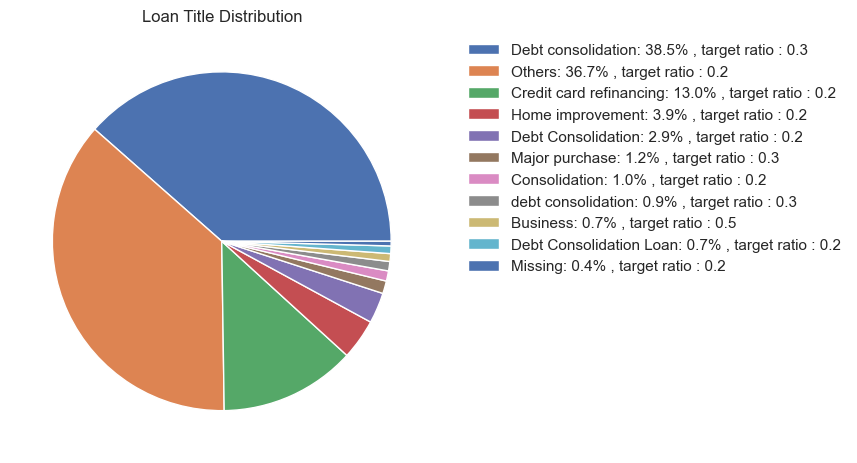

In [249]:
# Plotting top 20 categories and comnbining rest as "Others" and creating new category for "Missing"
top_titles = list(loan_title_freq.head(10).index)
loan_title['loan_title'] = loan_title['loan_title'].fillna("Missing")
top_titles.append("Missing")
top_titles.remove("Other")
loan_title['loan_title_modified'] = loan_title['loan_title'].apply(lambda x:  x  if x in top_titles else "Others")
loan_title_modified_freq= pd.DataFrame(loan_title.groupby('loan_title_modified')['loan_status'].mean())
loan_title_modified_freq['count'] = loan_title['loan_title_modified'].value_counts()

loan_title_modified_freq =  loan_title_modified_freq.sort_values(by = 'count',ascending=False)
plt.pie(loan_title_modified_freq['count'],labels= None)
labels = [(i[0] +': '+ str(round(i[2]*100/len(loan_data),1)) + '% , target ratio : ' + str(round(i[1]/(1-i[1]),1) )) for i in loan_title_modified_freq.reset_index().values]
plt.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Loan Title Distribution')
plt.show()

Loan title column has same categories as Loan purpose and similiar distribution

In [251]:
# most common words in loan title column

title_words_freq = pd.Series(Counter(' '.join(list(loan_data['title'].dropna().apply(lambda x: x.lower()))).split())).sort_values(ascending=False)
title_words_freq.iloc[:10]

consolidation    190832
debt             190391
credit            74246
card              68207
refinancing       52255
loan              27992
home              22591
improvement       18752
other             13251
payoff             6638
dtype: int64

In [252]:
# Taking the top 1000 words used in the column and assigning ranks to the title column based on the max frequency word used in the row
k = 1000
title_word_rank = title_words_freq.iloc[:k].reset_index().reset_index().set_index('index')['level_0']
def title_check(x):
    z = [title_word_rank.get(i,k+1) for i in x.lower().split()]
    return min(z)
loan_title_freq_rank = loan_data['title'].fillna('debt').apply(title_check)
# Applying chi square test for the word ranks with loan status
data = pd.crosstab(loan_title_freq_rank, loan_data['loan_status'])
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)',association(data,method='cramer'))
else:
    print('Independent (H0 holds true)')

p value is 9.823236787865704e-206
Dependent (reject H0) 0.08485416773984825


In [253]:
word_rank_order = sorted(loan_title_freq_rank.unique())
contingency_table = data.loc[word_rank_order]  # Ensure order is preserved

# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}")
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 10422131.5
P-value: 5.5393221796144574e-27


Loan Title Insights
*  Loan Title has more than 40000 categories with varying fully paid to default ratio.
*  Calculated frequency of all words in loan title column and assigned the max frequency word to each loan title and applied chi square test with loan status showed significant association.
* Using the word frequency ranks as ordinal variable also showed a trend with target variable on applying the Cochran Armitage test

## Earliest Credit Line Date

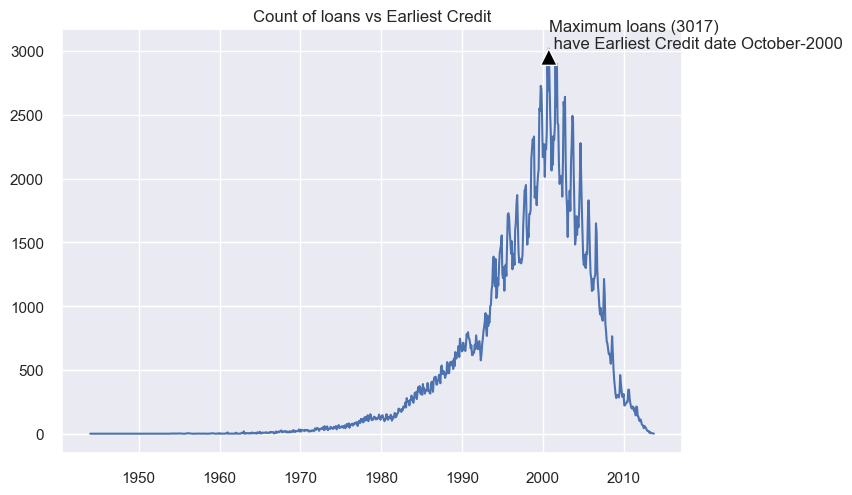

In [256]:
# Visualizing Earliest Credit line date , Plotting No of loans with earliest_cr_line
earliest_credit = pd.to_datetime(loan_data['earliest_cr_line'],format = '%b-%Y')
plt.plot(earliest_credit.value_counts().sort_index())
plt.title('Count of loans vs Earliest Credit')
max_value = earliest_credit.value_counts().max()
max_date = earliest_credit.value_counts().idxmax()
plt.annotate(f'Maximum loans ({max_value})\n have Earliest Credit date {max_date.month_name()}-{max_date.year}', xy=(max_date, max_value),
             xytext=(max_date, max_value + 5),
             arrowprops=dict(facecolor='black'))
plt.show()

Number of loans based on earliest credit date increases slowly and then exponentially to 3000 per day around year 2000 and then drops to 0

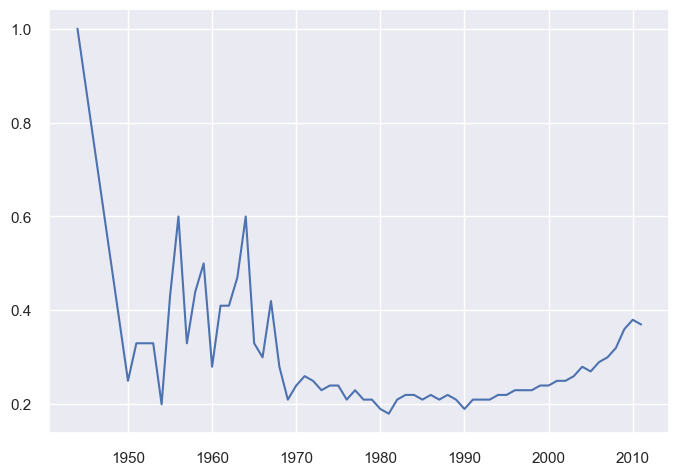

In [258]:
# Plotting Loan Default rate with year of Earliest Credit Line date
earliest_credit = pd.DataFrame(pd.to_datetime(loan_data['earliest_cr_line'],format = '%b-%Y'))
earliest_credit['loan_status'] = loan_data['loan_status']
freq_year = earliest_credit.groupby([earliest_credit['earliest_cr_line'].dt.to_period('Y'),'loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_year.index.levels[0].to_timestamp()[:-2],[round(freq_year[i].get('Charged Off',1)/(freq_year[i].get('Fully Paid',0)+1 ),2) for i in freq_year.index.levels[0]][:-2])

Loan default  rate decreases with earliest credit year of loanees from 1950 to around 1990 and the increases again till 2010. 
This means older loanees get more reliable with more recent earliest credit year but newer loanees get more unreliable with more recent earliest credit year

<Axes: xlabel='earliest_cr_line'>

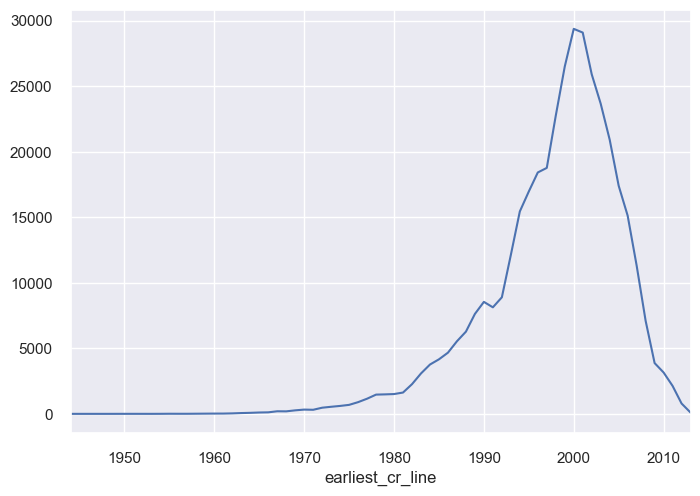

In [260]:
# Plotting number of loans with earliest credit year
earliest_credit.groupby(earliest_credit['earliest_cr_line'].dt.to_period('Y'))['loan_status'].count().plot()

The number of loans with earliest credit line is  very low before 1980. The maximum number of loans have an earliest credit year around 2000. After 2000 the number of loans reduces again probably due to lesser credit information on newer loanees

In [262]:
# No of loans is very less before 1980,So capping the years at 2nd standard deviation on both sides
yrs = earliest_credit.reset_index()['earliest_cr_line'].dt.to_period('Y').apply(lambda x: x.year)
# Capping years at the 2nd standard deviation
print("Upper bound will be :" ,yrs[stats.zscore(yrs)>2].min())
print("Lower bound will be :", yrs[stats.zscore(yrs)<-2].max())
earliest_credit['year'] = earliest_credit['earliest_cr_line'].dt.to_period('Y').apply(lambda x: x.year)
earliest_credit['year_clipped'] = earliest_credit['year'].clip((yrs[stats.zscore(yrs)<-2].max())+1,(yrs[stats.zscore(yrs)>2].min())-1)

Upper bound will be : 2013
Lower bound will be : 1983


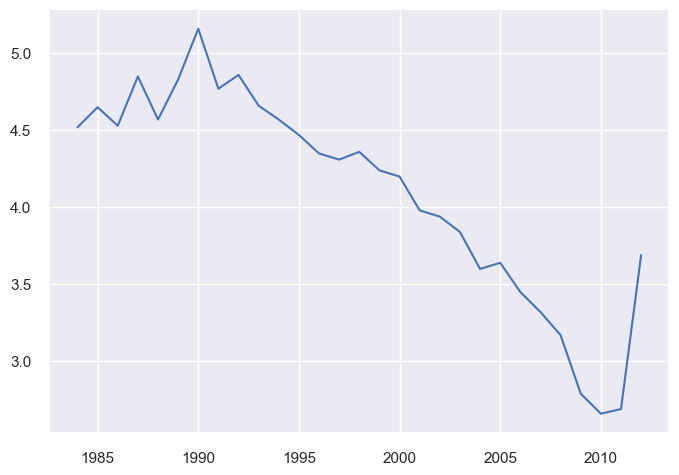

In [263]:
# Plotting Fully paid to Charged off ratio with clipped year of Earliest Credit Line date
freq_year = earliest_credit.groupby(['year_clipped','loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_year.index.levels[0],[round(freq_year[i].get('Fully Paid',1)/(freq_year[i].get('Charged Off',0)+1 ),2) for i in freq_year.index.levels[0]])

The Loan default rate increases for earliest credit year from 1990 to 2010.

In [265]:
# Checking association of Earliest Credit Quarter with Loan status
contingency_table = pd.crosstab(
    earliest_credit['earliest_cr_line'].dt.to_period('Q'),
    loan_data['loan_status'],        
    rownames=['Earliest Credit Line'],
    colnames=['Default']
)  # Ensure order is preserved

contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")


Chi2 Statistic (Trend): 57451379.5 the association strength is 0.058595193061723914
P-value: 4.908113206979299e-130


In [266]:
# Checking association of Earlies Quarter year with Loan status
contingency_table = pd.crosstab(
    earliest_credit['earliest_cr_line'].dt.to_period('Y'),
    loan_data['loan_status'],        
    rownames=['Earliest Credit Line'],
    colnames=['Default']
)  # Ensure order is preserved

contingency_table.index = [i for i in range(len(contingency_table.index))]
# Cochran-Armitage Test (Trend Test)
table = ct.Table(contingency_table.values)
result = table.test_ordinal_association()

print(f"Chi2 Statistic (Trend): {result.statistic}", "the association strength is",association(contingency_table,method = 'cramer'))
print(f"P-value: {result.pvalue}")

Chi2 Statistic (Trend): 15510123.0 the association strength is 0.053790507483574355
P-value: 4.0759019928672215e-132


Earliest Credit Line Insights
*  The dataset has Earliest Credit Line with years ranging from 1944 to 2013
*  Most loans have been offered to loanees with earliest credit line between 1980 and 2010.
*   Loan default rate increases with earliest credit line during this period.
* We can convert the earliest credit line to quarter and apply ordinal encoding as there is a trend between earliest credit line quarter and loan status

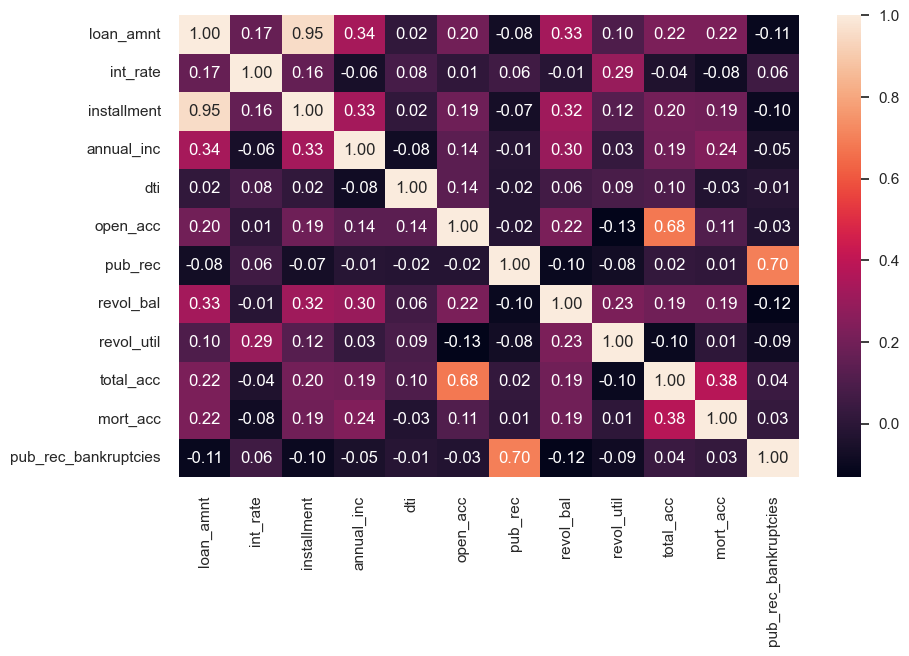

In [268]:
# Coorelation Heat map of pure numerical columns
fig, ax = plt.subplots()
sns.heatmap(loan_data.select_dtypes(include='float64').corr(),annot=True,fmt=".2f" ,ax = ax)
fig.set_size_inches(10,6)

From the Correlation heatmap of numerical features in the data we can see that:
*  LOan Amount is positively correlated with Annual Income showing loanees with higher annual income buy bigger loans.
*  Loan AMount is slightly correlated with interest rate.
*  Loan AMount is highly coorelated with Installment as inferred before.
*  Revolving Balance is also positively correlated with Loan AMount which can be considered as a combination of debt apetite and income.
*  ANnual income is also positively correlated with revolving balance as inferred before.
*  Public record is higly correlated with public recorded bankruptcies implying similar data sources for the two columns.
*  Interest rate is correlated with Revolving Util showing higher debt utilization causes Loaners to increase the interest rates.
*  Open accounts is highly correlated with total accounts shows loanees often buy debt from multiple sources.
*  Total Accounts is correlated with MOrtgage Accounts indicating mortgage acccounts are part of the total accounts

# Logistic Regression Model

Splitting dataset for Training , Validation and Testing Logistic Regression Model

In [272]:
# Applying train test split before EDA. As its a imbalanced classification with stratification
X_train_validation, X_test, y_train_validation, y_test = train_test_split(df.drop(['loan_status'],axis = 1),df['loan_status'],random_state=40,test_size=0.2,stratify=df['loan_status'])

In [273]:
# Splitting into validation and training sets
X_train,X_validation,y_train,y_validation = train_test_split(X_train_validation,y_train_validation,random_state=40,test_size=0.2,stratify=y_train_validation)


In [274]:
# Checking shapes of datasets
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X_validation ',X_validation.shape)
print('y_validation ',y_validation.shape)
print('X_test ',X_test.shape)
print('y_test ',y_test.shape)

X_train  (253459, 26)
y_train  (253459,)
X_validation  (63365, 26)
y_validation  (63365,)
X_test  (79206, 26)
y_test  (79206,)


## First Approach

* We will use one hot encode Zipcode , loan term , home ownership (after combining less frequent categories) , Verification Status , Employee Length (after binning) , Purpose (after grouping categories into family , small business and others).
* We will impute mortgage accounts and employment length using Annual income.
* We will impute revolving util with its median.
* We will use loan amount , interest rate , dti , mortgage accounts , open accounts , total accounts , revolving balance , revolving Utilization , Public Records as numerical features after capping the outliers.
* We will extract the quarter from  issue date and earliest credit date and convert into an ordinal feature.
* We will also use the month of issue date.
* We will create new features from loan title and employee title by extracting highest Frequency Rank among the words in each row, where the frequency is calculated over all rows in the columns.

### Preprocessing

In [278]:
# Label encoding on y_train - loan status
y_encoder = LabelEncoder( )
y_encoder.fit(y_train)
y_encoder.classes_= np.array(['Fully Paid','Charged Off'])
y_train_encoded = y_encoder.transform(y_train[X_train.index])

In [279]:
# Extracting Zipcode from address and applying one hot encoding
X_train_processed = pd.DataFrame(index = X_train.index)
zipcodes = X_train['address'].apply(lambda x : x.split()[-1]) 
zipcode_encoder = OneHotEncoder(drop='first')
zipcode_encoder.fit(pd.DataFrame(zipcodes))
X_train_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(zipcodes)).toarray()

In [280]:
# Applying one hot encoding on Loan term
term_encoder = OneHotEncoder(sparse_output=False,drop='first')
term_encoder.fit(pd.DataFrame(X_train['term']))
X_train_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(X_train[['term']])

In [281]:
# Grouping home ownership into mortgage ,owned , rent , or others and applying ohe hot encoding
def home_ownership_cleanup(x):
    if x not in ['MORTGAGE','OWN','RENT']:
        return 'OTHERS'
    else:
        return x 
ho_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[ho_encoder.get_feature_names_out()] = ho_encoder.fit_transform(pd.DataFrame(X_train['home_ownership'].apply(home_ownership_cleanup)))

In [282]:
# Applying one hot encoding for verfication status
vs_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[vs_encoder.get_feature_names_out()] = vs_encoder.fit_transform(pd.DataFrame(X_train['verification_status']))

In [283]:
# converting employee length to numerical
def empl_length_num(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
# Imputing employee length using annual income
emp_len_imputer = KNNImputer(n_neighbors=1)
emp_length_imputed = emp_len_imputer.fit_transform(pd.DataFrame(X_train['emp_length'].apply(empl_length_num)),X_train['annual_inc'])


In [284]:
# Creating bins of employee length and applying one hot encoding
def emp_len_bin(x):
    
    if x < 1:
        return '<1 yr'
    if x < 1.5:
        return '1 yr'
    if 1.5 <= x < 7.5 :
        return '2-7 yrs'
    if 7.5 <= x < 9.5:
        return '8-9 yrs'
    if x >= 9.5 :
        return '10+ yrs'
emp_len_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.fit_transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = X_train.index).apply(emp_len_bin)))
   

In [285]:
# Capping Loan amounts at 38000
X_train_processed['loan_amnt'] = X_train['loan_amnt'].clip(upper = 38000)

In [286]:
# Using interest rates as is
X_train_processed['int_rate'] = X_train['int_rate']

In [287]:
# Capping Open Accounts at 23
X_train_processed['open_acc'] = X_train['open_acc'].clip(upper=23)

In [288]:
# Capping Total Accounts at 54
X_train_processed['total_acc'] = X_train['total_acc'].clip(upper=54)

In [289]:
# Capping Annual Income at 150000
X_train_processed['annual_inc'] = X_train['annual_inc'].clip(upper=150000)

In [290]:
# Capping Revolving Balance at 40000
X_train_processed['revol_bal'] = X_train['revol_bal'].clip(upper = 40000)

In [291]:
# Capping Dti between 0 and 40
X_train_processed['dti'] = X_train['dti'].clip(lower = 0,upper = 40)

In [292]:
# Imputing Revolving Util with median and capping values at 129
revol_util_median = X_train['revol_util'].quantile(0.5)
revol_util_imputed = X_train['revol_util'].fillna(revol_util_median)
X_train_processed['revol_util'] = revol_util_imputed.clip(upper = 129)

In [293]:
# Grouping Purpose into Family , Small business and other and applying one hot encoding
purpose_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.fit_transform(pd.DataFrame(X_train['purpose'].apply(lambda x : 'family' if x in ['credit_card','home_improvement','major_purchase','educational','wedding','car','vacation','house'] else ('other' if x!='small_business' else 'small_business'))
))

In [294]:
#  Getting the Issue date quarter converted to ordinal values and Issue date month 
X_train_processed['issue_qtr'] = (pd.to_datetime(X_train['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)
X_train_processed['issue_month'] = pd.to_datetime(X_train['issue_d'],format = '%b-%Y').dt.month

In [295]:
# Imputing mort_acc using annual income 

mort_acc_imputer = KNNImputer(n_neighbors=1)
mort_acc_imputed = mort_acc_imputer.fit_transform(pd.DataFrame(X_train['mort_acc']),X_train['annual_inc']).round()


In [296]:
# Capping mort_acc at 7

X_train_processed['mort_acc'] = pd.Series(mort_acc_imputed.reshape(1,-1)[0],index = X_train.index).clip(upper = 7)

In [297]:
# Capping pub_rec at 1

X_train_processed['pub_rec'] = X_train['pub_rec'].clip(upper = 1)

In [298]:
# Getting the Earliest credit quarter converted to ordinal values 
X_train_processed['earliest_cr_qtr'] = (pd.to_datetime(X_train['earliest_cr_line'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)

In [299]:
# Creating a new feature from loan title - Frequency Rank of word in title column with highest frequency.
k = 1000
title_words_freq = pd.Series(Counter(' '.join(list(X_train['title'].dropna().apply(lambda x: x.lower()))).split())).sort_values(ascending=False)
title_word_rank = title_words_freq.iloc[:k].reset_index().reset_index().set_index('index')['level_0']
def title_check(x):
    z = [title_word_rank.get(i,k+1) for i in x.lower().split()]
    return min(z)
X_train_processed['title_word_rank'] = X_train['title'].fillna('debt').apply(title_check)

In [300]:
# Creating a new feature from lEmployee title - Frequency Rank of word in title column with highest frequency.
k = 1000
emp_title_words_freq = pd.Series(Counter(' '.join(list(X_train['emp_title'].fillna('missing').apply(lambda x: x.lower()))).split())).sort_values(ascending=False)
emp_title_word_rank = emp_title_words_freq.iloc[:k].reset_index().reset_index().set_index('index')['level_0']
def emp_title_check(x):
    z = [emp_title_word_rank.get(i,k+1) for i in x.lower().split()]
    return min(z)
X_train_processed['emp_title_word_rank'] = X_train['emp_title'].fillna('missing').apply(emp_title_check)

In [301]:
X_train_processed.columns

Index(['address_05113', 'address_11650', 'address_22690', 'address_29597',
       'address_30723', 'address_48052', 'address_70466', 'address_86630',
       'address_93700', 'term_ 60 months', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'x0_10+ yrs', 'x0_2-7 yrs', 'x0_8-9 yrs', 'x0_<1 yr', 'loan_amnt',
       'int_rate', 'open_acc', 'total_acc', 'annual_inc', 'revol_bal', 'dti',
       'revol_util', 'purpose_other', 'purpose_small_business', 'issue_qtr',
       'issue_month', 'mort_acc', 'pub_rec', 'earliest_cr_qtr',
       'title_word_rank', 'emp_title_word_rank'],
      dtype='object')

Excluding Grade , Sub grade to prevent multicollinearity because Interest rate seems to have been applied using sub grade .
Excluding Public recorded Bankruptices as its highly correlated with Public record which has no missing values
Excluding Initial List Status and Application Type as the association between them and loan status is very weak.
Excluding Installment to remove multicollinearity

In [303]:
# Appplying Standard Scaling of processed rows in training data
standard_scaler = StandardScaler()
X_train_processed_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train_processed),columns = X_train_processed.columns)

In [304]:
# Checking if there  is multicollinearity 
corrv = X_train_processed_scaled.corr()
for i in corrv.columns:
    for j in corrv.columns:
        if i!=j:
            if corrv.loc[i,j]>0.5 or corrv.loc[i,j]<-0.5:
                print(i,j,corrv.loc[i,j])

verification_status_Source Verified verification_status_Verified -0.5197457748160222
verification_status_Verified verification_status_Source Verified -0.5197457748160222
x0_10+ yrs x0_2-7 yrs -0.6163511364185149
x0_2-7 yrs x0_10+ yrs -0.6163511364185149
open_acc total_acc 0.6795419199175577
total_acc open_acc 0.6795419199175577


The Correlations between features are reasonable.

In [306]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_scaled, i) for i in range(X_train_processed_scaled.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)


Variance Inflation Factors:
                                Feature       VIF
16                           x0_2-7 yrs  4.330441
15                           x0_10+ yrs  4.120508
22                            total_acc  2.384222
21                             open_acc  2.292431
17                           x0_8-9 yrs  2.138107
24                            revol_bal  2.102478
18                             x0_<1 yr  2.039260
6                         address_70466  1.917606
4                         address_30723  1.915232
2                         address_22690  1.911336
5                         address_48052  1.905472
19                            loan_amnt  1.884257
23                           annual_inc  1.862898
0                         address_05113  1.763802
3                         address_29597  1.759762
31                             mort_acc  1.631135
14         verification_status_Verified  1.614145
20                             int_rate  1.605578
26                   

THe Variation Inflation Factors of all features are within 5 indicating lack of Multicollinearity.

### Feature Selection using Recursive Feature Extraction

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Optimal number of features: 34


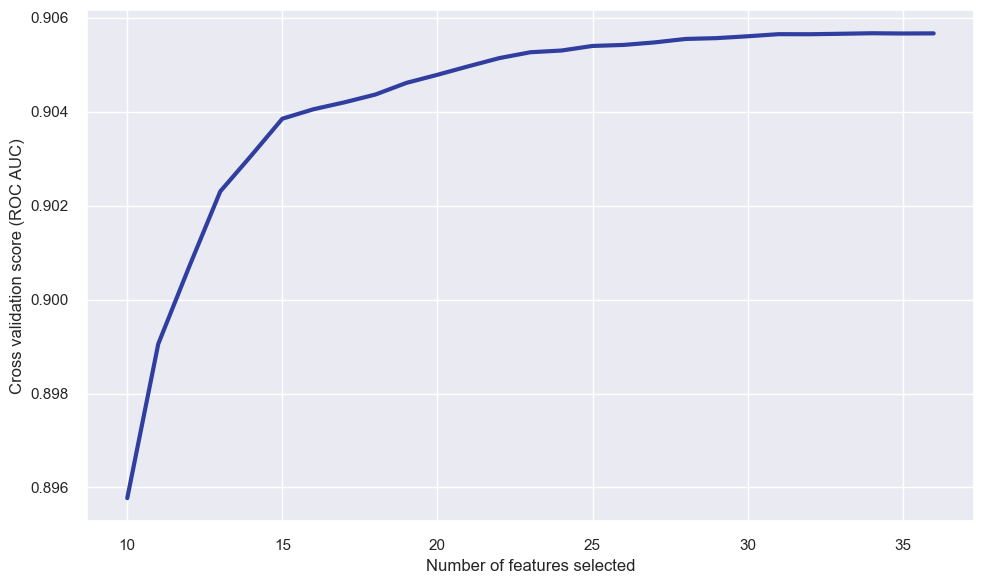

Selected features:
['address_05113', 'address_11650', 'address_22690', 'address_29597', 'address_30723', 'address_48052', 'address_70466', 'address_86630', 'address_93700', 'term_ 60 months', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'x0_10+ yrs', 'x0_2-7 yrs', 'x0_8-9 yrs', 'loan_amnt', 'int_rate', 'open_acc', 'total_acc', 'annual_inc', 'revol_bal', 'dti', 'revol_util', 'purpose_other', 'purpose_small_business', 'issue_qtr', 'issue_month', 'mort_acc', 'pub_rec', 'earliest_cr_qtr', 'title_word_rank', 'emp_title_word_rank']


In [309]:
# Applying RFECV Recursive Feature Extraction cross validation to select features with most predictive power
min_features_to_select=10 
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_jobs=-1,
    verbose=1,
    step=1,
    cv=cv,
    scoring='roc_auc',  # You can use other metrics like 'accuracy', 'f1', etc.
    min_features_to_select=10  # Minimum number of features to consider
)
# Fit RFECV
rfecv.fit(X_train_processed_scaled, y_train_encoded)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.tight_layout()
plt.show()

# Get the selected features
selected_features = X_train_processed_scaled.columns[rfecv.support_]
print("Selected features:")
print(selected_features.tolist())

# Create final dataset with selected features
X_train_selected = X_train_processed_scaled[selected_features]

In [310]:
# Not selected Features
X_train_processed_scaled.columns[~rfecv.support_]

Index(['home_ownership_OTHERS', 'x0_<1 yr'], dtype='object')

Through Recursive  Feature extraction we can see that the maximum roc auc occurs when we use 34 of the 36 total features. There might be some redundant information in the the one hot encoded features of home ownership and emp length columns. We can remove these features ('home_ownership_OTHERS', 'emp_length_<1 yr')

The features left are zipcode , loan_term , home_ownership (OWN , RENT or others) , verification status , employee length (4 groups - <=1 , 2-7 , 8-9 , 10+) , loan amount , interest rate , open accounts , total accounts , annual income , revolving balance , dti , revolving util , purpose (small_busness , family and others) , issue date quarter , issue month , mortgage accounts , public records ,  earliest credit quarter , title word rank , employee title word rank . 

In [313]:
def preprocess(loan_data_t,default = None):
    loan_data = loan_data_t.copy()
    try:
        default_encoded = y_encoder.transform(default[loan_data.index])
    except:
        default_encoded = None
    loan_data_processed = pd.DataFrame(index = loan_data.index)
    zipcodes = loan_data['address'].apply(lambda x : x.split()[-1]) 
    loan_data_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(zipcodes)).toarray()

    loan_data_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(loan_data[['term']])

    loan_data_processed[ho_encoder.get_feature_names_out()] = ho_encoder.transform(pd.DataFrame(loan_data['home_ownership'].apply(home_ownership_cleanup)))

    loan_data_processed[vs_encoder.get_feature_names_out()] = vs_encoder.transform(pd.DataFrame(loan_data['verification_status']))

    emp_length_imputed = emp_len_imputer.transform(pd.DataFrame(loan_data['emp_length'].apply(empl_length_num)))

    loan_data_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = loan_data.index).apply(emp_len_bin)))
    
    loan_data_processed['loan_amnt'] = loan_data['loan_amnt'].clip(upper = 38000)
    loan_data_processed['int_rate'] = loan_data['int_rate']
    loan_data_processed['open_acc'] = loan_data['open_acc'].clip(upper=23)
    loan_data_processed['total_acc'] = loan_data['total_acc'].clip(upper=54)

    loan_data_processed['annual_inc'] = loan_data['annual_inc'].clip(upper=150000)

    loan_data_processed['revol_bal'] = pd.DataFrame(loan_data['revol_bal'].clip(upper = 40000))
    loan_data_processed['dti'] = loan_data['dti'].clip(lower = 0,upper = 40)

    loan_data_processed['revol_util'] = loan_data['revol_util'].fillna(revol_util_median).clip(upper = 129)

    loan_data_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.transform(pd.DataFrame(loan_data['purpose'].apply(lambda x : 'family' if x in ['credit_card','home_improvement','major_purchase','educational','wedding','car','vacation','house'] else ('other' if x!='small_business' else 'small_business'))
    ))

    loan_data_processed['issue_qtr'] = (pd.to_datetime(loan_data['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)
    loan_data_processed['issue_month'] = pd.to_datetime(loan_data['issue_d'],format='%b-%Y').dt.month

    loan_data_processed['mort_acc'] = pd.Series(mort_acc_imputer.transform(pd.DataFrame(loan_data['mort_acc'])).reshape(1,-1)[0],index = loan_data.index).clip(upper = 7)

    loan_data_processed['pub_rec'] = loan_data['pub_rec'].clip(upper = 1)
    loan_data_processed['earliest_cr_qtr'] = (pd.to_datetime(loan_data['earliest_cr_line'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)

    loan_data_processed['title_word_rank'] = loan_data['title'].fillna('debt').apply(title_check)

    loan_data_processed['emp_title_word_rank'] = loan_data['emp_title'].fillna('missing').apply(emp_title_check)

    loan_data_processed_scaled = pd.DataFrame(standard_scaler.transform(loan_data_processed),columns = loan_data_processed.columns)
    loan_data_final = loan_data_processed_scaled[selected_features]
    return loan_data_final,default_encoded


In [314]:
# Applying preprocessing to Validation dataset
X_validation_final,y_validation_final = preprocess(X_validation,y_validation)

* We can choose performance metric precision vs recall importance based on average cost ,loss and profit.

In [316]:
average_cost = df['loan_amnt'].mean()
average_profit_if_not_default = ((df['installment'])*(df['term'].apply(lambda x: int(x[:3])))*(df['loan_status'].map({'Charged Off':0,'Fully Paid':1})) - df['loan_amnt']*(df['loan_status'].map({'Charged Off':0,'Fully Paid':1}))).sum()/df['loan_status'].map({'Charged Off':0,'Fully Paid':1}).sum()
average_loss_if_default = (df['loan_amnt']*(df['loan_status'].map({'Charged Off':1,'Fully Paid':0}))).sum()/(df['loan_status'].map({'Charged Off':1,'Fully Paid':0})).sum()
print("Average Cost of a Loan", average_cost)
print("Average Loss if the loan is defaulted",average_loss_if_default)
print("Average Profit if the loan is not defaulted",average_profit_if_not_default)

Average Cost of a Loan 14113.888089286165
Average Loss if the loan is defaulted 15126.300966873945
Average Profit if the loan is not defaulted 3885.992099309894


Based on the we can see that false negatives are ~4 times (15126/3886) more impactful than false positives.
We can use f-beta score as the performance metric with beta = 2 (√4)

We  will cross validate on different hyperparameters - regularization penalties (l1 , l2 , elastic net) ,regularization parameters (C , l_1 ratio).
We will also use Stratified KFold and search over multiple class weights for handling class imbalance

### Model Selection using RandomizedSearchCV

In [320]:
param_distributions = [
    # For liblinear solver
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': loguniform(1e-4, 1e3),
        'class_weight': ['balanced', None, {0:1, 1:3},{0:1,1:4}, {0:1, 1:5},{0:1,1:8}]
    },
    # For saga solver (supports all penalties)
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': loguniform(1e-4, 1e3),
        'l1_ratio': uniform(0, 1), 
        'class_weight': ['balanced', None, {0:1, 1:3},{0:1,1:4}, {0:1, 1:5},{0:1,1:8}]
    },
    # For lbfgs solver
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', None],
        'C': loguniform(1e-4, 1e3),
        'class_weight': ['balanced', None, {0:1, 1:3},{0:1,1:4}, {0:1, 1:5},{0:1,1:8}]
    }
]

# Stratified K Fold for handling class imbalance
cv = StratifiedKFold(n_splits=4, shuffle=True,random_state=42)

# Create model
model = LogisticRegression(random_state=42, max_iter=1000)

# Set up Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    random_state=42,
    n_iter=12,
    cv=cv,
    scoring=make_scorer(fbeta_score,beta = 2), 
    verbose=3,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_selected, y_train_encoded)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


C:\Users\sanju\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=12, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C1AC3A9CA0>,
                                         'class_weight': ['balanced', None,
                                                          {0: 1, 1: 3},
                                                          {0: 1, 1: 4},
                                                          {0: 1, 1: 5},
                                                          {0: 1, 1: 8}],
                                         'penalty'...
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     None],
                                         'solver': ['saga']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C1AC3A8890>,
                                         'class_weight': ['balanced', None,
                                                          {0: 1, 1: 3},
                                                          {0: 1, 1: 4},
                                                          {0: 1, 1: 5},
                                                          {0: 1, 1: 8}],
                                         'penalty': ['l2', None],
                                         'solver': ['lbfgs']}],
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=3)

### Model Evaluation

Best Parameters:
{'C': 0.00025502648504032837, 'class_weight': {0: 1, 1: 5}, 'penalty': None, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7247

Test Set Performance Metrics:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     50937
           1       0.45      0.85      0.59     12428

    accuracy                           0.77     63365
   macro avg       0.70      0.80      0.71     63365
weighted avg       0.85      0.77      0.79     63365

Confusion Matrix:
[[38053 12884]
 [ 1896 10532]]
ROC AUC: 0.9045
PR AUC: 0.7775
F beta Score (beta=2): 0.7201

Top 5 Models:
Rank 1: Score = 0.7247, Params = {'C': 0.00025502648504032837, 'class_weight': {0: 1, 1: 5}, 'solver': 'lbfgs'}
Rank 2: Score = 0.7246, Params = {'C': 1.7898389848671583, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'}
Rank 3: Score = 0.7220, Params = {'C': 0.15577217702693022, 'class_weight': {0: 1, 1: 8}, 'penalty': 'l2', 'solver': 'lbfgs'}
R

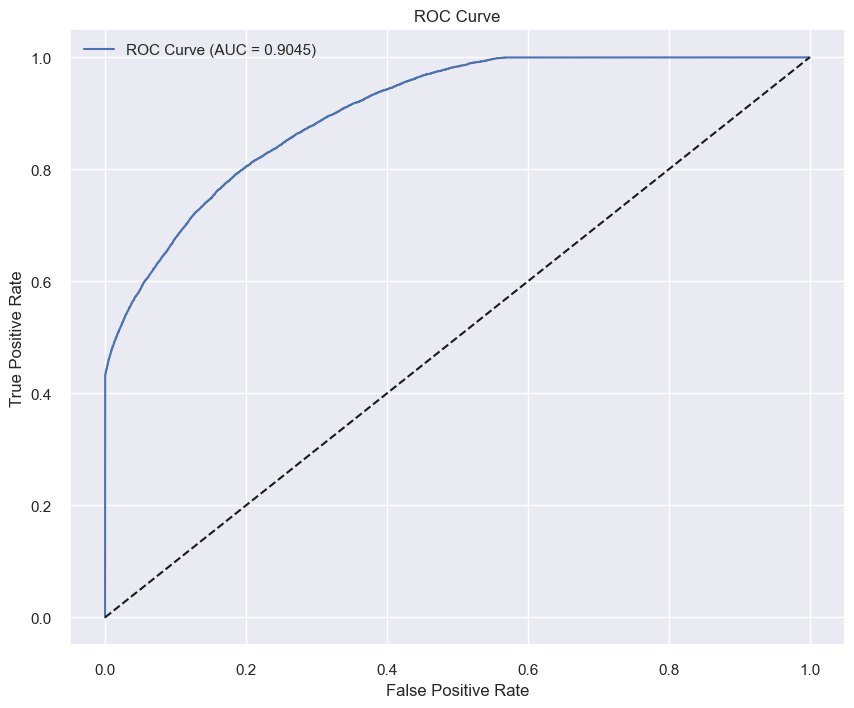

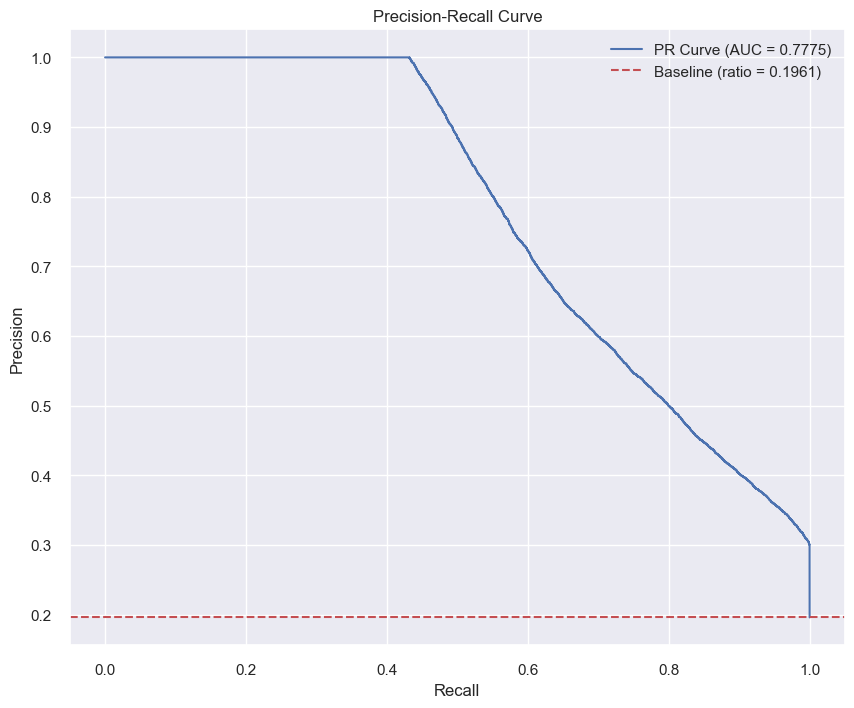


Optimal Threshold (based on F beta score): 0.4848

Performance at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     50937
           1       0.44      0.86      0.58     12428

    accuracy                           0.76     63365
   macro avg       0.70      0.80      0.70     63365
weighted avg       0.85      0.76      0.78     63365

Final F Beta Score :  0.7223172324638774
Final PR-AUC Score :  0.7774632385233331
Final ROC-AUC Score :  0.9044804041398407


In [322]:
def evaluate_best_model(random_search, X_test, y_test):
    # Get the best estimator from random search
    best_model = random_search.best_estimator_
    
    # Get predicted probabilities and binary predictions
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    y_pred = best_model.predict(X_test)
    
    # Print best parameters
    print("Best Parameters:")
    print(random_search.best_params_)
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    
    # Calculate metrics
    print("\nTest Set Performance Metrics:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # PR AUC 
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"PR AUC: {pr_auc:.4f}")
    
    # F beta Score
    fb_s = fbeta_score(y_test, y_pred,beta=2)
    print(f"F beta Score (beta=2): {fb_s:.4f}")

    cv_results = pd.DataFrame(random_search.cv_results_)
    
    # Display top 5 models
    top_results = cv_results.sort_values('rank_test_score').head()
    print("\nTop 5 Models:")
    for i, row in top_results.iterrows():
        params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_') and not pd.isna(v)}
        print(f"Rank {row['rank_test_score']}: Score = {row['mean_test_score']:.4f}, Params = {params}")
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    # Add baseline for PR curve (class distribution)
    baseline = np.sum(y_test) / len(y_test)
    plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (ratio = {baseline:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Find optimal threshold (F1 score)
    thresholds = np.linspace(0, 1, 100)
    fb_scores = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        fb = fbeta_score(y_test, y_pred_threshold,beta=2)
        fb_scores.append(fb)
    
    best_threshold_idx = np.argmax(fb_scores)
    best_threshold = thresholds[best_threshold_idx]
    print(f"\nOptimal Threshold (based on F beta score): {best_threshold:.4f}")
    
    # Performance at optimal threshold
    y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
    print("\nPerformance at Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))
    print("Final F Beta Score : ",fbeta_score(y_test, y_pred_optimal,beta=2))
    print("Final PR-AUC Score : ",average_precision_score(y_test, y_pred_proba))
    print("Final ROC-AUC Score : ",roc_auc_score(y_test, y_pred_proba))
    return best_model, best_threshold

# Call the function with your random search results
best_model, optimal_threshold = evaluate_best_model(random_search ,  X_validation_final, y_validation_final)

### Model Performance Analysis
* The f beta score is 0.722 at a threshold of 0.4545.
* The recall for loan default is 0.89 at that threshold which is very high.
*  As the Precision for loan default at optimum threshold is 0.41, which means there will be some missed opportunities.
*  High ROC - AUC 0.9045 indicates good seperation between default and non default loans.
*  The best model uses l2 regularization with very low C indicating high l2 regularization. 
* The class weights are 1:5 - non loan default : loan default,  indicating more weight needed for defaulted loans than the imbalance ratio of 1:4 in favor of non default loans.

In [324]:
# Coefficients of features in the final model and their Permutation importance 
model_coefficients = pd.DataFrame(index = X_train_selected.columns ,columns = ['coefficents','abs_values_coefficients'], data = np.transpose([random_search.best_estimator_.coef_[0],abs(random_search.best_estimator_.coef_[0])]))
print("Coefficients : ",'\n' ,model_coefficients.sort_values(by = 'abs_values_coefficients',axis = 0,ascending=False))
feature_imp = permutation_importance(random_search.best_estimator_,X_validation_final,y_validation_final,n_repeats=10,random_state=42)
print("Permutation Importance : ",'\n', pd.Series(data = abs(feature_imp['importances_mean']),index = X_validation_final.columns).sort_values(ascending=False))

Coefficients :  
                                      coefficents  abs_values_coefficients
address_93700                           4.161544                 4.161544
address_11650                           4.155668                 4.155668
address_86630                           4.103464                 4.103464
address_70466                           3.779408                 3.779408
address_30723                           3.771564                 3.771564
address_48052                           3.768646                 3.768646
address_22690                           3.760969                 3.760969
address_05113                          -3.006253                 3.006253
address_29597                          -2.994338                 2.994338
int_rate                                0.447410                 0.447410
term_ 60 months                         0.204727                 0.204727
annual_inc                             -0.204566                 0.204566
dti                 

### Features Insights Based on the Model coefficients and Permutation importance :
*  Zipcodes : The most important features contributing to model performance is Zipcodes which is not ideal in terms of data bias. 3 zipcodes seem to have only defaulted loans. 3 of them have only fully paid loans. rest of the 4 have approximately 1:4 ratio of default to fully paid loans
*  Interest Rate : After zipcode, interest rate is the most important parameter which contributes most to prediction. 
*  Term and Loan Amount : Loan parameters like amount and term come next in terms of default prediction.
*  Loanee profile : Loanee profile parameters like Debt to Income , No of open accounts , Annual Income , Home ownersip , Revolving Utilization , Total Accounts , Verification Status , Mortgage Accounts , Revolving balance , Public records , Earliest credit Quarter , Issue month aldo contribute to default prediction in that order.
*  Loan parameters like Issue Quarter and Purpose especially is its small business are also significant.

We will create a  baseline  loan profile and compute its loan default probability using our model.

In [327]:
def empl_string(x):
    if x == 0 :
        return '<1 year'
    elif x == 1 :
        return '1 year'
    elif 1 <=x <= 9:
        return str(int(x)) + ' years'
    else:
        return '10+ years'    

df_baseline = df.loc[:,['loan_amnt', 'term', 'int_rate',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'purpose', 'title', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'address']].dropna()
df_baseline['address'] = df_baseline['address'].apply(lambda x : x.split()[-1]) 
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_length_num)
df_baseline.loc[:,['term','emp_title', 'emp_length', 'home_ownership',
       'verification_status','purpose', 'title','address']].mode()
baseline_loan = pd.concat([df_baseline.loc[:,['term','emp_title','home_ownership',
       'verification_status','purpose', 'title','address']].mode().loc[0],df_baseline.loc[:,['loan_amnt','int_rate','annual_inc','dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc','emp_length']].quantile(0.5)])
baseline_loan['emp_length'] = empl_string(baseline_loan['emp_length'])
baseline_loan['issue_d']  = (datetime.datetime.today() + (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - datetime.datetime.today() ).quantile(0.5)).strftime("%b-%Y")
baseline_loan['earliest_cr_line'] = (pd.to_datetime(baseline_loan['issue_d'],format = '%b-%Y') - (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - pd.to_datetime(df_baseline['earliest_cr_line'],format = '%b-%Y') ).quantile(0.5)).strftime("%b-%Y")
best_model = random_search.best_estimator_
baseline_prob  = best_model.predict_proba(preprocess(pd.DataFrame(data = [baseline_loan.values],columns = baseline_loan.index))[0])[0][1]
print("Baseline Loan : ",baseline_loan)
print("Baseline Probability : ",baseline_prob)
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_string)

Baseline Loan :  term                            36 months
emp_title                         Teacher
home_ownership                   MORTGAGE
verification_status       Source Verified
purpose                debt_consolidation
title                  Debt consolidation
address                             70466
loan_amnt                         12400.0
int_rate                            13.35
annual_inc                        65000.0
dti                                 17.25
open_acc                             11.0
pub_rec                               0.0
revol_bal                         11480.0
revol_util                           55.3
total_acc                            24.0
mort_acc                              1.0
emp_length                        6 years
issue_d                          May-2014
earliest_cr_line                 Dec-1999
dtype: object
Baseline Probability :  0.4894939645197755


The baseline loan profile has a computed loan default probability of 0.49. 
We will take changes in the features and calculate new probability for each feature and compute the marginal effect of change in each feature on loan default probability.

                                       Feature Change  Probability Change  \
49                               address: 70466→93700            0.510505   
44                               address: 70466→11650            0.510505   
48                               address: 70466→86630            0.510505   
42                               address: 70466→05113           -0.489494   
46                               address: 70466→29597           -0.489494   
43                               address: 70466→00813           -0.489474   
31         purpose: debt_consolidation→small_business            0.128623   
20                        term:  36 months→ 60 months            0.118633   
5                                 annual_inc (-65000)            0.098148   
4                                 annual_inc (+65000)           -0.097345   
6                                           dti (+17)            0.093558   
7                                           dti (-17)           -0.092828   

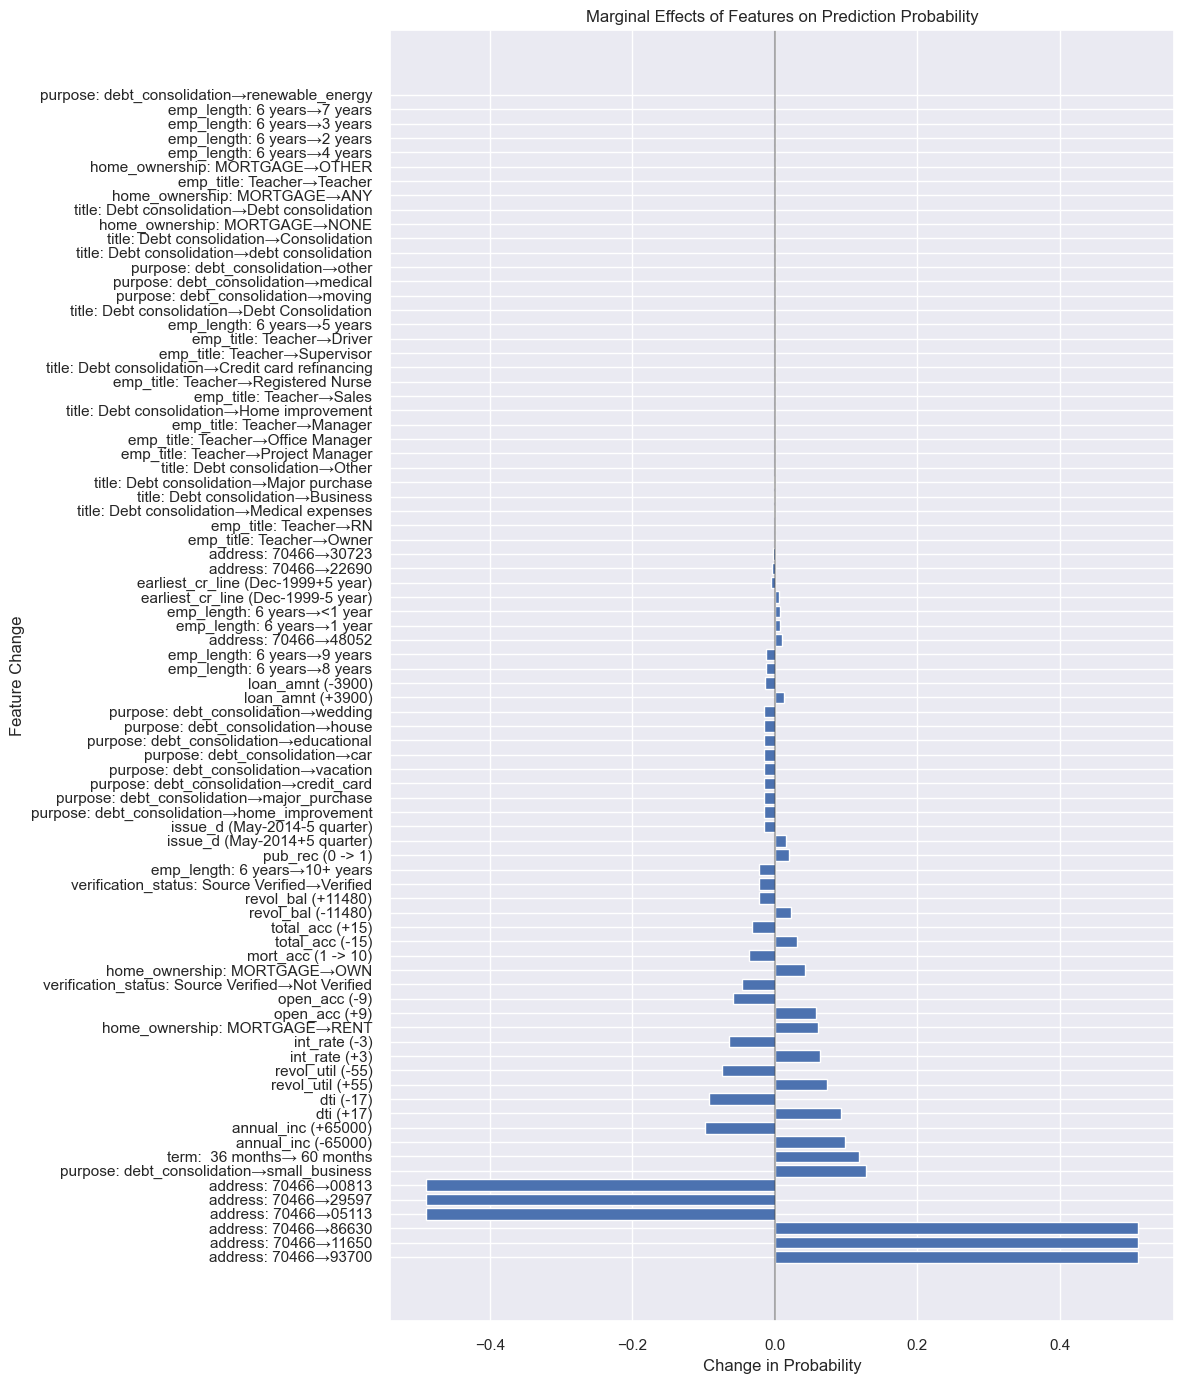

In [329]:

marginal_effects = {}

continuous_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal',  'revol_util', 'open_acc', 'total_acc']
continuous_changes = {i:0.1*(df_baseline[i].max()-df_baseline[i].min()) for i in continuous_features}
continuous_changes['earliest_cr_line'] = 5 # 1 year change in earliest credit date 
continuous_changes['issue_d'] = 5 # 1 quarter change in  issue date
for feature, change in continuous_changes.items():
    # Create modified profile with increased feature value

    modified = baseline_loan.copy()
    if feature == 'earliest_cr_line':
        change_text = '5 year'
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}-{change_text})"] = modified_prob - baseline_prob
    elif feature == 'issue_d':
        change_text = '5 quarter' 
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}-{change_text})"] = modified_prob - baseline_prob
    else:
        change = min(baseline_loan[feature],change)
        change_text = f"{change:.0f}"
        modified[feature] = baseline_loan[feature] + change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = baseline_loan[feature] - change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (-{change_text})"] = modified_prob - baseline_prob

# For categorical variables - compare to reference level
categorical_features = ['term','home_ownership', 'verification_status', 'purpose','address','emp_length']

for feature in categorical_features:
    # Get current value in baseline
    reference_value = baseline_loan[feature]
    
    # Get all possible values for this feature (excluding reference)
    possible_values = [v for v in df_baseline[feature].unique() if v != reference_value]
    
    for value in possible_values:
        # Create modified profile with new category
        modified = baseline_loan.copy()
        modified[feature] = value
        
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
    
        marginal_effects[f"{feature}: {reference_value}→{value}"] = modified_prob - baseline_prob
for emp_name in df_baseline['emp_title'].value_counts().iloc[:10].keys():
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['emp_title'] = emp_name
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"emp_title: {baseline_loan['emp_title']}→{emp_name}"] = modified_prob - baseline_prob
for loan_title in df_baseline['title'].value_counts().iloc[:10].keys():
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['title'] = loan_title
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"title: {baseline_loan['title']}→{loan_title}"] = modified_prob - baseline_prob

modified = baseline_loan.copy()
modified['pub_rec'] = 1
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"pub_rec (0 -> 1)"] = modified_prob - baseline_prob

modified = baseline_loan.copy()
modified['mort_acc'] = 10
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"mort_acc (1 -> 10)"] = modified_prob - baseline_prob

# Convert to DataFrame for easier handling
effects_df = pd.DataFrame(marginal_effects.items(), columns=['Feature Change', 'Probability Change'])

# Sort by absolute effect size
effects_df['Abs Effect'] = effects_df['Probability Change'].abs()
effects_df = effects_df.sort_values('Abs Effect', ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(effects_df)

# Plot
plt.figure(figsize=(12,14))
plt.barh(effects_df['Feature Change'], effects_df['Probability Change'])
plt.xlabel('Change in Probability')
plt.ylabel('Feature Change')
plt.title('Marginal Effects of Features on Prediction Probability')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

 ### Marginal effects of features:
 *   Change in Zipcode to pure loan default or non loan default zipcodes causes major change in probabiliies (~50%).
 *   Changing the Loan Purpose to Small Business from debt consolidation causes  increase in default probability by 13%
 *   Increasing Loan term from 36 months to 60 months increases loan default probability by 12%
 *   Increasing Annual Income by 65000 from 65000  decreases the loan default probability by 10% and vice versa.
 *   Increasing dti ratio from 17 to 34 increases loan default probability by 10% and decreasing it to 0 decreases loan default probability by 10%
 *   Increasing revolving utilization from 55 to 110 % increases loan default probability by 7.5%.
 *   Increasing interest rate from 13 to 3 % increased loan default probability by 6.4% and decreases by same amount when it decreases from 13 to 10%.
 *   Changing Home ownership from mortgage to rent increases loan default probability by 6 %.
 *   Increasing open accounts from 11 to 20 increases loan default probability by 6%.
 *   Changing Verification Status from Source Verified to Not Verified  increases loan default probability by 4.5%.
 *   Changing Home ownership from mortgage to own increases loan default probability by 4 %.
 *  Increasing number of mortgage accounts from 1 to 10 decreases probabilityt by 3.5%.
 *   Increasing total accounts from 24 to 39 decreases loan default probability by 3%.
 *   Doubling Revolving Balance from 11480 to 22960 decreases loan default probability by 2%.
 *  Increasing loan amount from 12400 to 16000 increases loan default probability by 1.3%
 *   Changing Verification Status from Source Verified to fully verified  decreases loan default probability by 2.2%.
 *   Changing employment length from 6 years to 10+ years causes loan default probability to reduce by 2.1%
 *   Changing Purpose of loan from debt consolidation to Family purpose like wedding , house , home improvement ,car, credit card, educational , major purchase and vacation,  decreases loan default probability by 1.3%.
  *   Changing employment length from 6 years to 8,9 years causes loan default probability to reduce by 1.25%
  *  If there are public records for the loanee the loan default probability increases by 2%.
  *  If the loan was issued 5 quarters before May 2014 the loan default probability decreases by 1.6% and vice versa.
 * Features like issue date , earliest credit line, title , employee title dont contribute much to predicting loan default probability in the current model.

We willl try a different configuration of features and preprocessing and apply Logistic Regression again.

## Second Approach

* In this approach ww will try different preprocessing , use pub_rec_bankruptcies instead of pub_rec, sub_grade instead of interest rate, create interaction features- income to loan amount ratio , and open acc to total account ratio.
* We will use one hot encode Zipcode , loan term , home ownership (different grouping from previous approach) , Verification Status , Purpose (after grouping categories into debt consolidation , major purchase and using other categories as is), employee title (after extracting top 10 employee titles and grouping rest as others)
* We will impute mortgage accounts and employment length using Annual income.
* We will impute revolving util with its median.
* We will impute pub_rec_bankruptices using pub_rec as they are highly correlated. 
* We will bin loan amount , employment length , dti , mortgage accounts , total accounts , revolving Utilization , Public Bankruptcies,mortgage accounts and convert them to ordinal features.
* We will extract the year instead of quarter for  issue date and earliest credit date and convert into an ordinal feature.
* We will also use the month of issue date.
* We will create interaction features income to loan amount ratio , and open acc to total account ratio and utilized Balance (Revolving Utilization * Revolving Balance).
* We will apply polynomial transformation over the ordinal values of sub grades.
* For handling Class imbalance we will use SMOTE-NC which handles categorical features best.

### Preprocessing

In [335]:

# Label encoding on y_train - loan status
y_encoder = LabelEncoder( )
y_encoder.fit(y_train)
y_encoder.classes_= np.array(['Fully Paid','Charged Off'])
y_train_encoded = y_encoder.transform(y_train[X_train.index])

X_train_processed = pd.DataFrame(index = X_train.index)

# converting employee length to numerical
def empl_length_num(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
# Imputing employee length using annual income
emp_len_imputer = KNNImputer(n_neighbors=1)
X_train_processed['emp_length'] = emp_len_imputer.fit_transform(pd.DataFrame(X_train['emp_length'].apply(empl_length_num)),X_train['annual_inc'])


In [336]:
X_train_processed['emp_length'] = X_train_processed['emp_length'].round().astype('int')

In [337]:
# Binning and converting loan amnts to ordinal feature
loan_amnt_binned,loan_amnt_bins = pd.cut(X_train['loan_amnt'],100,retbins = True)
X_train_processed['loan_amnt'] = loan_amnt_binned.apply(lambda x: loan_amnt_bins.searchsorted(x.right)).astype('int')

In [338]:
# Sub grade ordinal and polynomial transformation
sg_enc = OrdinalEncoder()
X_train_processed['sub_grade'] = 1 / np.sqrt(sg_enc.fit_transform(pd.DataFrame(X_train['sub_grade'])).reshape(1,-1)[0]+1)

In [339]:
# INteraction feature annual income / loan amount 
X_train_processed['income_to_loan'] = X_train['annual_inc']/X_train['loan_amnt']

In [340]:
dti_binned,dti_bins = pd.cut(X_train['dti'].clip(lower = 0,upper = 40),100,retbins=True)
X_train_processed['dti'] = dti_binned.apply(lambda x: dti_bins.searchsorted(x.right)).astype('int')

In [341]:
# Imputing Revolving Util with median and creating new interaction term revol_util*revol_bal = utilized_bal
revol_util_median = X_train['revol_util'].quantile(0.5)
revol_util_imputed = X_train['revol_util'].fillna(revol_util_median)
X_train_processed['utilized_bal'] = (revol_util_imputed*X_train['revol_bal'])


In [342]:
#  Getting the Issue date year and Earliest Credit Line date and converting to ordinal valeus
X_train_processed['issue_yr'] = (pd.to_datetime(X_train['issue_d'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)
X_train_processed['earliest_cr_yr'] = (pd.to_datetime(X_train['earliest_cr_line'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)

In [343]:
# Binning Revolving Utilization and converting to ordinal feature
revol_util_binned,revol_util_bins = pd.qcut(revol_util_imputed,30,duplicates='drop',retbins=True)
X_train_processed['revol_util'] = revol_util_binned.apply(lambda x: revol_util_bins.searchsorted(x.right)).astype('int')

In [344]:
# Binning Total Accounts and converting to ordinal feature
total_acc_binned,total_acc_bins = pd.qcut(X_train['total_acc'],30,duplicates='drop',retbins=True)
X_train_processed['total_acc'] = total_acc_binned.apply(lambda x: total_acc_bins.searchsorted(x.right)).astype('int')

In [345]:
# Interaction feature open_acc/total_acc
X_train_processed['open_acc_ratio'] = X_train['open_acc']/X_train['total_acc']

In [346]:
# Imputing mort_acc using annual income 

mort_acc_imputer = KNNImputer(n_neighbors=1)
X_train['mort_acc'] = mort_acc_imputer.fit_transform(pd.DataFrame(X_train['mort_acc']),X_train['annual_inc']).round()
mort_acc_binned,mort_acc_bins = pd.qcut(X_train['mort_acc'],30,duplicates='drop',retbins=True)
X_train_processed['mort_acc'] = mort_acc_binned.apply(lambda x: mort_acc_bins.searchsorted(x.right)).astype('int')

In [347]:
# Imputing pub_rec_bankruptcies using pub_rec

pub_rec_bankruptcies_imputer = KNNImputer(n_neighbors=1)
pub_rec_bankruptcies_imputed = pub_rec_bankruptcies_imputer.fit_transform(pd.DataFrame(X_train['pub_rec_bankruptcies']),X_train['pub_rec']).round()

X_train_processed['pub_rec_bankruptcies'] = pd.Series(pub_rec_bankruptcies_imputed.reshape(1,-1)[0] , index = X_train_processed.index).clip(upper = 1).astype('int')

In [348]:

X_train_processed['zipcode'] = X_train['address'].apply(lambda x : x.split()[-1]) 
X_train_processed.loc[:,['term','home_ownership','verification_status','purpose']] = X_train.loc[:,['term','home_ownership','verification_status','purpose']] 
top_10_emp_titles = list(X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else x.lower() ))).value_counts(ascending = False).keys()[:10])
X_train_processed['emp_title_top_10'] = X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))
X_train_processed['purpose'] = X_train_processed['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x=='car' else x) )
X_train_processed['home_ownership'] = X_train_processed['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))

In [349]:
ordinal_features = ['emp_length', 'loan_amnt', 'dti', 'issue_yr', 'earliest_cr_yr', 'revol_util', 'total_acc',
                      'mort_acc', 'pub_rec_bankruptcies']
numerical_and_interaction_features = ['sub_grade','income_to_loan','utilized_bal','open_acc_ratio']
categorical_features = ["zipcode","term","home_ownership","verification_status","purpose","emp_title_top_10"]

In [350]:
# Appplying Standard Scaling of processed rows in training data
standard_scaler = StandardScaler()
X_train_numerical_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train_processed[ordinal_features+numerical_and_interaction_features]),columns = ordinal_features+numerical_and_interaction_features,index = X_train_processed.index)


In [351]:
X_train_final = X_train_numerical_scaled.join(X_train_processed[categorical_features])
X_train_final.columns

Index(['emp_length', 'loan_amnt', 'dti', 'issue_yr', 'earliest_cr_yr',
       'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies',
       'sub_grade', 'income_to_loan', 'utilized_bal', 'open_acc_ratio',
       'zipcode', 'term', 'home_ownership', 'verification_status', 'purpose',
       'emp_title_top_10'],
      dtype='object')

In [352]:
cat_indices = [-len(categorical_features) + i for i in range(len(categorical_features))]  

In [353]:
# Applying SMOTE-NC to handle class imbalance
smote_nc = SMOTENC(categorical_features=cat_indices, sampling_strategy=0.5)  
X_res, y_res = smote_nc.fit_resample(X_train_final, y_train_encoded)  

In [354]:
# One-hot encoding for categorical features
ohe = OneHotEncoder(drop="first", handle_unknown="ignore")  
X_res_cat = ohe.fit_transform(X_res[categorical_features])  

In [355]:

# X_res_poly: Polynomial/scaled numerical/ordinal features  
# X_res_cat: One-hot encoded categoricals  
X_final = hstack([X_res.iloc[:,:cat_indices[0]], X_res_cat])  

In [356]:
X_final_train = pd.DataFrame(X_final.toarray(),columns = list(X_res.columns[:cat_indices[0]])+list(ohe.get_feature_names_out()))

In [357]:
# Checking if there  is multicollinearity 

corrv = X_final_train.corr()
for i in corrv.columns:
    for j in corrv.columns:
        if i!=j:
            if corrv.loc[i,j]>0.75 or corrv.loc[i,j]<-0.75:
                print(i,j,corrv.loc[i,j])

emp_title_top_10_manager emp_title_top_10_others -0.7710891667073279
emp_title_top_10_others emp_title_top_10_manager -0.7710891667073279


There seems to be some multicollinearity in Employee title categories.

In [359]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_train, i) for i in range(X_final_train.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)


Variance Inflation Factors:
                                Feature        VIF
42              emp_title_top_10_others  12.387536
27         verification_status_Verified   2.583874
19                        zipcode_70466   2.465581
17                        zipcode_30723   2.457010
18                        zipcode_48052   2.454627
15                        zipcode_22690   2.446751
25                  home_ownership_RENT   2.404420
26  verification_status_Source Verified   2.333580
41             emp_title_top_10_manager   2.225456
13                        zipcode_05113   1.968935
16                        zipcode_29597   1.962011
22                      term_ 60 months   1.880124
6                             total_acc   1.838203
1                             loan_amnt   1.713625
5                            revol_util   1.540820
12                       open_acc_ratio   1.540306
21                        zipcode_93700   1.515507
14                        zipcode_11650   1.509630
20

As "others" category contributes most to multicollinearity we will remove it

In [361]:
X_final_train = X_final_train.drop(axis = 1,columns=['emp_title_top_10_others'])
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_train, i) for i in range(X_final_train.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)


Variance Inflation Factors:
                                Feature       VIF
27         verification_status_Verified  2.255261
25                  home_ownership_RENT  2.212596
26  verification_status_Source Verified  2.073836
22                      term_ 60 months  1.847786
6                             total_acc  1.835710
1                             loan_amnt  1.691050
12                       open_acc_ratio  1.539510
5                            revol_util  1.538255
19                        zipcode_70466  1.478877
18                        zipcode_48052  1.475090
17                        zipcode_30723  1.472660
15                        zipcode_22690  1.469017
11                         utilized_bal  1.459612
7                              mort_acc  1.418949
9                             sub_grade  1.376981
2                                   dti  1.308189
13                        zipcode_05113  1.307813
16                        zipcode_29597  1.304266
4                    

### Feature Selection using Recursive Feature Extraction

Optimal number of features: 47


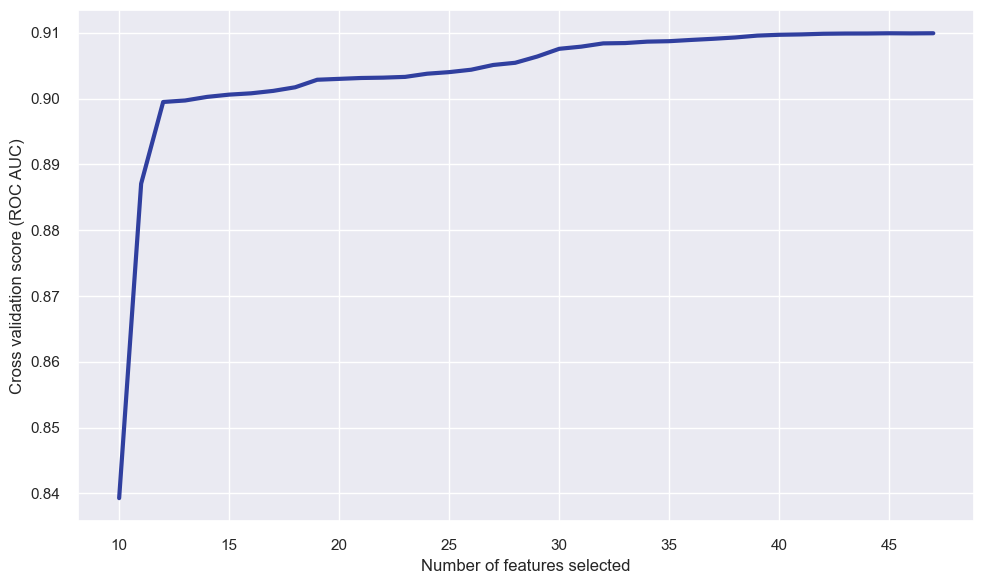

Selected features:
['emp_length', 'loan_amnt', 'dti', 'issue_yr', 'earliest_cr_yr', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade', 'income_to_loan', 'utilized_bal', 'open_acc_ratio', 'zipcode_05113', 'zipcode_11650', 'zipcode_22690', 'zipcode_29597', 'zipcode_30723', 'zipcode_48052', 'zipcode_70466', 'zipcode_86630', 'zipcode_93700', 'term_ 60 months', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'emp_title_top_10_driver', 'emp_title_top_10_engineer', 'emp_title_top_10_manager', 'emp_title_top_10_owner', 'emp_title_top_10_registered nurse', 'emp_title_top_10_sales', 'emp_title_top_10_supervisor', 'emp_title_top_10_teacher']


Index([], dtype='object')

In [363]:

cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_jobs=-1,
    verbose=3,
    step=1,
    cv=cv,
    scoring='roc_auc',  # You can use other metrics like 'accuracy', 'f1', etc.
    min_features_to_select=10  # Minimum number of features to consider
)
# Fit RFECV
rfecv.fit(X_final_train, y_res)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.tight_layout()
plt.show()

# Get the selected features
selected_features = X_final_train.columns[rfecv.support_]
print("Selected features:")
print(selected_features.tolist())

# Create final dataset with selected features
X_train_selected = X_final_train[selected_features]
# Not selected Features
X_final_train.columns[~rfecv.support_]

In [364]:
def preprocess(loan_data_t,default = None):
    loan_data = loan_data_t.copy()
    try:
        default_encoded = y_encoder.transform(default[loan_data.index])
    except:
        default_encoded = None
    loan_data_processed = pd.DataFrame(index = loan_data.index)
    loan_data_processed['emp_length'] = emp_len_imputer.transform(pd.DataFrame(loan_data['emp_length'].apply(empl_length_num))).round().astype('int')

    loan_data_processed['loan_amnt'] = pd.cut(loan_data['loan_amnt'],bins=loan_amnt_bins).apply(lambda x: loan_amnt_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['sub_grade'] = 1 / np.sqrt(sg_enc.transform(pd.DataFrame(loan_data['sub_grade'])).reshape(1,-1)[0]+1)

    loan_data_processed['income_to_loan'] = loan_data['annual_inc']/loan_data['loan_amnt']

    loan_data_processed['dti'] = pd.cut(loan_data['dti'].clip(lower = 0,upper = 40),bins = dti_bins).apply(lambda x: dti_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['utilized_bal'] = (loan_data['revol_util'].fillna(revol_util_median)*loan_data['revol_bal'])

    loan_data_processed['issue_yr'] = (pd.to_datetime(loan_data['issue_d'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)
    loan_data_processed['earliest_cr_yr'] = (pd.to_datetime(loan_data['earliest_cr_line'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)

    loan_data_processed['revol_util'] = pd.cut(loan_data['revol_util'].fillna(revol_util_median),bins = revol_util_bins,include_lowest=True).apply(lambda x: revol_util_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['total_acc'] = pd.cut(loan_data['total_acc'],bins = total_acc_bins,include_lowest=True).apply(lambda x: total_acc_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['open_acc_ratio'] = loan_data['open_acc']/loan_data['total_acc']

    loan_data_processed['mort_acc'] = pd.cut(pd.Series(mort_acc_imputer.transform(pd.DataFrame(loan_data['mort_acc'])).round().reshape(1,-1)[0],index = loan_data.index),bins = mort_acc_bins,include_lowest=True).apply(lambda x: mort_acc_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['pub_rec_bankruptcies'] = pd.Series(pub_rec_bankruptcies_imputer.transform(pd.DataFrame(loan_data['pub_rec_bankruptcies'])).round().reshape(1,-1)[0],index = loan_data.index).clip(upper = 1).astype('int')

    loan_data_processed['zipcode'] = loan_data['address'].apply(lambda x : x.split()[-1]) 

    loan_data_processed.loc[:,['term','verification_status']] = loan_data.loc[:,['term','verification_status']] 

    loan_data_processed['emp_title_top_10'] = loan_data['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))

    loan_data_processed['purpose'] = loan_data['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x=='car' else x) )
    loan_data_processed['home_ownership'] = loan_data['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))

    loan_data_numerical_scaled = pd.DataFrame(standard_scaler.transform(loan_data_processed[ordinal_features+numerical_and_interaction_features]),columns = ordinal_features+numerical_and_interaction_features,index = loan_data_processed.index)

    loan_data_final = loan_data_numerical_scaled.join(pd.DataFrame(ohe.transform(loan_data_processed[["zipcode","term","home_ownership","verification_status","purpose","emp_title_top_10"]]).toarray(),columns = ohe.get_feature_names_out(),index = loan_data_processed.index))

    loan_data_selected = loan_data_final[selected_features]
    return loan_data_selected,default_encoded
# Applying preprocessing to Validation dataset
X_validation_final,y_validation_final = preprocess(X_validation,y_validation)

### Model Selection Using Randomized Search

In [366]:
param_distributions = [
    # For liblinear solver
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': loguniform(1e-4, 1e3)
    },
    # For saga solver (supports all penalties)
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': loguniform(1e-4, 1e3),
        'l1_ratio': uniform(0, 1)
    },
    # For lbfgs solver
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', None],
        'C': loguniform(1e-4, 1e3)
    }
]

# Stratified K Fold for handling class imbalance
cv = StratifiedKFold(n_splits=4, shuffle=True,random_state=42)

# Create model
model = LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced') # we will be using only balanced class weight as we have already applied SMOTE-NC

# Set up Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    random_state=42,
    n_iter=5,
    cv=cv,
    scoring=make_scorer(fbeta_score,beta = 2), 
    verbose=3,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_selected, y_res)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


C:\Users\sanju\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=1000,
                                                random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C1AAB84B90>,
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear']},
                                        {'C': <scipy.s...
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C1AABB6F30>,
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     None],
                                         'solver': ['saga']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C1AC394C20>,
                                         'penalty': ['l2', None],
                                         'solver': ['lbfgs']}],
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=3)

### Model Evaluation

Best Parameters:
{'C': 0.000139345022513376, 'penalty': None, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7914

Test Set Performance Metrics:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     50937
           1       0.47      0.81      0.60     12428

    accuracy                           0.79     63365
   macro avg       0.71      0.79      0.73     63365
weighted avg       0.85      0.79      0.80     63365

Confusion Matrix:
[[39758 11179]
 [ 2386 10042]]
ROC AUC: 0.9004
PR AUC: 0.7716
F beta Score (beta=2): 0.7079

Top 5 Models:
Rank 1: Score = 0.7914, Params = {'C': 0.000139345022513376, 'solver': 'lbfgs'}
Rank 2: Score = 0.7913, Params = {'C': 37.65311476616745, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 3: Score = 0.7913, Params = {'C': 28.697033315125136, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 4: Score = 0.7906, Params = {'C': 0.13207763079904547, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 5: Score = 0.7904, Params = {'

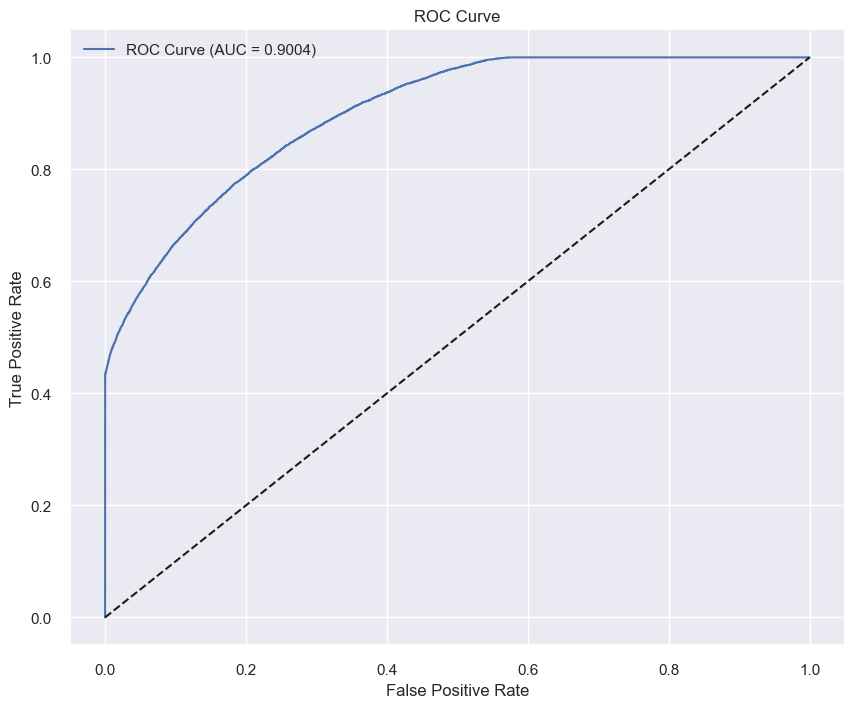

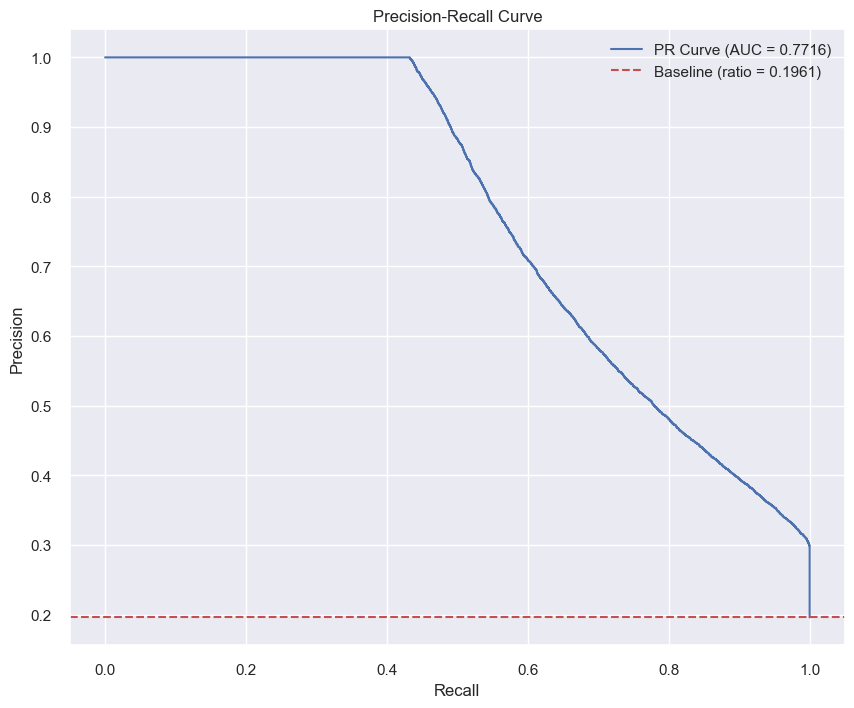


Optimal Threshold (based on F beta score): 0.4040

Performance at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     50937
           1       0.40      0.90      0.55     12428

    accuracy                           0.71     63365
   macro avg       0.68      0.78      0.67     63365
weighted avg       0.85      0.71      0.74     63365

Final F Beta Score :  0.7168352554603441
Final PR-AUC Score :  0.7716271820381744
Final ROC-AUC Score :  0.9003620873507647


In [368]:
# Model Evaluation on Validation set
best_model, optimal_threshold = evaluate_best_model(random_search ,  X_validation_final, y_validation_final)

### Model Performance Analysis

* The f beta score is 0.717 at a threshold of 0.4141
* The recall for loan default is 0.89 at that threshold which is very high.
*  As the Precision for loan default at optimum threshold is 0.41, which means there will be some missed opportunities.
*  High ROC - AUC 0.9005 indicates good seperation between default and non default loans.
*  The best model uses l2 regularization with very high C indicating low l2 regularization. 
* Key difference between this model and the first approach include lesser ROC - AUC score , lesser f beta score.
*  Precision and Recall are same at the threshold the PR -AUC Score has decreased slightly.

In [371]:
# Coefficients of features in the final model and their Permutation importance 
model_coefficients = pd.DataFrame(index = X_train_selected.columns ,columns = ['coefficents','abs_values_coefficients'], data = np.transpose([random_search.best_estimator_.coef_[0],abs(random_search.best_estimator_.coef_[0])]))
print("Coefficients : ",'\n' ,model_coefficients.sort_values(by = 'abs_values_coefficients',axis = 0,ascending=False))
feature_imp = permutation_importance(random_search.best_estimator_,X_validation_final,y_validation_final,n_repeats=10,random_state=42)
print("Permutation Importance : ",'\n', pd.Series(data = abs(feature_imp['importances_mean']),index = X_validation_final.columns).sort_values(ascending=False))

Coefficients :  
                                      coefficents  abs_values_coefficients
zipcode_93700                          24.402470                24.402470
zipcode_11650                          23.962390                23.962390
zipcode_86630                          23.891975                23.891975
zipcode_05113                         -23.016515                23.016515
zipcode_29597                         -22.925851                22.925851
zipcode_48052                           7.649030                 7.649030
zipcode_70466                           7.599236                 7.599236
zipcode_30723                           7.587513                 7.587513
zipcode_22690                           7.584840                 7.584840
purpose_wedding                        -1.329004                 1.329004
emp_title_top_10_engineer              -1.014331                 1.014331
purpose_house                          -0.832905                 0.832905
sub_grade           

### Features Insights Based on the Model coefficients and Permutation importance :
*  The importance of Loan Amount seems to have reduced.
*  Issue Year seems less important than Issue Quarter.
* Interaction terms like Open Account ratio , Utilized Balance , ANnual Income to Loan AMount ratio seem to have less importance than their original numerical features (open_acc , revol_util , annual_inc).
*  Employee Title , Purpose have more significance when more categories are used instead of grouping them

In [373]:
def empl_string(x):
    if x == 0 :
        return '<1 year'
    elif x == 1 :
        return '1 year'
    elif 1 <=x <= 9:
        return str(int(x)) + ' years'
    else:
        return '10+ years'    

df_baseline = df.loc[:,['loan_amnt', 'term','sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'address']].dropna()
df_baseline['address'] = df_baseline['address'].apply(lambda x : x.split()[-1]) 
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_length_num)
df_baseline.loc[:,['term','emp_title', 'emp_length', 'home_ownership',
       'verification_status','purpose', 'sub_grade','address']].mode()
baseline_loan = pd.concat([df_baseline.loc[:,['term','emp_title','home_ownership',
       'verification_status','purpose','address','sub_grade']].mode().loc[0],df_baseline.loc[:,['loan_amnt','annual_inc','dti', 'open_acc', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc','emp_length']].quantile(0.5)])
baseline_loan['emp_length'] = empl_string(baseline_loan['emp_length'])
baseline_loan['issue_d']  = (datetime.datetime.today() + (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - datetime.datetime.today() ).quantile(0.5)).strftime("%b-%Y")
baseline_loan['earliest_cr_line'] = (pd.to_datetime(baseline_loan['issue_d'],format = '%b-%Y') - (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - pd.to_datetime(df_baseline['earliest_cr_line'],format = '%b-%Y') ).quantile(0.5)).strftime("%b-%Y")
best_model = random_search.best_estimator_
baseline_prob  = best_model.predict_proba(preprocess(pd.DataFrame(data = [baseline_loan.values],columns = baseline_loan.index))[0])[0][1]
print("Baseline Loan : ",baseline_loan)
print("Baseline Probability : ",baseline_prob)
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_string)

Baseline Loan :  term                             36 months
emp_title                          Teacher
home_ownership                    MORTGAGE
verification_status        Source Verified
purpose                 debt_consolidation
address                              70466
sub_grade                               B3
loan_amnt                          12450.0
annual_inc                         65000.0
dti                                  17.26
open_acc                              11.0
pub_rec_bankruptcies                   0.0
revol_bal                          11475.0
revol_util                            55.3
total_acc                             24.0
mort_acc                               1.0
emp_length                         6 years
issue_d                           May-2014
earliest_cr_line                  Dec-1999
dtype: object
Baseline Probability :  0.30649916383008363


                                       Feature Change  Probability Change  \
47                               address: 70466→93700            0.693501   
42                               address: 70466→11650            0.693501   
46                               address: 70466→86630            0.693501   
40                               address: 70466→05113           -0.306499   
44                               address: 70466→29597           -0.306499   
41                               address: 70466→00813           -0.306278   
68                                   sub_grade: B3→A1           -0.289316   
69                                   sub_grade: B3→G5            0.219833   
36                purpose: debt_consolidation→wedding           -0.201751   
65                           emp_title: Teacher→Owner            0.156680   
35                  purpose: debt_consolidation→house           -0.145315   
30         purpose: debt_consolidation→major_purchase           -0.124586   

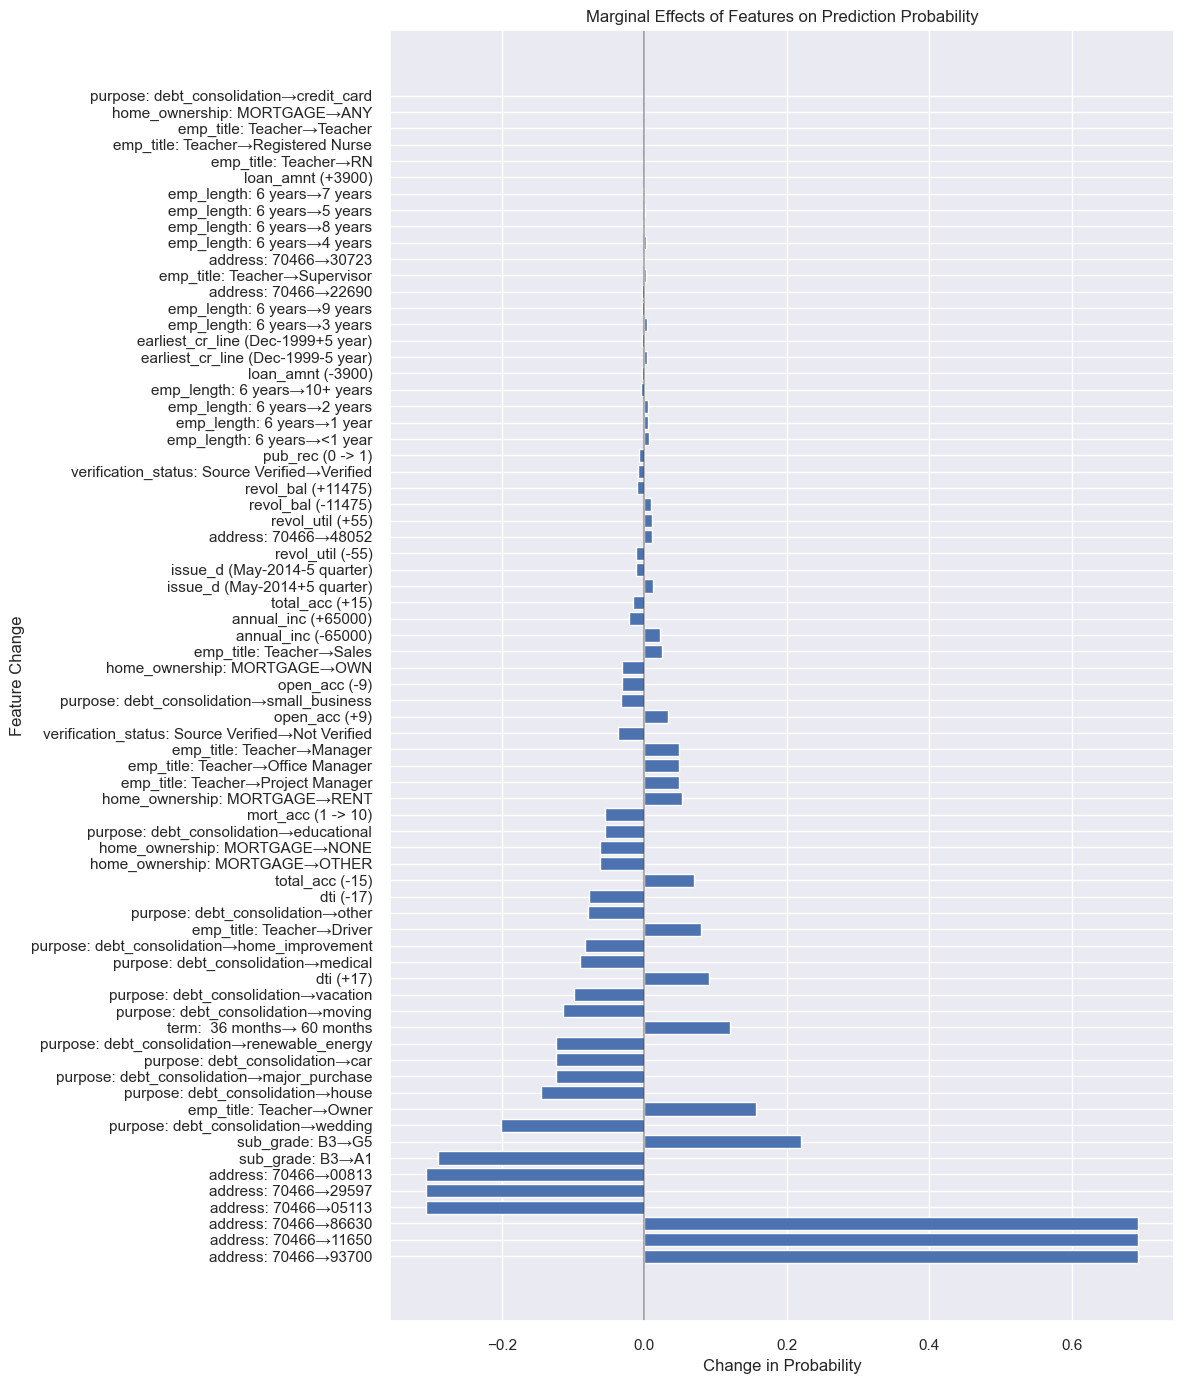

In [374]:

marginal_effects = {}

continuous_features = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal',  'revol_util', 'open_acc', 'total_acc']
continuous_changes = {i:0.1*(df_baseline[i].max()-df_baseline[i].min()) for i in continuous_features}
continuous_changes['earliest_cr_line'] = 5 # 5 year change in earliest credit date 
continuous_changes['issue_d'] = 5 # 5 quarter change in  issue date
for feature, change in continuous_changes.items():
    # Create modified profile with increased feature value

    modified = baseline_loan.copy()
    if feature == 'earliest_cr_line':
        change_text = '5 year'
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}-{change_text})"] = modified_prob - baseline_prob
    elif feature == 'issue_d':
        change_text = '5 quarter' 
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}-{change_text})"] = modified_prob - baseline_prob
    else:
        change = min(baseline_loan[feature],change)
        change_text = f"{change:.0f}"
        modified[feature] = baseline_loan[feature] + change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = baseline_loan[feature] - change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (-{change_text})"] = modified_prob - baseline_prob

# For categorical variables - compare to reference level
categorical_features = ['term','home_ownership', 'verification_status', 'purpose','address','emp_length']

for feature in categorical_features:
    # Get current value in baseline
    reference_value = baseline_loan[feature]
    
    # Get all possible values for this feature (excluding reference)
    possible_values = [v for v in df_baseline[feature].unique() if v != reference_value]
    
    for value in possible_values:
        # Create modified profile with new category
        modified = baseline_loan.copy()
        modified[feature] = value
        
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
    
        marginal_effects[f"{feature}: {reference_value}→{value}"] = modified_prob - baseline_prob
for emp_name in df_baseline['emp_title'].value_counts().iloc[:10].keys():
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['emp_title'] = emp_name
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"emp_title: {baseline_loan['emp_title']}→{emp_name}"] = modified_prob - baseline_prob

for sub_grade in ['A1','G5']:
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['sub_grade'] = sub_grade
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"sub_grade: {baseline_loan['sub_grade']}→{sub_grade}"] = modified_prob - baseline_prob


modified = baseline_loan.copy()
modified['pub_rec_bankruptcies'] = 1
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"pub_rec (0 -> 1)"] = modified_prob - baseline_prob

modified = baseline_loan.copy()
modified['mort_acc'] = 10
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"mort_acc (1 -> 10)"] = modified_prob - baseline_prob

# Convert to DataFrame for easier handling
effects_df = pd.DataFrame(marginal_effects.items(), columns=['Feature Change', 'Probability Change'])

# Sort by absolute effect size
effects_df['Abs Effect'] = effects_df['Probability Change'].abs()
effects_df = effects_df.sort_values('Abs Effect', ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(effects_df)

# Plot
plt.figure(figsize=(12,14))
plt.barh(effects_df['Feature Change'], effects_df['Probability Change'])
plt.xlabel('Change in Probability')
plt.ylabel('Feature Change')
plt.title('Marginal Effects of Features on Prediction Probability')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

 ### Marginal effects of features:
*  As the probability of baseline loan has reduced from 0.45 to 0.3 the marginal effects have also shifted right.
*  Sub grade has a more visible effect on loan default probability. 
*  Each category in Purpose seem to contribute more towards loan default probability.
*  Top employee titles have visible marginal effects. FO example changing Employee title from teacher to owner reduces probablity by ~0.2.

### Comparison between First and Second Approach
*  The model performance is very similar between the two approaches.
*  Some marginal effects of purpose , employee title , sub grade were not used in the first approach.

# Final Approach

* We will use the best model parameters in the first approach. 
* We will handle purpose , employee title and home ownership the second approach way.
* We will apply the same preprocessing for rest of the features as the first approach.

### Preprocessing

In [380]:
X_train_processed = pd.DataFrame(index = X_train.index)

# Label encoding on y_train - loan status
y_encoder = LabelEncoder( )
y_encoder.fit(y_train)
y_encoder.classes_= np.array(['Fully Paid','Charged Off'])
y_train_encoded = y_encoder.transform(y_train[X_train.index])


# Capping Loan amounts at 38000
X_train_processed['loan_amnt'] = X_train['loan_amnt'].clip(upper = 38000)
# Using interest rates as is
X_train_processed['int_rate'] = X_train['int_rate']
# Capping Open Accounts at 23
X_train_processed['open_acc'] = X_train['open_acc'].clip(upper=23)
# Capping Total Accounts at 54
X_train_processed['total_acc'] = X_train['total_acc'].clip(upper=54)
# Capping Annual Income at 150000
X_train_processed['annual_inc'] = X_train['annual_inc'].clip(upper=150000)
# Capping Revolving Balance at 40000
X_train_processed['revol_bal'] = X_train['revol_bal'].clip(upper = 40000)
# Capping Dti between 0 and 40
X_train_processed['dti'] = X_train['dti'].clip(lower = 0,upper = 40)
# Imputing Revolving Util with median and capping values at 129
revol_util_median = X_train['revol_util'].quantile(0.5)
X_train_processed['revol_util'] = X_train['revol_util'].fillna(revol_util_median).clip(upper = 129)
# Imputing mort_acc using annual income 
mort_acc_imputer = KNNImputer(n_neighbors=1)
mort_acc_imputed = mort_acc_imputer.fit_transform(pd.DataFrame(X_train['mort_acc']),X_train['annual_inc']).round()
# Capping mort_acc at 7
X_train_processed['mort_acc'] = pd.Series(mort_acc_imputed.reshape(1,-1)[0],index = X_train.index).clip(upper = 7)
#  Getting the Issue date quarter converted to ordinal values and Issue date month 
X_train_processed['issue_qr'] = (pd.to_datetime(X_train['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)
# Capping pub_rec at 1
X_train_processed['pub_rec'] = X_train['pub_rec'].clip(upper = 1)
# Sub grade ordinal and polynomial transformation
sg_enc = OrdinalEncoder()
X_train_processed['sub_grade'] = 1 / np.sqrt(sg_enc.fit_transform(pd.DataFrame(X_train['sub_grade'])).reshape(1,-1)[0]+1)

# Appplying Standard Scaling for only numerical features and ordinal features in training data
standard_scaler = StandardScaler()
X_train_processed = pd.DataFrame(standard_scaler.fit_transform(X_train_processed),columns = X_train_processed.columns)

# converting employee length to numerical
def empl_length_num(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
# Imputing employee length using annual income
emp_len_imputer = KNNImputer(n_neighbors=1)
emp_length_imputed = emp_len_imputer.fit_transform(pd.DataFrame(X_train['emp_length'].apply(empl_length_num)),X_train['annual_inc'])
# Creating bins of employee length and applying one hot encoding
def emp_len_bin(x):   
    if x < 1:
        return '<1 yr'
    if x < 1.5:
        return '1 yr'
    if 1.5 <= x < 7.5 :
        return '2-7 yrs'
    if 7.5 <= x < 9.5:
        return '8-9 yrs'
    if x >= 9.5 :
        return '10+ yrs'
emp_len_encoder = OneHotEncoder(sparse_output=False,drop=['<1 yr']) # We will drop <1 yr as it is the reference category
X_train_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.fit_transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = X_train.index).apply(emp_len_bin)))


# Extracting Zipcode from address and applying one hot encoding
zipcode_encoder = OneHotEncoder(drop=['22690'],sparse_output=False) # We will drop 22690 as it is the reference zipcode with mixed loan status
zipcode_encoder.fit(pd.DataFrame(X_train['address'].apply(lambda x : x.split()[-1]) ))
X_train_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(X_train['address'].apply(lambda x : x.split()[-1]) ))

# Applying one hot encoding on Loan term
term_encoder = OneHotEncoder(sparse_output=False,drop=[' 36 months']) # We will drop 36 months as it is the reference category
term_encoder.fit(pd.DataFrame(X_train['term']))
X_train_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(X_train[['term']])

# Applying one hot encoding for purpose
# Grouping Purpose into Debt Consolidation , Major Purchase and using other categories as is and applying one hot encoding
purpose_grouped = X_train['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x in ['home_improvement','car','wedding'] else x) )
purpose_encoder = OneHotEncoder(sparse_output=False,drop=['debt_consolidation']) # We will drop debt_consolidation as it is the reference category
X_train_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.fit_transform(pd.DataFrame(purpose_grouped))


# Applying one hot encoding for home ownership
home_ownership_grouped = X_train['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))
ho_encoder = OneHotEncoder(sparse_output=False,drop= ['OTHER']) # We will drop OTHER as it is the reference category
X_train_processed[ho_encoder.get_feature_names_out()] = ho_encoder.fit_transform(pd.DataFrame(home_ownership_grouped))

# Applying one hot encoding for verfication status
vs_encoder = OneHotEncoder(sparse_output=False,drop=['Not Verified']) # We will drop Not Verified as it is the reference category
X_train_processed[vs_encoder.get_feature_names_out()] = vs_encoder.fit_transform(pd.DataFrame(X_train['verification_status']))

# Applying one hot encoding for emp_title after grouping into top 10 titles and others
top_10_emp_titles = list(X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else x.lower() ))).value_counts(ascending = False).keys()[:10])
emp_title_encoder = OneHotEncoder(sparse_output=False,drop=['others']) # We will drop others as it is the reference category
X_train_processed[emp_title_encoder.get_feature_names_out()] = emp_title_encoder.fit_transform(pd.DataFrame(X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))
))

# Checking if there  is multicollinearity 
corrv = X_train_processed_scaled.corr()
for i in corrv.columns:
    for j in corrv.columns:
        if i!=j:
            if corrv.loc[i,j]>0.5 or corrv.loc[i,j]<-0.5:
                print(i,j,corrv.loc[i,j])


verification_status_Source Verified verification_status_Verified -0.5197457748160222
verification_status_Verified verification_status_Source Verified -0.5197457748160222
x0_10+ yrs x0_2-7 yrs -0.6163511364185149
x0_2-7 yrs x0_10+ yrs -0.6163511364185149
open_acc total_acc 0.6795419199175577
total_acc open_acc 0.6795419199175577


In [381]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed, i) for i in range(X_train_processed.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)



Variance Inflation Factors:
                                Feature        VIF
35              home_ownership_MORTGAGE  12.047445
37                  home_ownership_RENT   9.339237
14                           x0_2-7 yrs   6.637672
13                           x0_10+ yrs   5.155310
1                              int_rate   3.104746
36                   home_ownership_OWN   3.059859
11                            sub_grade   2.711939
39         verification_status_Verified   2.487082
3                             total_acc   2.319385
2                              open_acc   2.290588
38  verification_status_Source Verified   2.249238
15                           x0_8-9 yrs   2.108978
5                             revol_bal   2.052669
22                        address_70466   2.006019
20                        address_30723   2.002746
21                        address_48052   1.989496
0                             loan_amnt   1.962405
25                      term_ 60 months   1.936153
4 

### Feature Selection using Recursive Feature Extraction

Fitting estimator with 49 features.
Fitting estimator with 48 features.
Optimal number of features: 47


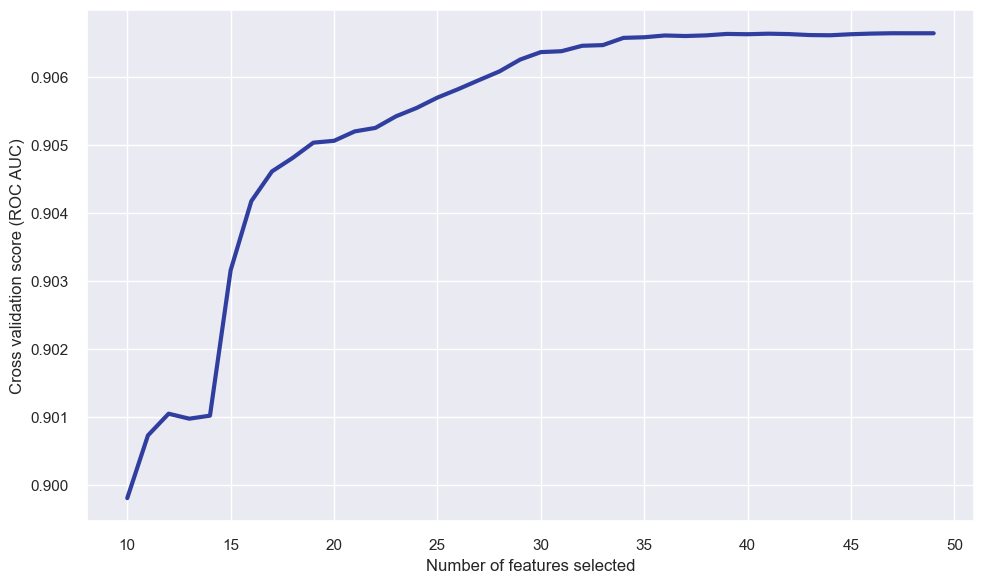

Selected features:
['loan_amnt', 'int_rate', 'open_acc', 'total_acc', 'annual_inc', 'revol_bal', 'dti', 'revol_util', 'mort_acc', 'issue_qr', 'pub_rec', 'sub_grade', 'x0_1 yr', 'x0_10+ yrs', 'x0_2-7 yrs', 'x0_8-9 yrs', 'address_00813', 'address_05113', 'address_11650', 'address_29597', 'address_48052', 'address_70466', 'address_86630', 'address_93700', 'term_ 60 months', 'purpose_educational', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'verification_status_Source Verified', 'verification_status_Verified', 'emp_title_director', 'emp_title_driver', 'emp_title_engineer', 'emp_title_manager', 'emp_title_owner', 'emp_title_registered nurse', 'emp_title_sales', 'emp_title_supervisor', 'emp_title_teacher']


Index(['address_30723', 'home_ownership_RENT'], dtype='object')

In [383]:

# Applying RFECV Recursive Feature Extraction cross validation to select features with most predictive power
min_features_to_select=10 
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_jobs=-1,
    verbose=3,
    step=1,
    cv=cv,
    scoring = 'roc_auc',  # You can use other metrics like 'accuracy', 'f1', etc.
    min_features_to_select=10  # Minimum number of features to consider
)
# Fit RFECV
rfecv.fit(X_train_processed, y_train_encoded)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.tight_layout()
plt.show()

# Get the selected features
selected_features = X_train_processed.columns[rfecv.support_]
print("Selected features:")
print(selected_features.tolist())

# Create final dataset with selected features
X_train_selected = X_train_processed[selected_features]
# Not selected Features
X_train_processed.columns[~rfecv.support_]

In [384]:

def preprocess(loan_data_t,default = None):
    loan_data = loan_data_t.copy()
    loan_data_processed = pd.DataFrame(index = loan_data.index)
    try:
        default_encoded = y_encoder.transform(default[loan_data.index])
    except:
        default_encoded = None
    loan_data_processed['loan_amnt'] = loan_data['loan_amnt'].clip(upper = 38000)

    loan_data_processed['int_rate'] = loan_data['int_rate']

    loan_data_processed['open_acc'] = loan_data['open_acc'].clip(upper=23)

    loan_data_processed['total_acc'] = loan_data['total_acc'].clip(upper=54)

    loan_data_processed['annual_inc'] = loan_data['annual_inc'].clip(upper=150000)

    loan_data_processed['revol_bal'] = loan_data['revol_bal'].clip(upper = 40000)

    loan_data_processed['dti'] = loan_data['dti'].clip(lower = 0,upper = 40)

    loan_data_processed['revol_util'] = loan_data['revol_util'].fillna(revol_util_median).clip(upper = 129)

    mort_acc_imputed = mort_acc_imputer.transform(pd.DataFrame(loan_data['mort_acc'])).round()

    loan_data_processed['mort_acc'] = pd.Series(mort_acc_imputed.reshape(1,-1)[0],index = loan_data.index).clip(upper = 7)

    loan_data_processed['issue_qr'] = (pd.to_datetime(loan_data['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)

    loan_data_processed['pub_rec'] = loan_data['pub_rec'].clip(upper = 1)

    loan_data_processed['sub_grade'] = 1 / np.sqrt(sg_enc.transform(pd.DataFrame(loan_data['sub_grade'])).reshape(1,-1)[0]+1)


    loan_data_processed = pd.DataFrame(standard_scaler.transform(loan_data_processed),columns = loan_data_processed.columns)


    emp_length_imputed = emp_len_imputer.transform(pd.DataFrame(loan_data['emp_length'].apply(empl_length_num)))

    loan_data_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = loan_data.index).apply(emp_len_bin)))


    loan_data_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(loan_data['address'].apply(lambda x : x.split()[-1]) ))


    loan_data_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(loan_data[['term']])


    purpose_grouped = loan_data['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x in ['home_improvement','car','wedding'] else x) )
    loan_data_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.transform(pd.DataFrame(purpose_grouped))

    home_ownership_grouped = loan_data['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))
    loan_data_processed[ho_encoder.get_feature_names_out()] = ho_encoder.transform(pd.DataFrame(home_ownership_grouped))

    loan_data_processed[vs_encoder.get_feature_names_out()] = vs_encoder.transform(pd.DataFrame(loan_data['verification_status']))

    loan_data_processed[emp_title_encoder.get_feature_names_out()] = emp_title_encoder.transform(pd.DataFrame(loan_data['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))
    ))

    loan_data_selected = loan_data_processed[selected_features]
    return loan_data_selected,default_encoded
X_validation_final,y_validation_final = preprocess(X_validation,y_validation)

### Final Model training

In [386]:
final_model = LogisticRegression(class_weight = {0: 1, 1: 5}, penalty=None, solver= 'lbfgs') # Using the best parameters from Randomized Search CV from first approach 
# Fit the final model on the selected features
final_model.fit(X_train_selected,y_train_encoded)

LogisticRegression(class_weight={0: 1, 1: 5}, penalty=None)

### MOdel Evaluation on Validation Set

Best Parameters:
{'C': 0.000139345022513376, 'penalty': None, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7914

Test Set Performance Metrics:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     50937
           1       0.44      0.86      0.58     12428

    accuracy                           0.76     63365
   macro avg       0.70      0.80      0.71     63365
weighted avg       0.85      0.76      0.78     63365

Confusion Matrix:
[[37296 13641]
 [ 1724 10704]]
ROC AUC: 0.9053
PR AUC: 0.7787
F beta Score (beta=2): 0.7227


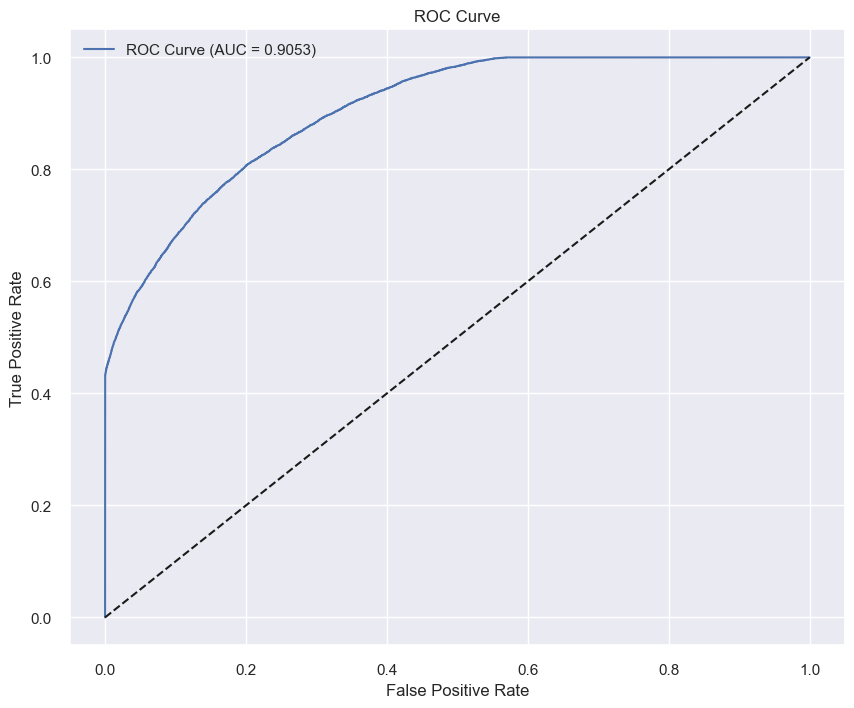

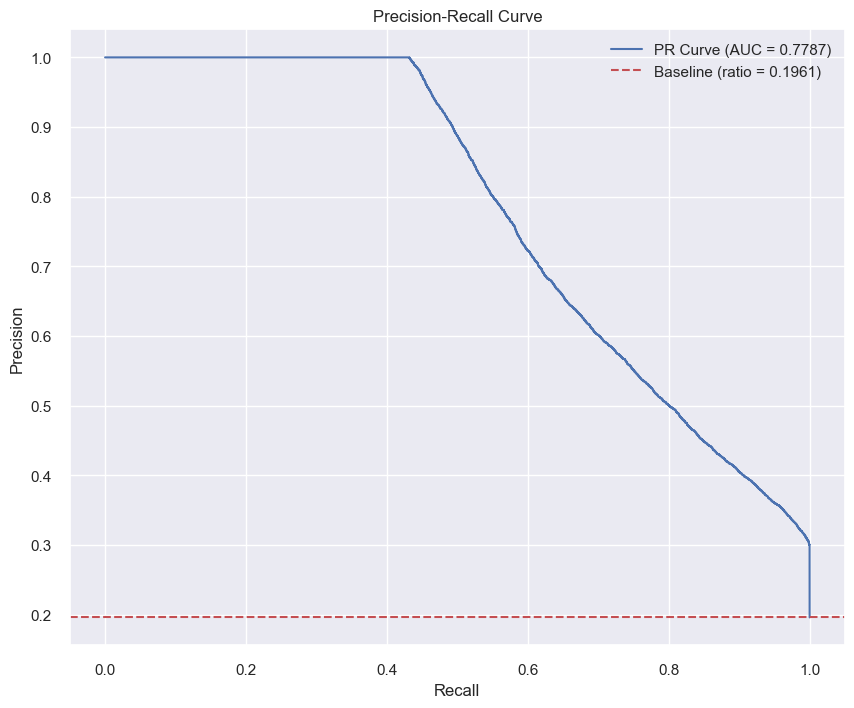


Optimal Threshold (based on F beta score): 0.4646

Performance at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     50937
           1       0.41      0.89      0.56     12428

    accuracy                           0.73     63365
   macro avg       0.69      0.79      0.68     63365
weighted avg       0.86      0.73      0.76     63365

Final F Beta Score :  0.7242234403549987
Final PR-AUC Score :  0.7786667250246041
Final ROC-AUC Score :  0.9053319501900337


In [388]:
def evaluate_best_model(best_model, X_test, y_test):
    
    # Get predicted probabilities and binary predictions
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    y_pred = best_model.predict(X_test)
    
    # Print best parameters
    print("Best Parameters:")
    print(random_search.best_params_)
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    
    # Calculate metrics
    print("\nTest Set Performance Metrics:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # PR AUC 
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"PR AUC: {pr_auc:.4f}")
    
    # F beta Score
    fb_s = fbeta_score(y_test, y_pred,beta=2)
    print(f"F beta Score (beta=2): {fb_s:.4f}")

    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    # Add baseline for PR curve (class distribution)
    baseline = np.sum(y_test) / len(y_test)
    plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (ratio = {baseline:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Find optimal threshold (F1 score)
    thresholds = np.linspace(0, 1, 100)
    fb_scores = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        fb = fbeta_score(y_test, y_pred_threshold,beta=2)
        fb_scores.append(fb)
    
    best_threshold_idx = np.argmax(fb_scores)
    best_threshold = thresholds[best_threshold_idx]
    print(f"\nOptimal Threshold (based on F beta score): {best_threshold:.4f}")
    
    # Performance at optimal threshold
    y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
    print("\nPerformance at Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))
    print("Final F Beta Score : ",fbeta_score(y_test, y_pred_optimal,beta=2))
    print("Final PR-AUC Score : ",average_precision_score(y_test, y_pred_proba))
    print("Final ROC-AUC Score : ",roc_auc_score(y_test, y_pred_proba))
    return best_model, best_threshold

# Call the function with your random search results
best_model, optimal_threshold = evaluate_best_model(final_model,  X_validation_final, y_validation_final)

As the model in the final approach has similar performance as other models. We can finalize this model and evaluate the model on Test Dataset using the optimal Threshold.

#  Model Evaluation on Test data 

In [391]:
X_test_final,y_test_final = preprocess(X_test,y_test) 
y_pred_proba = best_model.predict_proba(X_test_final)[:,1]
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print(classification_report(y_test_final, y_pred_optimal))
print("Final F Beta Score : ",fbeta_score(y_test_final, y_pred_optimal,beta=2))
print("Final PR-AUC Score : ",average_precision_score(y_test_final, y_pred_proba))
print("Final ROC-AUC Score : ",roc_auc_score(y_test_final, y_pred_proba))

              precision    recall  f1-score   support

           0       0.96      0.69      0.81     63671
           1       0.42      0.89      0.57     15535

    accuracy                           0.73     79206
   macro avg       0.69      0.79      0.69     79206
weighted avg       0.86      0.73      0.76     79206

Final F Beta Score :  0.7261608319906254
Final PR-AUC Score :  0.7767423926805508
Final ROC-AUC Score :  0.9049884156412624



# Final Analysis and Business Recommendations

## Summary of Results
- **Model Performance:**  
    - The final logistic regression model (using class weights of 1:5 with no penalty) achieved a ROC-AUC of about 0.90 and an F-beta score (β=2) around 0.72 on the validation set.
    - The optimal probability threshold was approximately 0.465, balancing the higher cost of false negatives against false positives.
    
- **Cost Metrics:**  
    - **Average Cost of a Loan:** ~$14,114  
    - **Average Loss if Defaulted:** ~$15,126  
    - **Average Profit if Not Defaulted:** ~$3,886  
    These figures highlight that defaults are costlier than the loss of potential profit from non-defaults.

## Model Insights
- **Key Predictors:**  
    - **Zip Code:** Specific zip codes had very strong influence on the prediction. Certain regions exhibit higher default risk.
    - **Interest Rate and Loan Term:** Higher interest rates and longer terms are strongly correlated with increased default probability.
    - **Sub-grade & Purpose:** Credit sub-grade and the purpose (e.g., debt consolidation, home improvement) are also important predictors.
    - **Employee Title and Length:** Employee profile features (both title and experience level) have marginal effects that suggest a link between a borrower's occupation stability and loan performance.

- **Marginal Effects Analysis:**  
    - Changes in key features (e.g., increasing loan amount or annual income) had relatively small direct impacts, whereas categorical changes (such as switching zip code or altering purpose from debt consolidation to major purchase) led to larger shifts in predicted default probability.
    - Negative effects (decreasing default probability) were observed when borrowers were in lower-risk zip codes and when interest rates were lower.

## Business Insights and Recommendations

1. **Risk Segmentation by Geography:**
     - The strong influence of zip codes suggests that regional economic conditions or historical borrower behavior should be accounted for. Consider further investigation of geographic clusters and, if warranted, adjust underwriting guidelines for high-risk areas.

2. **Loan Parameter Optimization:**
     - Given that interest rate and term are key drivers, fine-tuning these parameters can help manage risk. Offering lower interest rates or shorter terms to borrowers in higher-risk areas may reduce default risk.

3. **Enhanced Borrower Profiling:**
     - Employee title and length data provide clues to income stability. Refining credit criteria to incorporate more detailed occupational assessments could improve risk discrimination.
     - Additionally, consider incorporating external data (e.g. local employment statistics) to bolster borrower profiles.

4. **Portfolio Management:**
     - With the higher cost of defaults, slightly conservative approval criteria or risk-based pricing may yield better overall portfolio performance.
     - Monitoring the mix of approved loans by purpose (e.g., focusing on those with lower associated default probabilities) may also improve profitability.

5. **Continuous Model Improvement:**
     - The similar performance across different preprocessing strategies implies robustness in the model; however, periodic recalibration and testing on updated data is recommended.
     - Introducing additional variables (if available) or testing alternative modeling methods, such as ensemble techniques, might identify further improvements in predictive power.

## Conclusion
The developed model provides a strong tool for predicting loan default risk. By incorporating these insights into lending policy and portfolio management, stakeholders can better balance risk against profitability while making more informed underwriting decisions.


# Questionnaire

1.  What percentage of customers have fully paid their Loan Amount?  
    Answer : 80.39%
2.  Comment about the correlation between Loan Amount and Installment features.  
    Answer : As Installment will be a function of Loan Amount , Interest and loan term and particulary linear function of Loan Amount , there will be high correlation between the two features,
3.  The majority of people have home ownership as _______.  
    Answer : Mortgage and Rent
4.  People with grades ‘A’ are more likely to fully pay their loan. (T/F)  
    Answer : TRUE
5.  Name the top 2 afforded job titles.  
    Answer : Teacher and Manager
6.  Thinking from a bank's perspective, which metric should our primary focus be on.  
    Answer : Recall , As non performing asset will be big liability.
7.  How does the gap in precision and recall affect the bank?  
    Answer : If Precision << Recall , the bank will miss out on potential profit and opportunities. If Recall << Precision , the bank will risk buying Non performing assets and incur losses. 
8.  Which were the features that heavily affected the outcome?  
    Answer : Zipcode , Interest Rates , Loan Purpose , Loan Term , Sub Grade , Employee Title.
9.  Will the results be affected by geographical location? (Yes/No)  
    Answer : Yes